In [6]:
source("/Users/wyx/Desktop/dissertation/wholecode.R")
library(xgboost)
library(pROC)
library(DescTools)
library(ModelMetrics)
library(rms)

In [2]:
# 设置随机种子以保证可重复性
set.seed(123)

# 数据生成模块
# 数据生成偏移的data_shifted_age模块
# 通用的数据生成模块
generate_shifted_data_both_2_ml <- function(seed, beta_age_start, beta_age_end, beta_cpd_start, beta_cpd_end) {
  set.seed(seed)
  data <- generate_shifted_data_both(
    time_periods = 2,
    n = 9602,
    target_mortality_rate = 0.2,
    age_mean = 64.6,
    age_sd = 12.5,
    sex_prob = 0.309,
    cpd_prob = 0.107,
    pcs_prob = 0.282,
    cps_prob = 0.241, 
    beta_age_start = beta_age_start,
    beta_age_end = beta_age_end,
    beta_cps = 1.086517,
    beta_sex = 0.2196434,
    beta_cpd_start = beta_cpd_start,
    beta_cpd_end = beta_cpd_end,
    beta_pcs = 1.118599
  )
  return(data)
}



experiments_both <- list(
  list(name = "gradual_shifted_cpd_age_1", beta_age_start = 0.0285181, beta_age_end = 0.0285181, beta_cpd_start = 0.1886564, beta_cpd_end = 0.1886564),
  list(name = "gradual_shifted_cpd_age_2", beta_age_start = 0.0285181, beta_age_end = 0.0378427, beta_cpd_start = 0.1886564, beta_cpd_end = 0.2598779),
  list(name = "gradual_shifted_cpd_age_3", beta_age_start = 0.0285181, beta_age_end = 0.0502162, beta_cpd_start = 0.1886564, beta_cpd_end = 0.357987),
  list(name = "gradual_shifted_cpd_age_4", beta_age_start = 0.0285181, beta_age_end = 0.0666354, beta_cpd_start = 0.1886564, beta_cpd_end = 0.4931341),
  list(name = "gradual_shifted_cpd_age_5", beta_age_start = 0.0285181, beta_age_end = 0.0884233, beta_cpd_start = 0.1886564, beta_cpd_end = 0.679302),
  list(name = "gradual_shifted_cpd_age_6", beta_age_start = 0.0285181, beta_age_end = 0.1173351, beta_cpd_start = 0.1886564, beta_cpd_end = 0.9357519),
  list(name = "gradual_shifted_cpd_age_7", beta_age_start = 0.0285181, beta_age_end = 0.1557003, beta_cpd_start = 0.1886564, beta_cpd_end = 1.2890166),
  list(name = "gradual_shifted_cpd_age_8", beta_age_start = 0.0285181, beta_age_end = 0.2066098, beta_cpd_start = 0.1886564, beta_cpd_end = 1.7756459),
  list(name = "gradual_shifted_cpd_age_9", beta_age_start = 0.0285181, beta_age_end = 0.2741652, beta_cpd_start = 0.1886564, beta_cpd_end = 2.4459872),
  list(name = "gradual_shifted_cpd_age_10", beta_age_start = 0.0285181, beta_age_end = 0.3638093, beta_cpd_start = 0.1886564, beta_cpd_end = 3.369395)
)




# 循环200个随机种子，生成数据并计算性能指标
set.seed(123)  # 确保结果可重复
num_simulations <- 200

results_shifted_both_2_ml <- data.frame()

for (exp in experiments_both) {
    results <- data.frame(auc = numeric(num_simulations), o_e = numeric(num_simulations), c_slope = numeric(num_simulations), brier_score = numeric(num_simulations))
    for (i in 1:num_simulations) {
      # 设置随机种子
      set.seed(i)

      data_shifted_xgb <- generate_shifted_data_both_2_ml(i, exp$beta_age_start, exp$beta_age_end, exp$beta_cpd_start, exp$beta_cpd_end)

      # 确保 mortality 变量是因子类型
      data_shifted_xgb$mortality <- as.factor(data_shifted_xgb$mortality)
      data_val$mortality <- as.factor(data_val$mortality)

      # 转换数据格式
      dtrain <- xgb.DMatrix(data = as.matrix(data_shifted_xgb[, -6]), label = as.numeric(data_shifted_xgb$mortality) - 1)
      dval <- xgb.DMatrix(data = as.matrix(data_val[, -6]), label = as.numeric(data_val$mortality) - 1)

      # 设置参数
      params <- list(
        booster = "gbtree",
        objective = "binary:logistic",
        eta = 0.1,
        max_depth = 3,
        eval_metric = "auc"
      )

      # 训练模型
      xgb_model <- xgb.train(params, dtrain, nrounds = 50)


      # 预测
      predictions <- predict(xgb_model, dval)

      # 确保测试集的mortality变量是二进制数值类型
      test_mortality <- as.numeric(data_val$mortality) - 1

      # 计算 AUC
      auc <- roc(data_val$mortality, predictions)$auc
      print(paste("auc:", auc))

      # 绘制 ROC 曲线
      #plot.roc(roc_obj, main = paste("ROC Curve (AUC =", round(auc_value, 2), ")"), col = "blue")

      # 计算 O/E 比率
      observed <- sum(test_mortality)
      expected <- sum(predictions)
      o_e <- observed / expected
      print(paste("O/E 比率:", o_e))

      # 计算校准斜率 (C-slope)
      # 绘制校准曲线并提取斜率
      calibration <- val.prob(predictions, test_mortality, xlab="Predicted Probability", ylab="Observed Probability", pl = FALSE, smooth = FALSE)

      c_slope <- calibration["Slope"]

      print(paste("c_slope:", c_slope))

      # 计算 Brier 分数
      brier_score <- BrierScore(test_mortality, predictions)
      print(paste("Brier 分数:", brier_score))

      # 保存结果
      results[i, ] <- c(auc = auc, o_e = o_e, c_slope = c_slope, brier_score = brier_score)

    }

    # 计算中位数、25%和75%的性能指标
    median_metrics_shifted_both_2_ml <- apply(results, 2, median)
    quantile_25_metrics_shifted_both_2_ml <- apply(results, 2, quantile, probs = 0.25)
    quantile_75_metrics_shifted_both_2_ml <- apply(results, 2, quantile, probs = 0.75)

    # 将实验名称和结果添加到总的结果数据框
    summary_metrics_shifted_both_2_ml <- data.frame(
    experiment = exp$name,
    auc_median = median_metrics_shifted_both_2_ml['auc'],
    auc_25 = quantile_25_metrics_shifted_both_2_ml['auc'],
    auc_75 = quantile_75_metrics_shifted_both_2_ml['auc'],
    o_e_median = median_metrics_shifted_both_2_ml['o_e'],
    o_e_25 = quantile_25_metrics_shifted_both_2_ml['o_e'],
    o_e_75 = quantile_75_metrics_shifted_both_2_ml['o_e'],
    c_slope_median = median_metrics_shifted_both_2_ml['c_slope'],
    c_slope_25 = quantile_25_metrics_shifted_both_2_ml['c_slope'],
    c_slope_75 = quantile_75_metrics_shifted_both_2_ml['c_slope'],
    brier_score_median = median_metrics_shifted_both_2_ml['brier_score'],
    brier_score_25 = quantile_25_metrics_shifted_both_2_ml['brier_score'],
    brier_score_75 = quantile_75_metrics_shifted_both_2_ml['brier_score']
    )
    
    results_shifted_both_2_ml <- rbind(results_shifted_both_2_ml, summary_metrics_shifted_both_2_ml)
    
}


# 打印最终结果
results_shifted_both_2_ml


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721773029066186"
[1] "O/E 比率: 1.00492761969956"
[1] "c_slope: 1.08214770411894"
[1] "Brier 分数: 0.144193146413868"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723537064337265"
[1] "O/E 比率: 0.955001966760982"
[1] "c_slope: 1.19941220580017"
[1] "Brier 分数: 0.143980096355089"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723517811564865"
[1] "O/E 比率: 0.988600208928995"
[1] "c_slope: 1.08122462022372"
[1] "Brier 分数: 0.143396795196087"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718153507855131"
[1] "O/E 比率: 1.00164799288804"
[1] "c_slope: 1.09493627589171"
[1] "Brier 分数: 0.144258225653696"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720014150787713"
[1] "O/E 比率: 0.990912345614894"
[1] "c_slope: 1.10504295691046"
[1] "Brier 分数: 0.143862397757292"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721534432208238"
[1] "O/E 比率: 0.980381851326794"
[1] "c_slope: 1.14469027901473"
[1] "Brier 分数: 0.144227573403214"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719648348112128"
[1] "O/E 比率: 1.01156058928414"
[1] "c_slope: 1.07812913234873"
[1] "Brier 分数: 0.144121861068161"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721309587330576"
[1] "O/E 比率: 1.013353877848"
[1] "c_slope: 1.16546988223026"
[1] "Brier 分数: 0.144503858186405"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720519192263686"
[1] "O/E 比率: 1.00380396563145"
[1] "c_slope: 1.08266387156942"
[1] "Brier 分数: 0.143922795971256"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723186045040486"
[1] "O/E 比率: 0.961384802333983"
[1] "c_slope: 1.09138901561778"
[1] "Brier 分数: 0.143441053126001"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722764203045238"
[1] "O/E 比率: 0.975505984934262"
[1] "c_slope: 1.15194171663635"
[1] "Brier 分数: 0.143565674468126"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723434268284633"
[1] "O/E 比率: 1.00002338347098"
[1] "c_slope: 1.08297112810434"
[1] "Brier 分数: 0.14376233763498"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723621295216511"
[1] "O/E 比率: 0.963476042054943"
[1] "c_slope: 1.10251095762575"
[1] "Brier 分数: 0.143748661478479"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725633897531245"
[1] "O/E 比率: 0.960293245989541"
[1] "c_slope: 1.12579976032525"
[1] "Brier 分数: 0.143565836560028"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722663813589157"
[1] "O/E 比率: 0.992408386265836"
[1] "c_slope: 1.12549976028033"
[1] "Brier 分数: 0.143953623869618"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724901260781553"
[1] "O/E 比率: 0.98253959437278"
[1] "c_slope: 1.11271174865818"
[1] "Brier 分数: 0.143456058719802"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718222611556064"
[1] "O/E 比率: 0.972111215569476"
[1] "c_slope: 1.08646702289099"
[1] "Brier 分数: 0.14480868564646"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718867235631931"
[1] "O/E 比率: 0.990987687379142"
[1] "c_slope: 1.0885341247816"
[1] "Brier 分数: 0.144057998674571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724745519604823"
[1] "O/E 比率: 0.98525081316553"
[1] "c_slope: 1.10197665952435"
[1] "Brier 分数: 0.143919637951351"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721977589772927"
[1] "O/E 比率: 1.00955321993512"
[1] "c_slope: 1.05632875400863"
[1] "Brier 分数: 0.143874405414578"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723913180998064"
[1] "O/E 比率: 0.956587804879745"
[1] "c_slope: 1.10051123034114"
[1] "Brier 分数: 0.143999623480913"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721604223508185"
[1] "O/E 比率: 1.02228212932954"
[1] "c_slope: 1.10644411438837"
[1] "Brier 分数: 0.143798301650612"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722296635715543"
[1] "O/E 比率: 1.00741433498967"
[1] "c_slope: 1.0857379651699"
[1] "Brier 分数: 0.144227347424541"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719624282146629"
[1] "O/E 比率: 0.992331424048872"
[1] "c_slope: 1.07162392463457"
[1] "Brier 分数: 0.14442149970526"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724156934848618"
[1] "O/E 比率: 0.959244298177372"
[1] "c_slope: 1.16468474061115"
[1] "Brier 分数: 0.143503153158902"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722217218029396"
[1] "O/E 比率: 0.974062476438774"
[1] "c_slope: 1.10558388222966"
[1] "Brier 分数: 0.143733954307426"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72652777624978"
[1] "O/E 比率: 0.948332262681202"
[1] "c_slope: 1.18464430915877"
[1] "Brier 分数: 0.143146221351797"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721514148037317"
[1] "O/E 比率: 1.00651409833317"
[1] "c_slope: 1.11592326297214"
[1] "Brier 分数: 0.144268976712476"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718718714244851"
[1] "O/E 比率: 0.986485190547384"
[1] "c_slope: 1.04714626208707"
[1] "Brier 分数: 0.144818000000561"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719457539385671"
[1] "O/E 比率: 1.00627567031853"
[1] "c_slope: 1.07485945615222"
[1] "Brier 分数: 0.144509686816446"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723380291762014"
[1] "O/E 比率: 0.979328921746256"
[1] "c_slope: 1.13750133996741"
[1] "Brier 分数: 0.143370121369158"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722061476852667"
[1] "O/E 比率: 0.99093894726061"
[1] "c_slope: 1.09037980843788"
[1] "Brier 分数: 0.143984266768799"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724335710592325"
[1] "O/E 比率: 1.00222333435687"
[1] "c_slope: 1.16592972837149"
[1] "Brier 分数: 0.143717971144744"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724468761001584"
[1] "O/E 比率: 1.02367389625555"
[1] "c_slope: 1.0839218170054"
[1] "Brier 分数: 0.143664779967634"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721550246985566"
[1] "O/E 比率: 1.00998790239816"
[1] "c_slope: 1.10051574732354"
[1] "Brier 分数: 0.143406783751875"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720305348970252"
[1] "O/E 比率: 0.978532846593878"
[1] "c_slope: 1.12384210269821"
[1] "Brier 分数: 0.144094934153727"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719419033840873"
[1] "O/E 比率: 1.03674577821105"
[1] "c_slope: 1.14236914460482"
[1] "Brier 分数: 0.144900043242548"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724380060728745"
[1] "O/E 比率: 0.972210700260228"
[1] "c_slope: 1.13756868092105"
[1] "Brier 分数: 0.143891547505863"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723468304435839"
[1] "O/E 比率: 0.982927147535179"
[1] "c_slope: 1.18853754198297"
[1] "Brier 分数: 0.143988741966043"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721669201615033"
[1] "O/E 比率: 1.00988965174407"
[1] "c_slope: 1.09406582947784"
[1] "Brier 分数: 0.143979356230844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71953076868069"
[1] "O/E 比率: 1.01729952225077"
[1] "c_slope: 1.08573921299724"
[1] "Brier 分数: 0.144730412945924"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720299160579123"
[1] "O/E 比率: 1.01138910560137"
[1] "c_slope: 1.03042402206373"
[1] "Brier 分数: 0.144023425676649"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721501771255061"
[1] "O/E 比率: 1.00160504983675"
[1] "c_slope: 1.09948284011625"
[1] "Brier 分数: 0.143937404869003"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723565599696356"
[1] "O/E 比率: 1.00666514052442"
[1] "c_slope: 1.09080739396335"
[1] "Brier 分数: 0.143730306611837"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72121091687203"
[1] "O/E 比率: 1.02483408757357"
[1] "c_slope: 1.09660168123487"
[1] "Brier 分数: 0.144272641465091"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721580501342193"
[1] "O/E 比率: 0.988844873352793"
[1] "c_slope: 1.10156960696854"
[1] "Brier 分数: 0.14398102194156"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718611792598134"
[1] "O/E 比率: 0.986224493186296"
[1] "c_slope: 1.05093638019653"
[1] "Brier 分数: 0.144997199617433"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721488019274776"
[1] "O/E 比率: 0.961168824217245"
[1] "c_slope: 1.12714126929008"
[1] "Brier 分数: 0.143606187345784"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722761108849674"
[1] "O/E 比率: 0.983298375105411"
[1] "c_slope: 1.12782919988439"
[1] "Brier 分数: 0.143872276838606"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718509684144517"
[1] "O/E 比率: 0.990792222827176"
[1] "c_slope: 1.11536243474758"
[1] "Brier 分数: 0.144995925808882"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720939659060905"
[1] "O/E 比率: 1.02433550733258"
[1] "c_slope: 1.09485439512072"
[1] "Brier 分数: 0.144384199505344"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720328039737722"
[1] "O/E 比率: 0.989619673513951"
[1] "c_slope: 1.09277588602432"
[1] "Brier 分数: 0.144081498689691"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71853203111248"
[1] "O/E 比率: 1.03443269117005"
[1] "c_slope: 1.16055633480838"
[1] "Brier 分数: 0.144871913265688"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720825173825031"
[1] "O/E 比率: 0.954103875351946"
[1] "c_slope: 1.09999988495478"
[1] "Brier 分数: 0.143931517815111"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721681922196796"
[1] "O/E 比率: 0.984049519281821"
[1] "c_slope: 1.16604992002793"
[1] "Brier 分数: 0.143815202762256"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723565255896849"
[1] "O/E 比率: 0.982226013820414"
[1] "c_slope: 1.11117886979068"
[1] "Brier 分数: 0.143690670288751"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720846145594966"
[1] "O/E 比率: 1.00423153571727"
[1] "c_slope: 1.12897735149329"
[1] "Brier 分数: 0.143864348043825"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721081648257349"
[1] "O/E 比率: 1.03208969092499"
[1] "c_slope: 1.1020153841334"
[1] "Brier 分数: 0.144250924527425"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723308093865517"
[1] "O/E 比率: 0.995894180355195"
[1] "c_slope: 0.999320708645806"
[1] "Brier 分数: 0.14402354839294"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723802133757261"
[1] "O/E 比率: 0.969203324128175"
[1] "c_slope: 1.21463813206208"
[1] "Brier 分数: 0.14406641565702"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720696592809364"
[1] "O/E 比率: 1.01858315058124"
[1] "c_slope: 1.16945595561088"
[1] "Brier 分数: 0.143855300954661"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722455814887344"
[1] "O/E 比率: 0.99809777816261"
[1] "c_slope: 1.107123707382"
[1] "Brier 分数: 0.143951358191568"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724391749911987"
[1] "O/E 比率: 0.985660817585286"
[1] "c_slope: 1.15766812095294"
[1] "Brier 分数: 0.144159462485089"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722325858673649"
[1] "O/E 比率: 0.990553624593658"
[1] "c_slope: 1.16414429716115"
[1] "Brier 分数: 0.14352528028399"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723727529264214"
[1] "O/E 比率: 1.01216745784637"
[1] "c_slope: 1.09597739714325"
[1] "Brier 分数: 0.144042603768689"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718064807582292"
[1] "O/E 比率: 1.01778598447807"
[1] "c_slope: 1.10005998399"
[1] "Brier 分数: 0.144730795729179"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718859328243267"
[1] "O/E 比率: 0.978495712775133"
[1] "c_slope: 1.04907594590262"
[1] "Brier 分数: 0.144231928800968"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718187887805844"
[1] "O/E 比率: 0.968970158474719"
[1] "c_slope: 1.11462393648917"
[1] "Brier 分数: 0.144468690117076"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721733492122866"
[1] "O/E 比率: 0.978190885634165"
[1] "c_slope: 1.11598708743079"
[1] "Brier 分数: 0.143803422240481"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719298016414364"
[1] "O/E 比率: 1.04905447736107"
[1] "c_slope: 1.10073182956141"
[1] "Brier 分数: 0.144633366073178"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71920622194596"
[1] "O/E 比率: 0.958204588033341"
[1] "c_slope: 1.16975918002564"
[1] "Brier 分数: 0.144176151239989"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720595859553776"
[1] "O/E 比率: 0.958535939397503"
[1] "c_slope: 1.10110890024731"
[1] "Brier 分数: 0.143767920152287"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724364933550431"
[1] "O/E 比率: 0.998272961469656"
[1] "c_slope: 1.18035282711998"
[1] "Brier 分数: 0.143583885800241"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716860477908819"
[1] "O/E 比率: 0.989906764755968"
[1] "c_slope: 1.09178152553424"
[1] "Brier 分数: 0.145020936385575"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720041310948777"
[1] "O/E 比率: 0.987549690803267"
[1] "c_slope: 1.18379981552287"
[1] "Brier 分数: 0.144790032858102"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72124564062225"
[1] "O/E 比率: 0.979374201935071"
[1] "c_slope: 1.12261319804662"
[1] "Brier 分数: 0.144054646119511"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722138487942264"
[1] "O/E 比率: 0.99663421574182"
[1] "c_slope: 1.05628028335611"
[1] "Brier 分数: 0.143530874083994"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720377203067242"
[1] "O/E 比率: 0.990289023009322"
[1] "c_slope: 1.20877064132035"
[1] "Brier 分数: 0.144193678552244"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724860348640204"
[1] "O/E 比率: 0.959389510318655"
[1] "c_slope: 1.13362959498926"
[1] "Brier 分数: 0.143687182458367"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720546696224256"
[1] "O/E 比率: 0.995823392549264"
[1] "c_slope: 1.15361068703137"
[1] "Brier 分数: 0.144156826778291"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721675390006161"
[1] "O/E 比率: 1.00942472262035"
[1] "c_slope: 1.17364791999059"
[1] "Brier 分数: 0.144034495628454"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723937246963563"
[1] "O/E 比率: 0.990917049815677"
[1] "c_slope: 1.10653901023427"
[1] "Brier 分数: 0.143527451680596"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718982064667312"
[1] "O/E 比率: 0.974487911776267"
[1] "c_slope: 1.09671298921964"
[1] "Brier 分数: 0.144092839690553"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723077404396233"
[1] "O/E 比率: 0.986229042921932"
[1] "c_slope: 1.12846452224686"
[1] "Brier 分数: 0.143599620533002"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719323113778384"
[1] "O/E 比率: 1.03884842575409"
[1] "c_slope: 1.08845109236919"
[1] "Brier 分数: 0.144500668446982"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721005668566274"
[1] "O/E 比率: 0.962725275196765"
[1] "c_slope: 1.10087292311565"
[1] "Brier 分数: 0.143727412486695"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72582608145573"
[1] "O/E 比率: 0.989350972819394"
[1] "c_slope: 1.13714792043763"
[1] "Brier 分数: 0.143220411283444"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722895534456962"
[1] "O/E 比率: 1.00778013580143"
[1] "c_slope: 1.0549529841819"
[1] "Brier 分数: 0.143938021119769"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722144676333392"
[1] "O/E 比率: 0.994007300531325"
[1] "c_slope: 1.07946258825901"
[1] "Brier 分数: 0.143339317032178"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722610524665552"
[1] "O/E 比率: 0.970912501184328"
[1] "c_slope: 1.08630005240076"
[1] "Brier 分数: 0.143713188384928"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718087154550255"
[1] "O/E 比率: 1.01638910708231"
[1] "c_slope: 1.14444733111388"
[1] "Brier 分数: 0.144102830935112"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721074772267207"
[1] "O/E 比率: 0.982853095401988"
[1] "c_slope: 1.07461244123166"
[1] "Brier 分数: 0.143355460932685"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721036610521915"
[1] "O/E 比率: 0.932958966241939"
[1] "c_slope: 1.04361712279634"
[1] "Brier 分数: 0.144106050471184"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724282077869213"
[1] "O/E 比率: 0.979514318572097"
[1] "c_slope: 1.16305674789727"
[1] "Brier 分数: 0.144025245352535"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722773829431438"
[1] "O/E 比率: 1.01473745948778"
[1] "c_slope: 1.12910320745513"
[1] "Brier 分数: 0.144094237297559"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72162760187467"
[1] "O/E 比率: 0.971257654492892"
[1] "c_slope: 1.09097382936058"
[1] "Brier 分数: 0.143902635524666"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718958686300827"
[1] "O/E 比率: 0.978200778399548"
[1] "c_slope: 1.12873960955137"
[1] "Brier 分数: 0.144335693979414"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721368720845802"
[1] "O/E 比率: 0.982324780439324"
[1] "c_slope: 1.10118518025411"
[1] "Brier 分数: 0.143656194692276"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722333078463299"
[1] "O/E 比率: 0.987818077544008"
[1] "c_slope: 1.03542280259615"
[1] "Brier 分数: 0.143371053780181"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722596085086252"
[1] "O/E 比率: 1.0045462446404"
[1] "c_slope: 1.14641057922167"
[1] "Brier 分数: 0.143757178284627"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723643985983982"
[1] "O/E 比率: 0.96891649551108"
[1] "c_slope: 1.09405485395822"
[1] "Brier 分数: 0.143936647675887"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724979647069178"
[1] "O/E 比率: 0.991372280696553"
[1] "c_slope: 1.10556114987954"
[1] "Brier 分数: 0.143348850791388"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722399087968667"
[1] "O/E 比率: 1.00540832484557"
[1] "c_slope: 1.07943897431315"
[1] "Brier 分数: 0.143983505422646"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724779211956522"
[1] "O/E 比率: 0.971688917681534"
[1] "c_slope: 1.12484319642271"
[1] "Brier 分数: 0.143471617644424"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72467882250044"
[1] "O/E 比率: 0.994476753906321"
[1] "c_slope: 1.09326893881404"
[1] "Brier 分数: 0.143668781779312"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721971401381799"
[1] "O/E 比率: 0.99598707285921"
[1] "c_slope: 1.13579432994929"
[1] "Brier 分数: 0.144110918500129"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721381097628058"
[1] "O/E 比率: 1.01531594019636"
[1] "c_slope: 1.10918397061346"
[1] "Brier 分数: 0.143919090708821"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722711945520155"
[1] "O/E 比率: 1.00235323325075"
[1] "c_slope: 1.13528319653561"
[1] "Brier 分数: 0.143984866270889"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723212173803028"
[1] "O/E 比率: 1.00550345883036"
[1] "c_slope: 1.07575614430566"
[1] "Brier 分数: 0.143957210857818"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722469223068122"
[1] "O/E 比率: 1.02005891754708"
[1] "c_slope: 1.0700524262123"
[1] "Brier 分数: 0.143620374744086"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720359669292378"
[1] "O/E 比率: 0.964234872216952"
[1] "c_slope: 1.0802167137517"
[1] "Brier 分数: 0.143924627448354"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725144327033093"
[1] "O/E 比率: 0.982603249417746"
[1] "c_slope: 1.09669757076942"
[1] "Brier 分数: 0.143256145791944"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717997422878895"
[1] "O/E 比率: 0.978148586504307"
[1] "c_slope: 1.12259127505801"
[1] "Brier 分数: 0.144592367658967"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725603986974124"
[1] "O/E 比率: 0.9849631765005"
[1] "c_slope: 1.10897637834797"
[1] "Brier 分数: 0.14292710363982"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723206673010914"
[1] "O/E 比率: 0.954972408959757"
[1] "c_slope: 1.1444175782772"
[1] "Brier 分数: 0.144259697956428"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71484134340345"
[1] "O/E 比率: 1.03736290445294"
[1] "c_slope: 1.05255583780441"
[1] "Brier 分数: 0.144879901027266"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720291596989967"
[1] "O/E 比率: 0.998961717300628"
[1] "c_slope: 1.21663520116738"
[1] "Brier 分数: 0.144445319781116"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723245178555712"
[1] "O/E 比率: 0.980400185007192"
[1] "c_slope: 1.0457506503564"
[1] "Brier 分数: 0.143745812122019"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718350161173209"
[1] "O/E 比率: 0.972621220196228"
[1] "c_slope: 1.10192021917053"
[1] "Brier 分数: 0.144257857987129"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722814053973772"
[1] "O/E 比率: 0.991854862759129"
[1] "c_slope: 1.08449159280899"
[1] "Brier 分数: 0.143904659511432"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72336757118025"
[1] "O/E 比率: 0.949763417604259"
[1] "c_slope: 1.0515452562262"
[1] "Brier 分数: 0.143784974914463"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727656126232177"
[1] "O/E 比率: 0.973289711534573"
[1] "c_slope: 1.10039592435388"
[1] "Brier 分数: 0.142911434470922"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720734754554656"
[1] "O/E 比率: 1.00764157212113"
[1] "c_slope: 1.09325900554912"
[1] "Brier 分数: 0.144628792522251"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725048406970604"
[1] "O/E 比率: 1.01627552825784"
[1] "c_slope: 1.04322139589086"
[1] "Brier 分数: 0.142685670865327"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722995236314029"
[1] "O/E 比率: 1.00643555744629"
[1] "c_slope: 1.18244905083601"
[1] "Brier 分数: 0.143556040070978"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.729541178929766"
[1] "O/E 比率: 0.992561501966409"
[1] "c_slope: 1.08881634099527"
[1] "Brier 分数: 0.142542094640726"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722890377464355"
[1] "O/E 比率: 1.01547943430027"
[1] "c_slope: 1.10542536202159"
[1] "Brier 分数: 0.143774405081597"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721087149049463"
[1] "O/E 比率: 1.0100751049759"
[1] "c_slope: 1.10170005432264"
[1] "Brier 分数: 0.144577748171385"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721575344349586"
[1] "O/E 比率: 0.969101598181039"
[1] "c_slope: 1.15972070491577"
[1] "Brier 分数: 0.14400134783729"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722237502200317"
[1] "O/E 比率: 1.00289028647603"
[1] "c_slope: 1.07621274639486"
[1] "Brier 分数: 0.143559034209054"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720016557384263"
[1] "O/E 比率: 0.984855536193567"
[1] "c_slope: 1.1305696132123"
[1] "Brier 分数: 0.144168446235981"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723380979361028"
[1] "O/E 比率: 1.02318779484819"
[1] "c_slope: 1.02363762559788"
[1] "Brier 分数: 0.143964556844885"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72115453375286"
[1] "O/E 比率: 1.00154318680492"
[1] "c_slope: 1.06878933102484"
[1] "Brier 分数: 0.14407275237302"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722912036833304"
[1] "O/E 比率: 0.991337140189741"
[1] "c_slope: 1.13325479352469"
[1] "Brier 分数: 0.144000491239306"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724168967831368"
[1] "O/E 比率: 0.977587732724393"
[1] "c_slope: 1.07025025737526"
[1] "Brier 分数: 0.143388659380034"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720328383537229"
[1] "O/E 比率: 0.971915066012508"
[1] "c_slope: 1.09011841553975"
[1] "Brier 分数: 0.144124611422515"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723910774401514"
[1] "O/E 比率: 0.944190051447242"
[1] "c_slope: 1.06799731023777"
[1] "Brier 分数: 0.143981589138327"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721993748349762"
[1] "O/E 比率: 1.01044075896397"
[1] "c_slope: 1.11485912712844"
[1] "Brier 分数: 0.143751232449143"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720558729207006"
[1] "O/E 比率: 0.94816288545251"
[1] "c_slope: 1.08854126649024"
[1] "Brier 分数: 0.144122906191288"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721725584734202"
[1] "O/E 比率: 1.02540704367809"
[1] "c_slope: 1.18678456183623"
[1] "Brier 分数: 0.144452905842308"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721817379202605"
[1] "O/E 比率: 0.989057360113105"
[1] "c_slope: 1.14871530916814"
[1] "Brier 分数: 0.144059781179901"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720616143724696"
[1] "O/E 比率: 1.00714019084503"
[1] "c_slope: 1.08970369017101"
[1] "Brier 分数: 0.144355438952175"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722562048935047"
[1] "O/E 比率: 1.04037378688287"
[1] "c_slope: 1.12411296859687"
[1] "Brier 分数: 0.143781815536379"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722598147883295"
[1] "O/E 比率: 0.979243851772451"
[1] "c_slope: 1.07075699944265"
[1] "Brier 分数: 0.144079394723077"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719506702715191"
[1] "O/E 比率: 1.01786073915512"
[1] "c_slope: 1.10084011591777"
[1] "Brier 分数: 0.144417392114734"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723361726588629"
[1] "O/E 比率: 0.996527458589742"
[1] "c_slope: 1.10963260323917"
[1] "Brier 分数: 0.144061049063116"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725505316515578"
[1] "O/E 比率: 0.941497928946967"
[1] "c_slope: 1.10853853685473"
[1] "Brier 分数: 0.143963219772121"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721874106121281"
[1] "O/E 比率: 0.976340445525105"
[1] "c_slope: 1.10452885683486"
[1] "Brier 分数: 0.143641071026351"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719644910117057"
[1] "O/E 比率: 0.956098432004158"
[1] "c_slope: 1.05299666099676"
[1] "Brier 分数: 0.144105682857348"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723686273323359"
[1] "O/E 比率: 1.00621105782593"
[1] "c_slope: 1.12556048505355"
[1] "Brier 分数: 0.143774465112225"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720672870643373"
[1] "O/E 比率: 0.971449235208305"
[1] "c_slope: 1.1461186243591"
[1] "Brier 分数: 0.144334250300196"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721537182604295"
[1] "O/E 比率: 0.978200369356852"
[1] "c_slope: 1.04851331923822"
[1] "Brier 分数: 0.143997795488005"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724661976324591"
[1] "O/E 比率: 0.98443797183442"
[1] "c_slope: 1.16314134137389"
[1] "Brier 分数: 0.143401327257327"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722010594525612"
[1] "O/E 比率: 0.978569162040726"
[1] "c_slope: 1.12608380918978"
[1] "Brier 分数: 0.14426881166179"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719436911415244"
[1] "O/E 比率: 0.98433587014656"
[1] "c_slope: 1.11154128114508"
[1] "Brier 分数: 0.144332701758602"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720733379356627"
[1] "O/E 比率: 1.00179850790632"
[1] "c_slope: 1.09737140218739"
[1] "Brier 分数: 0.144317090092462"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718802601324591"
[1] "O/E 比率: 0.999570324941368"
[1] "c_slope: 1.04288155621"
[1] "Brier 分数: 0.144237691674618"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71977383493223"
[1] "O/E 比率: 0.985898107355456"
[1] "c_slope: 1.06995791916777"
[1] "Brier 分数: 0.144396713022508"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725106165287801"
[1] "O/E 比率: 1.00293000629746"
[1] "c_slope: 1.15294995452"
[1] "Brier 分数: 0.143348391851212"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722717446312269"
[1] "O/E 比率: 0.950047061663972"
[1] "c_slope: 1.07431308152847"
[1] "Brier 分数: 0.143699895415695"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722910317835768"
[1] "O/E 比率: 0.979330762271672"
[1] "c_slope: 1.16416905675234"
[1] "Brier 分数: 0.143934595561912"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720930376474212"
[1] "O/E 比率: 1.042780865231"
[1] "c_slope: 1.05291210174"
[1] "Brier 分数: 0.144354305039894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722196933858476"
[1] "O/E 比率: 1.00537090481105"
[1] "c_slope: 1.07077706219606"
[1] "Brier 分数: 0.143570023386428"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721010825558881"
[1] "O/E 比率: 0.99870956180206"
[1] "c_slope: 1.04615584697433"
[1] "Brier 分数: 0.144380046232771"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720537757437071"
[1] "O/E 比率: 1.03538325608416"
[1] "c_slope: 1.0560155767652"
[1] "Brier 分数: 0.144095831209163"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723041649247492"
[1] "O/E 比率: 0.991369706367484"
[1] "c_slope: 1.10510747551465"
[1] "Brier 分数: 0.14360156831229"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721006012365781"
[1] "O/E 比率: 0.971535019180367"
[1] "c_slope: 1.12615730632483"
[1] "Brier 分数: 0.144241787053388"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717774296998768"
[1] "O/E 比率: 0.977667806407679"
[1] "c_slope: 1.06159895272242"
[1] "Brier 分数: 0.14444689365713"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720443900171625"
[1] "O/E 比率: 1.01860887537113"
[1] "c_slope: 1.11340090698949"
[1] "Brier 分数: 0.144430965521599"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717869529462243"
[1] "O/E 比率: 0.963837094918434"
[1] "c_slope: 1.04570880741827"
[1] "Brier 分数: 0.144672737273597"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720381672460834"
[1] "O/E 比率: 0.978377506628061"
[1] "c_slope: 1.09390026583093"
[1] "Brier 分数: 0.143681664991348"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72475789638708"
[1] "O/E 比率: 1.00201599180568"
[1] "c_slope: 1.092405623595"
[1] "Brier 分数: 0.1435962876894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719896571356275"
[1] "O/E 比率: 1.02117212610147"
[1] "c_slope: 1.12455322327685"
[1] "Brier 分数: 0.143806773332373"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72250532201637"
[1] "O/E 比率: 0.974845580623561"
[1] "c_slope: 1.09840232643209"
[1] "Brier 分数: 0.143894238863389"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718770284170921"
[1] "O/E 比率: 0.98740434308774"
[1] "c_slope: 1.06940511303426"
[1] "Brier 分数: 0.144229470871464"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725141920436543"
[1] "O/E 比率: 1.01047657376472"
[1] "c_slope: 1.13458275475007"
[1] "Brier 分数: 0.143445567286844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723025834470164"
[1] "O/E 比率: 0.959972583035435"
[1] "c_slope: 1.01226652311779"
[1] "Brier 分数: 0.14404455383963"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718041773015314"
[1] "O/E 比率: 0.990904255181074"
[1] "c_slope: 1.04338759724815"
[1] "Brier 分数: 0.144478504122447"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719634252332336"
[1] "O/E 比率: 0.959966045763711"
[1] "c_slope: 1.04816494582394"
[1] "Brier 分数: 0.143988500516579"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721985840961098"
[1] "O/E 比率: 1.0089233323162"
[1] "c_slope: 1.1365570569235"
[1] "Brier 分数: 0.143442060252095"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721864135935575"
[1] "O/E 比率: 1.00036464392706"
[1] "c_slope: 1.10726721852382"
[1] "Brier 分数: 0.143805446813243"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721058269890864"
[1] "O/E 比率: 0.976084379242245"
[1] "c_slope: 1.06084036697351"
[1] "Brier 分数: 0.144948157877002"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720818297834888"
[1] "O/E 比率: 0.973951827647851"
[1] "c_slope: 1.02338560836167"
[1] "Brier 分数: 0.144268076275049"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718321969613624"
[1] "O/E 比率: 1.01340497357716"
[1] "c_slope: 1.10851266108382"
[1] "Brier 分数: 0.144757223741286"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722772110433902"
[1] "O/E 比率: 0.996947936388393"
[1] "c_slope: 1.16194430228583"
[1] "Brier 分数: 0.143763829452823"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721198540089773"
[1] "O/E 比率: 0.993113556802863"
[1] "c_slope: 1.11798925159433"
[1] "Brier 分数: 0.143969457618607"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719247134087309"
[1] "O/E 比率: 1.01590788780827"
[1] "c_slope: 1.13345363124571"
[1] "Brier 分数: 0.144125927958647"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717425684298539"
[1] "O/E 比率: 0.976156959995133"
[1] "c_slope: 1.09768390344549"
[1] "Brier 分数: 0.144355419376209"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721913643064601"
[1] "O/E 比率: 1.00724197384611"
[1] "c_slope: 1.08801458769391"
[1] "Brier 分数: 0.14436352392505"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726492021101039"
[1] "O/E 比率: 0.975142109396675"
[1] "c_slope: 1.1280486195173"
[1] "Brier 分数: 0.143318735273368"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720845457995951"
[1] "O/E 比率: 0.953513945704109"
[1] "c_slope: 1.09845846891248"
[1] "Brier 分数: 0.143835402456649"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719821623063721"
[1] "O/E 比率: 0.990133330095391"
[1] "c_slope: 1.10456443550338"
[1] "Brier 分数: 0.144880542488507"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722483318847914"
[1] "O/E 比率: 0.998962619536995"
[1] "c_slope: 1.0449769583481"
[1] "Brier 分数: 0.143545656070483"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720305348970252"
[1] "O/E 比率: 1.03322075940075"
[1] "c_slope: 1.05840862145653"
[1] "Brier 分数: 0.145036840600082"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722324827275128"
[1] "O/E 比率: 0.947355890639735"
[1] "c_slope: 1.10896808465092"
[1] "Brier 分数: 0.143695394208359"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720704156398521"
[1] "O/E 比率: 0.970991880559601"
[1] "c_slope: 1.13362381615528"
[1] "Brier 分数: 0.143929638133367"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721495239064425"
[1] "O/E 比率: 0.968857772808893"
[1] "c_slope: 1.13625953280612"
[1] "Brier 分数: 0.144167235801179"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720676652437951"
[1] "O/E 比率: 0.991265357787895"
[1] "c_slope: 1.1163465963253"
[1] "Brier 分数: 0.144505337170297"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720595515754269"
[1] "O/E 比率: 0.994898399860778"
[1] "c_slope: 1.1097448474767"
[1] "Brier 分数: 0.144181782605494"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726459016348354"
[1] "O/E 比率: 1.00847927603788"
[1] "c_slope: 1.18765965136696"
[1] "Brier 分数: 0.143678547917066"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720116603040838"
[1] "O/E 比率: 1.00819461429154"
[1] "c_slope: 1.05918696489712"
[1] "Brier 分数: 0.144369986804309"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725751133163176"
[1] "O/E 比率: 0.968191305628431"
[1] "c_slope: 1.14323685399214"
[1] "Brier 分数: 0.143174033114281"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721342248283753"
[1] "O/E 比率: 0.947565591446962"
[1] "c_slope: 1.08262895901292"
[1] "Brier 分数: 0.143386650937744"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723266494125154"
[1] "O/E 比率: 1.00696216404521"
[1] "c_slope: 1.06899624272147"
[1] "Brier 分数: 0.143533029980622"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718715963848794"
[1] "O/E 比率: 0.992483525849974"
[1] "c_slope: 1.0565419722915"
[1] "Brier 分数: 0.144053788477747"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723308437665024"
[1] "O/E 比率: 0.987383801081847"
[1] "c_slope: 1.09972339514774"
[1] "Brier 分数: 0.144161892454113"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721591159126914"
[1] "O/E 比率: 1.00736314816999"
[1] "c_slope: 1.06715513364855"
[1] "Brier 分数: 0.143980653422373"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720183987744235"
[1] "O/E 比率: 1.03262216181775"
[1] "c_slope: 1.1391494987016"
[1] "Brier 分数: 0.144000910311002"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71924094569618"
[1] "O/E 比率: 0.976165655732314"
[1] "c_slope: 1.05540002095513"
[1] "Brier 分数: 0.143848755275749"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722436562114945"
[1] "O/E 比率: 0.95572366397678"
[1] "c_slope: 1.08287575853046"
[1] "Brier 分数: 0.143185923199514"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72199168555272"
[1] "O/E 比率: 0.973346284656788"
[1] "c_slope: 1.05774102626141"
[1] "Brier 分数: 0.143585975416383"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722285977930822"
[1] "O/E 比率: 0.99015519320445"
[1] "c_slope: 1.04578630384284"
[1] "Brier 分数: 0.14417068148424"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722530419380391"
[1] "O/E 比率: 0.967948744706089"
[1] "c_slope: 1.10133829966724"
[1] "Brier 分数: 0.143469891271522"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721241858827671"
[1] "O/E 比率: 0.983694543350857"
[1] "c_slope: 1.10745699439674"
[1] "Brier 分数: 0.144107917038545"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722922694618025"
[1] "O/E 比率: 0.991932373871898"
[1] "c_slope: 1.10452613293738"
[1] "Brier 分数: 0.143646591065449"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724704607463475"
[1] "O/E 比率: 0.969070261136321"
[1] "c_slope: 1.10035444505675"
[1] "Brier 分数: 0.143404786870903"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722632184034501"
[1] "O/E 比率: 0.965356417754386"
[1] "c_slope: 1.08089527757958"
[1] "Brier 分数: 0.143897979799922"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720383735257877"
[1] "O/E 比率: 0.973247680720755"
[1] "c_slope: 1.06533011692286"
[1] "Brier 分数: 0.143933830941883"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724692918280232"
[1] "O/E 比率: 0.96476924633304"
[1] "c_slope: 1.0849948336146"
[1] "Brier 分数: 0.143985216377008"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720276469811653"
[1] "O/E 比率: 1.00718154030644"
[1] "c_slope: 1.06414948592534"
[1] "Brier 分数: 0.144084981634138"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722898972452033"
[1] "O/E 比率: 0.96874411715513"
[1] "c_slope: 1.09783273228221"
[1] "Brier 分数: 0.143544568296796"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720217336296427"
[1] "O/E 比率: 1.03329309303941"
[1] "c_slope: 1.06015820019793"
[1] "Brier 分数: 0.144224791392172"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723760877816406"
[1] "O/E 比率: 0.992829947580411"
[1] "c_slope: 1.08441139319201"
[1] "Brier 分数: 0.143407973445295"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720481374317902"
[1] "O/E 比率: 0.98199395525156"
[1] "c_slope: 1.04248532079688"
[1] "Brier 分数: 0.143995349482642"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718405512893857"
[1] "O/E 比率: 1.02022305557929"
[1] "c_slope: 1.02553789725532"
[1] "Brier 分数: 0.144270700136835"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722116828573315"
[1] "O/E 比率: 0.959340623825173"
[1] "c_slope: 1.14545042793435"
[1] "Brier 分数: 0.144320109036921"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723164729471044"
[1] "O/E 比率: 0.999265820176572"
[1] "c_slope: 1.06304094410623"
[1] "Brier 分数: 0.143549899136504"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720623707313853"
[1] "O/E 比率: 1.00767812118667"
[1] "c_slope: 1.0751694667011"
[1] "Brier 分数: 0.144408820933244"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720638834492167"
[1] "O/E 比率: 0.986749683254554"
[1] "c_slope: 1.03840296479785"
[1] "Brier 分数: 0.144246345085761"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719018163615561"
[1] "O/E 比率: 0.974661659699793"
[1] "c_slope: 1.0304125301708"
[1] "Brier 分数: 0.144498041179236"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723941028758141"
[1] "O/E 比率: 0.987015285391449"
[1] "c_slope: 1.06032742725415"
[1] "Brier 分数: 0.143895797941331"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723857141678402"
[1] "O/E 比率: 0.970554658584828"
[1] "c_slope: 1.0540734108172"
[1] "Brier 分数: 0.143678535013379"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720794919468403"
[1] "O/E 比率: 1.02407178390465"
[1] "c_slope: 1.11758778466873"
[1] "Brier 分数: 0.144213492587592"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720004524401514"
[1] "O/E 比率: 1.01249313759991"
[1] "c_slope: 1.01298883141957"
[1] "Brier 分数: 0.144658823260376"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72549912812445"
[1] "O/E 比率: 1.02027305090395"
[1] "c_slope: 1.04465452911553"
[1] "Brier 分数: 0.143281893745265"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720677340036965"
[1] "O/E 比率: 0.996401073634057"
[1] "c_slope: 1.13999652271159"
[1] "Brier 分数: 0.143905862268727"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720727878564513"
[1] "O/E 比率: 1.00203960888367"
[1] "c_slope: 1.12388541485384"
[1] "Brier 分数: 0.14421194679448"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721916737260165"
[1] "O/E 比率: 0.977513088214265"
[1] "c_slope: 1.12047658526059"
[1] "Brier 分数: 0.14420015093507"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724865505632811"
[1] "O/E 比率: 0.979879721551597"
[1] "c_slope: 1.1592284744896"
[1] "Brier 分数: 0.144073579566624"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721068240076571"
[1] "O/E 比率: 1.04894357025219"
[1] "c_slope: 1.04309058748222"
[1] "Brier 分数: 0.144131333989925"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718478398389368"
[1] "O/E 比率: 1.01734477159123"
[1] "c_slope: 1.04573250179637"
[1] "Brier 分数: 0.144968658406842"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720298816779616"
[1] "O/E 比率: 1.03410373244247"
[1] "c_slope: 1.04043325404047"
[1] "Brier 分数: 0.144075095851353"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719082454123394"
[1] "O/E 比率: 0.990270627778142"
[1] "c_slope: 1.08536063518297"
[1] "Brier 分数: 0.144356899282067"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724677791101919"
[1] "O/E 比率: 1.01252605522038"
[1] "c_slope: 1.04493253083543"
[1] "Brier 分数: 0.143416664943415"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720949285447104"
[1] "O/E 比率: 1.00574534223758"
[1] "c_slope: 1.11604167022094"
[1] "Brier 分数: 0.143896731006509"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723865049067066"
[1] "O/E 比率: 0.988010003818245"
[1] "c_slope: 1.09919980616995"
[1] "Brier 分数: 0.143303760324033"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720451807560289"
[1] "O/E 比率: 1.01500801587225"
[1] "c_slope: 1.039573937259"
[1] "Brier 分数: 0.144140811175486"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722559986138004"
[1] "O/E 比率: 0.969106746991943"
[1] "c_slope: 1.03662601767203"
[1] "Brier 分数: 0.144161098659841"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720483093315437"
[1] "O/E 比率: 0.980752469086819"
[1] "c_slope: 1.08833902854403"
[1] "Brier 分数: 0.143747855000785"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71886139104031"
[1] "O/E 比率: 0.99110768983084"
[1] "c_slope: 1.05185863983167"
[1] "Brier 分数: 0.143814181720222"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720504408884879"
[1] "O/E 比率: 1.01305456097465"
[1] "c_slope: 1.06432607194352"
[1] "Brier 分数: 0.143686479436339"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722321733079563"
[1] "O/E 比率: 1.00401868879787"
[1] "c_slope: 1.12098356511515"
[1] "Brier 分数: 0.143747770545924"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715922592853371"
[1] "O/E 比率: 1.00595479306964"
[1] "c_slope: 1.05447469699364"
[1] "Brier 分数: 0.144964312906242"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720950316845626"
[1] "O/E 比率: 1.01440982262143"
[1] "c_slope: 1.03231513204473"
[1] "Brier 分数: 0.144067876068742"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72295329277416"
[1] "O/E 比率: 0.988324766540703"
[1] "c_slope: 1.12174510570511"
[1] "Brier 分数: 0.144003877330917"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721834569177962"
[1] "O/E 比率: 0.972572978789773"
[1] "c_slope: 1.11103447309295"
[1] "Brier 分数: 0.143300859325347"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724643411151206"
[1] "O/E 比率: 0.975383429393186"
[1] "c_slope: 1.13188684938055"
[1] "Brier 分数: 0.143211773086437"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716922361820102"
[1] "O/E 比率: 1.01541903872668"
[1] "c_slope: 0.978112776272384"
[1] "Brier 分数: 0.144708458454814"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721907110873966"
[1] "O/E 比率: 1.00574695477776"
[1] "c_slope: 1.03351592774373"
[1] "Brier 分数: 0.143846651983611"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724485607177434"
[1] "O/E 比率: 0.995669372907954"
[1] "c_slope: 1.14492015920383"
[1] "Brier 分数: 0.143684883195053"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723357257195036"
[1] "O/E 比率: 1.01610011607257"
[1] "c_slope: 1.1296880411708"
[1] "Brier 分数: 0.143292443020041"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725151546822743"
[1] "O/E 比率: 0.993688561836446"
[1] "c_slope: 1.10912868219569"
[1] "Brier 分数: 0.143677698161841"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719457539385672"
[1] "O/E 比率: 0.988111459808486"
[1] "c_slope: 1.12689615016186"
[1] "Brier 分数: 0.144111409419858"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724879945212111"
[1] "O/E 比率: 0.975201914578496"
[1] "c_slope: 1.08882413081682"
[1] "Brier 分数: 0.143436565258885"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721726272333216"
[1] "O/E 比率: 1.0221821225262"
[1] "c_slope: 1.08254949722047"
[1] "Brier 分数: 0.144438093051543"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722669314381271"
[1] "O/E 比率: 0.991715261395604"
[1] "c_slope: 1.0567215503113"
[1] "Brier 分数: 0.143777807520647"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720504065085372"
[1] "O/E 比率: 0.994820365629695"
[1] "c_slope: 1.06334612061077"
[1] "Brier 分数: 0.144078015737555"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723527094151558"
[1] "O/E 比率: 0.977279038683001"
[1] "c_slope: 1.10474505495552"
[1] "Brier 分数: 0.143572978926946"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722641810420701"
[1] "O/E 比率: 0.96836024723846"
[1] "c_slope: 1.08677167577982"
[1] "Brier 分数: 0.143498244420588"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721009450360852"
[1] "O/E 比率: 1.0347798013041"
[1] "c_slope: 1.08278419927959"
[1] "Brier 分数: 0.144331848720543"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721165535337088"
[1] "O/E 比率: 0.999568660013033"
[1] "c_slope: 1.0687354606185"
[1] "Brier 分数: 0.144209087621795"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723812447742475"
[1] "O/E 比率: 0.953330520286489"
[1] "c_slope: 1.09012910002718"
[1] "Brier 分数: 0.143305011578967"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717593802257525"
[1] "O/E 比率: 1.02229334257684"
[1] "c_slope: 1.06510108886726"
[1] "Brier 分数: 0.144389575289804"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719388091885231"
[1] "O/E 比率: 0.992992492331328"
[1] "c_slope: 1.0123274510493"
[1] "Brier 分数: 0.144366132728149"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719145713232705"
[1] "O/E 比率: 0.973695987313356"
[1] "c_slope: 1.1123122457586"
[1] "Brier 分数: 0.144492047218747"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722704725730505"
[1] "O/E 比率: 0.994515080881157"
[1] "c_slope: 1.11185272743714"
[1] "Brier 分数: 0.144033923503801"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721848664957754"
[1] "O/E 比率: 1.0322892353471"
[1] "c_slope: 1.07883417140466"
[1] "Brier 分数: 0.143679838843861"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719830218051399"
[1] "O/E 比率: 0.993541490157299"
[1] "c_slope: 1.152158259554"
[1] "Brier 分数: 0.144343961897094"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720171954761486"
[1] "O/E 比率: 0.935672591332121"
[1] "c_slope: 1.12979698969208"
[1] "Brier 分数: 0.143946580287673"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719515297702869"
[1] "O/E 比率: 0.974474690952147"
[1] "c_slope: 1.0503034501234"
[1] "Brier 分数: 0.144326454953496"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723135162713431"
[1] "O/E 比率: 0.997724298578653"
[1] "c_slope: 1.04519244916154"
[1] "Brier 分数: 0.143250222098417"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723575226082556"
[1] "O/E 比率: 0.989484085744753"
[1] "c_slope: 1.0749251856727"
[1] "Brier 分数: 0.143267736258065"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723908711604471"
[1] "O/E 比率: 0.980855877920971"
[1] "c_slope: 1.08486158748803"
[1] "Brier 分数: 0.143259775046204"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723264431328111"
[1] "O/E 比率: 0.988426118323469"
[1] "c_slope: 1.08805586619478"
[1] "Brier 分数: 0.143873638178114"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720787355879247"
[1] "O/E 比率: 1.00319593356965"
[1] "c_slope: 1.1156938752216"
[1] "Brier 分数: 0.143690901545157"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72115212715631"
[1] "O/E 比率: 0.960783426870425"
[1] "c_slope: 1.07515697525407"
[1] "Brier 分数: 0.143751691565677"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721089211846506"
[1] "O/E 比率: 0.984390573898052"
[1] "c_slope: 1.04840917518802"
[1] "Brier 分数: 0.143256585921306"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724789182142228"
[1] "O/E 比率: 0.982479504736851"
[1] "c_slope: 1.07532580884895"
[1] "Brier 分数: 0.143422091016273"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721253891810421"
[1] "O/E 比率: 0.981411287658088"
[1] "c_slope: 1.04967250834917"
[1] "Brier 分数: 0.143489600115369"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724421660469107"
[1] "O/E 比率: 0.983828915916476"
[1] "c_slope: 1.08477750325868"
[1] "Brier 分数: 0.143593254532844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722214123833832"
[1] "O/E 比率: 1.02309083753893"
[1] "c_slope: 1.14130272978627"
[1] "Brier 分数: 0.143660785676507"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721848321158247"
[1] "O/E 比率: 0.984253075648319"
[1] "c_slope: 1.05785080224822"
[1] "Brier 分数: 0.143234561845117"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724239790529836"
[1] "O/E 比率: 0.959258145964991"
[1] "c_slope: 1.01584966628837"
[1] "Brier 分数: 0.143638555318023"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720856115780672"
[1] "O/E 比率: 0.991754556088957"
[1] "c_slope: 1.04530073672017"
[1] "Brier 分数: 0.144296311211254"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721198196290266"
[1] "O/E 比率: 0.998075404871098"
[1] "c_slope: 1.08826567370444"
[1] "Brier 分数: 0.144163204140228"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722793769802852"
[1] "O/E 比率: 0.971946855470926"
[1] "c_slope: 1.09657295675403"
[1] "Brier 分数: 0.143432813096428"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72041811520859"
[1] "O/E 比率: 1.01893122632474"
[1] "c_slope: 1.05030950518321"
[1] "Brier 分数: 0.144290846416755"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722369865010562"
[1] "O/E 比率: 0.97958888676443"
[1] "c_slope: 1.06684153650697"
[1] "Brier 分数: 0.143612470375394"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721941834624186"
[1] "O/E 比率: 0.996537043004249"
[1] "c_slope: 1.04072380986364"
[1] "Brier 分数: 0.143531125330085"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721294803951769"
[1] "O/E 比率: 0.980845047642595"
[1] "c_slope: 1.0769183487974"
[1] "Brier 分数: 0.144266240164775"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720803170656575"
[1] "O/E 比率: 0.998832075518564"
[1] "c_slope: 1.0196025686622"
[1] "Brier 分数: 0.143655159178101"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724502453353283"
[1] "O/E 比率: 0.987429399386124"
[1] "c_slope: 1.09344511115582"
[1] "Brier 分数: 0.143673017719766"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721691548582996"
[1] "O/E 比率: 1.00603766749894"
[1] "c_slope: 1.03760100614973"
[1] "Brier 分数: 0.144236910043615"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725108228084844"
[1] "O/E 比率: 0.962573978297465"
[1] "c_slope: 1.07059990337531"
[1] "Brier 分数: 0.143835958747019"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720172986160007"
[1] "O/E 比率: 1.02238090089998"
[1] "c_slope: 1.06724335392787"
[1] "Brier 分数: 0.144348563479537"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722647655012322"
[1] "O/E 比率: 1.0016018525363"
[1] "c_slope: 1.08681963402991"
[1] "Brier 分数: 0.143937449571345"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721104682824327"
[1] "O/E 比率: 0.995821030722129"
[1] "c_slope: 1.07737829665381"
[1] "Brier 分数: 0.144322360953767"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721622101082556"
[1] "O/E 比率: 0.996673538136926"
[1] "c_slope: 1.06397886023886"
[1] "Brier 分数: 0.144336599071403"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716212415837881"
[1] "O/E 比率: 1.01663393941101"
[1] "c_slope: 1.04384687630092"
[1] "Brier 分数: 0.14382965367424"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721455014522091"
[1] "O/E 比率: 1.02445885987374"
[1] "c_slope: 1.03058574085761"
[1] "Brier 分数: 0.143864419035814"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721701174969196"
[1] "O/E 比率: 0.985010439985466"
[1] "c_slope: 1.05036790896795"
[1] "Brier 分数: 0.143646482683681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723819323732617"
[1] "O/E 比率: 1.00246801503114"
[1] "c_slope: 1.00032339796101"
[1] "Brier 分数: 0.143936595440708"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719030540397817"
[1] "O/E 比率: 0.975042879083318"
[1] "c_slope: 1.09718630681087"
[1] "Brier 分数: 0.14439712531619"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724543709294138"
[1] "O/E 比率: 1.01151375661401"
[1] "c_slope: 1.09356190482236"
[1] "Brier 分数: 0.143390591342067"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719048417972188"
[1] "O/E 比率: 0.99945924293246"
[1] "c_slope: 1.08307002894274"
[1] "Brier 分数: 0.144483051068895"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721266268592677"
[1] "O/E 比率: 1.03207764334833"
[1] "c_slope: 1.06716053005699"
[1] "Brier 分数: 0.144342437299599"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72328849729361"
[1] "O/E 比率: 0.983858588103103"
[1] "c_slope: 1.05266931176072"
[1] "Brier 分数: 0.143709955902976"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720655680668016"
[1] "O/E 比率: 0.9625944217152"
[1] "c_slope: 1.02784538608176"
[1] "Brier 分数: 0.144102053624365"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721031797328815"
[1] "O/E 比率: 0.941993084789245"
[1] "c_slope: 1.04831266154184"
[1] "Brier 分数: 0.144869072770034"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722444125704101"
[1] "O/E 比率: 1.02785651346538"
[1] "c_slope: 1.08710441222008"
[1] "Brier 分数: 0.143741845474514"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722350956037669"
[1] "O/E 比率: 0.951134964173652"
[1] "c_slope: 1.04938450476087"
[1] "Brier 分数: 0.143595620030766"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724267982089421"
[1] "O/E 比率: 0.971686880866994"
[1] "c_slope: 1.07883906524722"
[1] "Brier 分数: 0.143673913061499"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719300766810421"
[1] "O/E 比率: 0.987862883494785"
[1] "c_slope: 1.0534828239025"
[1] "Brier 分数: 0.144258698287693"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723976096307868"
[1] "O/E 比率: 1.03118623837321"
[1] "c_slope: 1.06550956195072"
[1] "Brier 分数: 0.143146436196165"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721205759879423"
[1] "O/E 比率: 1.00579390216716"
[1] "c_slope: 1.15370857473972"
[1] "Brier 分数: 0.144025952405016"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727053789495687"
[1] "O/E 比率: 0.973386891675292"
[1] "c_slope: 1.08647459640475"
[1] "Brier 分数: 0.143058628570119"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724806372117585"
[1] "O/E 比率: 0.98796501066404"
[1] "c_slope: 1.07655138064488"
[1] "Brier 分数: 0.143554006366088"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719935076901074"
[1] "O/E 比率: 1.02142912785187"
[1] "c_slope: 1.03539151433296"
[1] "Brier 分数: 0.14465840424245"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721122904198205"
[1] "O/E 比率: 0.947197803825262"
[1] "c_slope: 1.05951191648721"
[1] "Brier 分数: 0.144296899420753"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725873525787713"
[1] "O/E 比率: 1.01545007476321"
[1] "c_slope: 1.09124787887873"
[1] "Brier 分数: 0.143030791499025"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719827467655342"
[1] "O/E 比率: 0.948271876871508"
[1] "c_slope: 1.05921841274596"
[1] "Brier 分数: 0.14415110702993"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725129887453793"
[1] "O/E 比率: 1.01698803908764"
[1] "c_slope: 1.00215361207378"
[1] "Brier 分数: 0.143906522076135"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723588634263334"
[1] "O/E 比率: 0.989276286544667"
[1] "c_slope: 1.02630722675703"
[1] "Brier 分数: 0.14395488939165"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718413764082028"
[1] "O/E 比率: 0.982522330998198"
[1] "c_slope: 1.03581155689782"
[1] "Brier 分数: 0.143970605676469"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72272810409699"
[1] "O/E 比率: 0.984445402383123"
[1] "c_slope: 1.05355862494236"
[1] "Brier 分数: 0.143523747560929"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720943440855483"
[1] "O/E 比率: 0.966321627720133"
[1] "c_slope: 1.10170310638792"
[1] "Brier 分数: 0.143852879684733"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724314395022883"
[1] "O/E 比率: 0.992052815882048"
[1] "c_slope: 1.02241777423429"
[1] "Brier 分数: 0.143545533856696"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720243121259461"
[1] "O/E 比率: 1.00234089280933"
[1] "c_slope: 1.05725565039055"
[1] "Brier 分数: 0.143901667466856"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723451802059497"
[1] "O/E 比率: 0.980290709090119"
[1] "c_slope: 1.11238278593192"
[1] "Brier 分数: 0.143331196082716"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719809933880479"
[1] "O/E 比率: 0.99664383306633"
[1] "c_slope: 1.06511653864011"
[1] "Brier 分数: 0.145440225220377"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722052538065481"
[1] "O/E 比率: 0.979758683618187"
[1] "c_slope: 1.09991586783623"
[1] "Brier 分数: 0.143640551153135"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722761108849674"
[1] "O/E 比率: 1.00516790920236"
[1] "c_slope: 1.11412439615536"
[1] "Brier 分数: 0.143424083382004"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717034440459426"
[1] "O/E 比率: 1.02442814628109"
[1] "c_slope: 1.07260071147719"
[1] "Brier 分数: 0.144669201651298"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723470023433374"
[1] "O/E 比率: 1.01223488689305"
[1] "c_slope: 1.09966689293368"
[1] "Brier 分数: 0.144021610994151"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72530625660095"
[1] "O/E 比率: 0.983643740471486"
[1] "c_slope: 1.08119333853387"
[1] "Brier 分数: 0.144290517723709"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721417196576307"
[1] "O/E 比率: 0.998175760222586"
[1] "c_slope: 1.11234054686352"
[1] "Brier 分数: 0.144386571615488"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724980678467699"
[1] "O/E 比率: 0.957898504865093"
[1] "c_slope: 1.08840948211096"
[1] "Brier 分数: 0.143376598580976"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725355076130963"
[1] "O/E 比率: 1.01011760777016"
[1] "c_slope: 1.056062418966"
[1] "Brier 分数: 0.143563704084252"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718452269626826"
[1] "O/E 比率: 0.975998743078856"
[1] "c_slope: 1.02996949556239"
[1] "Brier 分数: 0.144490213531645"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721857259945432"
[1] "O/E 比率: 0.978093773755823"
[1] "c_slope: 1.09380576976146"
[1] "Brier 分数: 0.14382385603147"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72261189986358"
[1] "O/E 比率: 0.969905429413569"
[1] "c_slope: 1.12102634629784"
[1] "Brier 分数: 0.143971163830025"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722710570322126"
[1] "O/E 比率: 0.972529736144239"
[1] "c_slope: 1.03608056958734"
[1] "Brier 分数: 0.143756410297481"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722828493553072"
[1] "O/E 比率: 0.990679905425353"
[1] "c_slope: 1.12269037038512"
[1] "Brier 分数: 0.143605295864415"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720061595119697"
[1] "O/E 比率: 0.973963821862971"
[1] "c_slope: 1.07206263734212"
[1] "Brier 分数: 0.144304694200456"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726064678313677"
[1] "O/E 比率: 1.00623123633316"
[1] "c_slope: 1.08237818170696"
[1] "Brier 分数: 0.143165345223207"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721042111314029"
[1] "O/E 比率: 1.01377648684305"
[1] "c_slope: 1.07769985318834"
[1] "Brier 分数: 0.14404901161989"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721225356451329"
[1] "O/E 比率: 0.977840933669487"
[1] "c_slope: 1.05821494111338"
[1] "Brier 分数: 0.14389154440797"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721252860411899"
[1] "O/E 比率: 0.950130771132813"
[1] "c_slope: 1.0817808736842"
[1] "Brier 分数: 0.14443302391177"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725446870599366"
[1] "O/E 比率: 0.972253675156366"
[1] "c_slope: 1.10935590747372"
[1] "Brier 分数: 0.143560085395195"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722787581411723"
[1] "O/E 比率: 0.976697808997737"
[1] "c_slope: 1.06636743287114"
[1] "Brier 分数: 0.143533824475987"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717370332577891"
[1] "O/E 比率: 0.959785393352495"
[1] "c_slope: 1.12356278119508"
[1] "Brier 分数: 0.144207027223762"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72286459250132"
[1] "O/E 比率: 1.03105148758516"
[1] "c_slope: 1.07492082748782"
[1] "Brier 分数: 0.143938252459264"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723943779154198"
[1] "O/E 比率: 1.02341445554"
[1] "c_slope: 1.10936097028462"
[1] "Brier 分数: 0.143489664013399"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720865742166872"
[1] "O/E 比率: 0.984672488456456"
[1] "c_slope: 0.982303611478748"
[1] "Brier 分数: 0.144343564333401"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723255836340433"
[1] "O/E 比率: 0.988722213612088"
[1] "c_slope: 1.09167580088814"
[1] "Brier 分数: 0.143200511384559"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724019071246259"
[1] "O/E 比率: 0.980665536273234"
[1] "c_slope: 1.08520225874938"
[1] "Brier 分数: 0.143224917638209"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723008644494807"
[1] "O/E 比率: 0.984234883182697"
[1] "c_slope: 1.05006653021186"
[1] "Brier 分数: 0.143693712614612"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71914640083172"
[1] "O/E 比率: 0.972046459911053"
[1] "c_slope: 1.05051674371987"
[1] "Brier 分数: 0.145154460860212"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7169704937511"
[1] "O/E 比率: 0.993761049513402"
[1] "c_slope: 1.0748088277288"
[1] "Brier 分数: 0.144586331047796"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71964937951065"
[1] "O/E 比率: 0.965440930527134"
[1] "c_slope: 1.02840012046972"
[1] "Brier 分数: 0.14447976818348"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723670114746524"
[1] "O/E 比率: 0.958240290175829"
[1] "c_slope: 1.08593076522845"
[1] "Brier 分数: 0.143473610678232"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725218243927126"
[1] "O/E 比率: 0.998614365582983"
[1] "c_slope: 1.05185212509619"
[1] "Brier 分数: 0.143502795891506"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719752519362788"
[1] "O/E 比率: 1.00811699905054"
[1] "c_slope: 1.07187731534313"
[1] "Brier 分数: 0.143823633238641"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719676539671713"
[1] "O/E 比率: 0.973990892475447"
[1] "c_slope: 1.05746430061984"
[1] "Brier 分数: 0.144006440163581"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723767410007041"
[1] "O/E 比率: 1.00685777514535"
[1] "c_slope: 1.02272243013628"
[1] "Brier 分数: 0.143603065147886"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723455240054568"
[1] "O/E 比率: 1.00494814350994"
[1] "c_slope: 1.09356344775178"
[1] "Brier 分数: 0.143328106486586"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72243828111248"
[1] "O/E 比率: 0.964647163136511"
[1] "c_slope: 1.01480542752626"
[1] "Brier 分数: 0.144051703373548"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722102045194508"
[1] "O/E 比率: 0.980880153129877"
[1] "c_slope: 1.05936716231823"
[1] "Brier 分数: 0.144057820778707"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720645022883295"
[1] "O/E 比率: 0.951808105148132"
[1] "c_slope: 1.0323977062441"
[1] "Brier 分数: 0.14420454549382"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719667600884527"
[1] "O/E 比率: 0.989201472779177"
[1] "c_slope: 1.03129220868507"
[1] "Brier 分数: 0.144049058218983"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721419603172857"
[1] "O/E 比率: 1.00966275113665"
[1] "c_slope: 1.09372511958061"
[1] "Brier 分数: 0.143775668597689"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719935764500088"
[1] "O/E 比率: 0.967326934043172"
[1] "c_slope: 1.08791084438773"
[1] "Brier 分数: 0.144268816727309"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723375134769407"
[1] "O/E 比率: 0.969287339304393"
[1] "c_slope: 1.0249385273657"
[1] "Brier 分数: 0.143804433796253"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719154308220384"
[1] "O/E 比率: 0.961934286963173"
[1] "c_slope: 1.11124825131786"
[1] "Brier 分数: 0.144430883216098"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723408483321598"
[1] "O/E 比率: 0.965931113438929"
[1] "c_slope: 1.11601105589898"
[1] "Brier 分数: 0.143822350474987"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721198196290266"
[1] "O/E 比率: 0.974485701189914"
[1] "c_slope: 1.06115863342853"
[1] "Brier 分数: 0.144215417607387"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723508185178666"
[1] "O/E 比率: 0.984187673552665"
[1] "c_slope: 1.10298247930292"
[1] "Brier 分数: 0.143368941990535"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717197745225312"
[1] "O/E 比率: 0.970874351677944"
[1] "c_slope: 1.06463484871554"
[1] "Brier 分数: 0.144677270871743"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722966700954938"
[1] "O/E 比率: 1.03804065451624"
[1] "c_slope: 1.13285874301398"
[1] "Brier 分数: 0.144597172456119"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724093675739306"
[1] "O/E 比率: 0.953030812114166"
[1] "c_slope: 1.09054262972144"
[1] "Brier 分数: 0.143331476178615"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720397143438655"
[1] "O/E 比率: 0.954189899564087"
[1] "c_slope: 1.0451101628465"
[1] "Brier 分数: 0.144246075790175"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719305923803028"
[1] "O/E 比率: 0.993983075840782"
[1] "c_slope: 1.06039501925575"
[1] "Brier 分数: 0.144111352485688"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724622439381271"
[1] "O/E 比率: 1.0054793894758"
[1] "c_slope: 1.04149285632841"
[1] "Brier 分数: 0.143398525511124"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721996842545326"
[1] "O/E 比率: 1.02578788571342"
[1] "c_slope: 1.02671407243358"
[1] "Brier 分数: 0.144195655512466"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721426822962507"
[1] "O/E 比率: 0.944771596953743"
[1] "c_slope: 1.09249868777773"
[1] "Brier 分数: 0.143914421352768"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719905853942968"
[1] "O/E 比率: 0.968486783097995"
[1] "c_slope: 1.06807617680132"
[1] "Brier 分数: 0.144898295736609"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725873869587221"
[1] "O/E 比率: 0.998959578137666"
[1] "c_slope: 1.13234723563562"
[1] "Brier 分数: 0.143741524700338"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722401494565217"
[1] "O/E 比率: 0.996908991303585"
[1] "c_slope: 1.05748598378763"
[1] "Brier 分数: 0.144106964545491"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727906412273367"
[1] "O/E 比率: 0.97988412832421"
[1] "c_slope: 1.16609669307182"
[1] "Brier 分数: 0.143117162123002"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721249078617321"
[1] "O/E 比率: 0.983693109379482"
[1] "c_slope: 1.157554431957"
[1] "Brier 分数: 0.144244361719146"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719975989042422"
[1] "O/E 比率: 0.987680223386065"
[1] "c_slope: 1.05525138294752"
[1] "Brier 分数: 0.14438221066362"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724779211956522"
[1] "O/E 比率: 0.977915119715278"
[1] "c_slope: 1.08400945240533"
[1] "Brier 分数: 0.143637924769546"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724085768350643"
[1] "O/E 比率: 0.969630648260972"
[1] "c_slope: 0.994707311485884"
[1] "Brier 分数: 0.143447565895297"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719447912999472"
[1] "O/E 比率: 0.963438619461971"
[1] "c_slope: 0.983247867303795"
[1] "Brier 分数: 0.144228231022397"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722087261815701"
[1] "O/E 比率: 0.988557214755618"
[1] "c_slope: 1.0367762461407"
[1] "Brier 分数: 0.144075449768219"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723910774401514"
[1] "O/E 比率: 0.990049269060079"
[1] "c_slope: 1.08449303746226"
[1] "Brier 分数: 0.143397360087384"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718340190987502"
[1] "O/E 比率: 1.01265197416798"
[1] "c_slope: 1.00472878638531"
[1] "Brier 分数: 0.144693206221282"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722019533312797"
[1] "O/E 比率: 0.985110839201534"
[1] "c_slope: 1.03006627337111"
[1] "Brier 分数: 0.143824937801246"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717807989350467"
[1] "O/E 比率: 0.98559038951702"
[1] "c_slope: 1.06984622514298"
[1] "Brier 分数: 0.143592325987704"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721779217457314"
[1] "O/E 比率: 0.965113395853522"
[1] "c_slope: 1.05816918016096"
[1] "Brier 分数: 0.143887523591461"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722173899291498"
[1] "O/E 比率: 1.00009732150373"
[1] "c_slope: 1.06025022743741"
[1] "Brier 分数: 0.14381307322599"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722254004576659"
[1] "O/E 比率: 1.01080383714879"
[1] "c_slope: 1.01899254271543"
[1] "Brier 分数: 0.14407850324411"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719930607507481"
[1] "O/E 比率: 0.99522243180846"
[1] "c_slope: 1.04256654033069"
[1] "Brier 分数: 0.143927194830051"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719374683704453"
[1] "O/E 比率: 1.00682260938322"
[1] "c_slope: 1.00822442026409"
[1] "Brier 分数: 0.144380928320015"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720010368993135"
[1] "O/E 比率: 1.02600669336747"
[1] "c_slope: 1.0045722154759"
[1] "Brier 分数: 0.144551194355904"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.728461992276888"
[1] "O/E 比率: 1.00938102792817"
[1] "c_slope: 1.09173774024001"
[1] "Brier 分数: 0.142699138371585"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722332047064777"
[1] "O/E 比率: 0.990293289648867"
[1] "c_slope: 1.04406249432416"
[1] "Brier 分数: 0.143886118682699"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718379727930822"
[1] "O/E 比率: 0.973242929905498"
[1] "c_slope: 1.00431371044043"
[1] "Brier 分数: 0.144168252265208"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72169945597166"
[1] "O/E 比率: 1.0139403092125"
[1] "c_slope: 1.00160342390586"
[1] "Brier 分数: 0.144218278109879"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724370090543038"
[1] "O/E 比率: 1.01043520243288"
[1] "c_slope: 1.02501657351265"
[1] "Brier 分数: 0.143734890789182"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721446075734906"
[1] "O/E 比率: 0.982829224165774"
[1] "c_slope: 1.01558224623717"
[1] "Brier 分数: 0.144038980388259"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719791368707094"
[1] "O/E 比率: 1.00633184155883"
[1] "c_slope: 1.07892789451245"
[1] "Brier 分数: 0.144158523655758"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720617175123218"
[1] "O/E 比率: 0.968746990650751"
[1] "c_slope: 1.01985357018701"
[1] "Brier 分数: 0.1441981449878"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717720320476149"
[1] "O/E 比率: 1.03586606061293"
[1] "c_slope: 0.951464912185861"
[1] "Brier 分数: 0.144526219053305"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717721695674177"
[1] "O/E 比率: 1.01914330461755"
[1] "c_slope: 0.982400457907653"
[1] "Brier 分数: 0.144332555938585"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719191094767647"
[1] "O/E 比率: 0.968444355915428"
[1] "c_slope: 1.04954465523854"
[1] "Brier 分数: 0.144281129021691"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725519412295371"
[1] "O/E 比率: 0.997135811937889"
[1] "c_slope: 1.06762536443089"
[1] "Brier 分数: 0.143394612829312"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719130929853899"
[1] "O/E 比率: 1.00144096489502"
[1] "c_slope: 1.01647616039134"
[1] "Brier 分数: 0.144888108421867"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716436229317022"
[1] "O/E 比率: 0.979677219612098"
[1] "c_slope: 0.944884352967923"
[1] "Brier 分数: 0.145151007705515"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720210460306284"
[1] "O/E 比率: 1.02584461621461"
[1] "c_slope: 0.992531880428941"
[1] "Brier 分数: 0.144493971747866"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717261004334624"
[1] "O/E 比率: 0.983288673189319"
[1] "c_slope: 0.99808316392396"
[1] "Brier 分数: 0.144320125619058"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720470716533181"
[1] "O/E 比率: 1.00182434368788"
[1] "c_slope: 0.975300380703022"
[1] "Brier 分数: 0.144414953809485"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719271200052808"
[1] "O/E 比率: 1.03581267967916"
[1] "c_slope: 1.06607442256459"
[1] "Brier 分数: 0.143851838546402"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719476448358564"
[1] "O/E 比率: 0.986806110773891"
[1] "c_slope: 0.996361012584873"
[1] "Brier 分数: 0.144236831076436"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717911816801619"
[1] "O/E 比率: 1.00541113709013"
[1] "c_slope: 1.06581188146227"
[1] "Brier 分数: 0.143721748426979"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718772346967963"
[1] "O/E 比率: 0.985517343133039"
[1] "c_slope: 1.0532299121514"
[1] "Brier 分数: 0.143962463576752"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721250797614857"
[1] "O/E 比率: 1.02018546053175"
[1] "c_slope: 1.08871676752892"
[1] "Brier 分数: 0.144259975689964"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72060136034589"
[1] "O/E 比率: 0.97983324523326"
[1] "c_slope: 1.06247356416992"
[1] "Brier 分数: 0.14434629555015"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719361619323183"
[1] "O/E 比率: 1.00648529111018"
[1] "c_slope: 1.02686332316268"
[1] "Brier 分数: 0.144386276180705"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725304537603415"
[1] "O/E 比率: 1.00482345643646"
[1] "c_slope: 0.993458196803407"
[1] "Brier 分数: 0.143380419510942"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719493982133427"
[1] "O/E 比率: 1.02527960862271"
[1] "c_slope: 1.04300610460551"
[1] "Brier 分数: 0.144328479091448"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721024921338673"
[1] "O/E 比率: 1.00785774958205"
[1] "c_slope: 1.01009734740183"
[1] "Brier 分数: 0.143636240377521"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721699112172153"
[1] "O/E 比率: 0.994858090514511"
[1] "c_slope: 1.00567641964142"
[1] "Brier 分数: 0.14363596003231"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718230518944728"
[1] "O/E 比率: 1.01014361575555"
[1] "c_slope: 1.02744998838093"
[1] "Brier 分数: 0.144329666842442"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719534206675761"
[1] "O/E 比率: 0.960380219024636"
[1] "c_slope: 1.02087851029852"
[1] "Brier 分数: 0.143886145743984"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72368249152878"
[1] "O/E 比率: 0.995554643949708"
[1] "c_slope: 1.05677117860645"
[1] "Brier 分数: 0.14386754627379"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720163703573315"
[1] "O/E 比率: 0.998625901998743"
[1] "c_slope: 1.0312316492995"
[1] "Brier 分数: 0.144368803712108"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719099987898257"
[1] "O/E 比率: 0.997006459166842"
[1] "c_slope: 1.02604783163219"
[1] "Brier 分数: 0.144199883321443"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720371702275128"
[1] "O/E 比率: 1.00239812869166"
[1] "c_slope: 1.02100141633175"
[1] "Brier 分数: 0.143993004087567"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719206909544974"
[1] "O/E 比率: 0.975131420688867"
[1] "c_slope: 1.01068807645289"
[1] "Brier 分数: 0.144463261990619"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719838813039078"
[1] "O/E 比率: 0.997919158162053"
[1] "c_slope: 1.01053450281656"
[1] "Brier 分数: 0.143943815210927"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721032141128322"
[1] "O/E 比率: 1.01005919782697"
[1] "c_slope: 1.09450940923738"
[1] "Brier 分数: 0.143881922977945"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718025958237986"
[1] "O/E 比率: 0.990449960742866"
[1] "c_slope: 1.01540006004423"
[1] "Brier 分数: 0.144694414208558"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722364364218447"
[1] "O/E 比率: 1.00665699789705"
[1] "c_slope: 1.01663084013199"
[1] "Brier 分数: 0.143355848971727"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722133330949657"
[1] "O/E 比率: 0.967523296189471"
[1] "c_slope: 1.04039529754496"
[1] "Brier 分数: 0.143809952428526"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722568581125682"
[1] "O/E 比率: 0.935124794612555"
[1] "c_slope: 1.00079336364428"
[1] "Brier 分数: 0.143816317756307"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720998448776624"
[1] "O/E 比率: 1.00931825608222"
[1] "c_slope: 1.0874545907639"
[1] "Brier 分数: 0.143723400321823"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719133680249956"
[1] "O/E 比率: 1.01220744505387"
[1] "c_slope: 0.953917953773769"
[1] "Brier 分数: 0.144359585780838"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72069109201725"
[1] "O/E 比率: 0.997596310976906"
[1] "c_slope: 0.934673203685626"
[1] "Brier 分数: 0.144109216780139"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724297548847034"
[1] "O/E 比率: 0.979356380425949"
[1] "c_slope: 1.07911700535024"
[1] "Brier 分数: 0.143355704996783"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719514266304348"
[1] "O/E 比率: 1.01602808997487"
[1] "c_slope: 0.996316176671589"
[1] "Brier 分数: 0.144035282670354"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720683184628586"
[1] "O/E 比率: 0.99653799979713"
[1] "c_slope: 1.08568291630981"
[1] "Brier 分数: 0.143295792677073"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72156296756733"
[1] "O/E 比率: 0.980759593972101"
[1] "c_slope: 1.07912788032934"
[1] "Brier 分数: 0.144074002821177"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720810390446224"
[1] "O/E 比率: 0.986436433338065"
[1] "c_slope: 1.06275955435904"
[1] "Brier 分数: 0.143314467471511"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722337547856891"
[1] "O/E 比率: 1.03813675064702"
[1] "c_slope: 1.02770368056881"
[1] "Brier 分数: 0.143784261458963"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723816229537053"
[1] "O/E 比率: 0.992987834643318"
[1] "c_slope: 1.01811172029373"
[1] "Brier 分数: 0.143696464871078"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719328270770991"
[1] "O/E 比率: 0.96632088548181"
[1] "c_slope: 0.998685014702802"
[1] "Brier 分数: 0.143780191172453"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721350499471924"
[1] "O/E 比率: 0.977222134717158"
[1] "c_slope: 1.10156554309487"
[1] "Brier 分数: 0.144156088631876"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718490775171625"
[1] "O/E 比率: 0.974628861517254"
[1] "c_slope: 1.00213315692959"
[1] "Brier 分数: 0.14397893724878"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715053467699349"
[1] "O/E 比率: 1.02574933014521"
[1] "c_slope: 1.03628985584641"
[1] "Brier 分数: 0.144747830396752"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718987909258933"
[1] "O/E 比率: 0.984069324021044"
[1] "c_slope: 1.07849158511352"
[1] "Brier 分数: 0.144412059555998"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7210648020815"
[1] "O/E 比率: 0.933125127550103"
[1] "c_slope: 1.05839298464051"
[1] "Brier 分数: 0.143754063876719"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7153886722188"
[1] "O/E 比率: 1.02299770212894"
[1] "c_slope: 1.027152574651"
[1] "Brier 分数: 0.144581097834132"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717842369301179"
[1] "O/E 比率: 1.00659724944978"
[1] "c_slope: 1.00403374800724"
[1] "Brier 分数: 0.144840414172442"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717170585064249"
[1] "O/E 比率: 1.00702080166447"
[1] "c_slope: 1.03252602042196"
[1] "Brier 分数: 0.144351586720485"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719896915155782"
[1] "O/E 比率: 0.976453536237279"
[1] "c_slope: 1.04365340139756"
[1] "Brier 分数: 0.143873254172922"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723336629224608"
[1] "O/E 比率: 0.982596745401866"
[1] "c_slope: 1.05543933331565"
[1] "Brier 分数: 0.143806557078297"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720148920194508"
[1] "O/E 比率: 1.01662156604358"
[1] "c_slope: 1.03532543979095"
[1] "Brier 分数: 0.144407697103414"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720057125726105"
[1] "O/E 比率: 0.929256736050671"
[1] "c_slope: 1.06911675751211"
[1] "Brier 分数: 0.144241436765835"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715712875154022"
[1] "O/E 比率: 0.982313701716071"
[1] "c_slope: 0.997845415915627"
[1] "Brier 分数: 0.145009103982268"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720562167202077"
[1] "O/E 比率: 0.994614936240867"
[1] "c_slope: 0.988757161632991"
[1] "Brier 分数: 0.144172711614335"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720923844283577"
[1] "O/E 比率: 1.01802082696014"
[1] "c_slope: 1.0155524683158"
[1] "Brier 分数: 0.143521583770958"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722992485917972"
[1] "O/E 比率: 0.990512184813721"
[1] "c_slope: 1.01041415744426"
[1] "Brier 分数: 0.143292251119726"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723058839222848"
[1] "O/E 比率: 0.997291906587847"
[1] "c_slope: 1.13058709732093"
[1] "Brier 分数: 0.144346385266537"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718771315569442"
[1] "O/E 比率: 1.03232044339222"
[1] "c_slope: 1.04426071401303"
[1] "Brier 分数: 0.143986366096566"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720942753256469"
[1] "O/E 比率: 1.00692984781902"
[1] "c_slope: 1.05168187204407"
[1] "Brier 分数: 0.14337900790542"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718829761485654"
[1] "O/E 比率: 0.970934430809976"
[1] "c_slope: 0.981703715656137"
[1] "Brier 分数: 0.143748491695116"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721791594239571"
[1] "O/E 比率: 0.997842647146232"
[1] "c_slope: 0.983668728389292"
[1] "Brier 分数: 0.144147734128626"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72109471263862"
[1] "O/E 比率: 0.952577239869212"
[1] "c_slope: 0.982383124242727"
[1] "Brier 分数: 0.143992767068564"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723848202891216"
[1] "O/E 比率: 0.986326606115712"
[1] "c_slope: 1.04342091909737"
[1] "Brier 分数: 0.143416251095147"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722318982683506"
[1] "O/E 比率: 1.01252647049586"
[1] "c_slope: 1.05447356743641"
[1] "Brier 分数: 0.144131375372815"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72137250264038"
[1] "O/E 比率: 0.981776493708678"
[1] "c_slope: 1.01884796287254"
[1] "Brier 分数: 0.143345059641206"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722984578529308"
[1] "O/E 比率: 0.960250384783655"
[1] "c_slope: 0.978436962380643"
[1] "Brier 分数: 0.143866976087066"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721525149621545"
[1] "O/E 比率: 1.00180834553708"
[1] "c_slope: 1.02196396620377"
[1] "Brier 分数: 0.144072561869755"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720225931284105"
[1] "O/E 比率: 1.03259778595424"
[1] "c_slope: 1.07118341882466"
[1] "Brier 分数: 0.144708176028474"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71843748624802"
[1] "O/E 比率: 0.962771922013777"
[1] "c_slope: 1.04558473343034"
[1] "Brier 分数: 0.144098751580773"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717528824150678"
[1] "O/E 比率: 1.01772145750419"
[1] "c_slope: 0.999335535010556"
[1] "Brier 分数: 0.145001657719191"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723750220031685"
[1] "O/E 比率: 0.981500588656538"
[1] "c_slope: 1.01252986562604"
[1] "Brier 分数: 0.143360822681364"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720168172966907"
[1] "O/E 比率: 0.983385497417457"
[1] "c_slope: 1.01503132453942"
[1] "Brier 分数: 0.143952556748202"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722284602732793"
[1] "O/E 比率: 0.993464790127156"
[1] "c_slope: 1.0919971689671"
[1] "Brier 分数: 0.144083375144385"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721559185772751"
[1] "O/E 比率: 0.967621430010028"
[1] "c_slope: 1.01125914141752"
[1] "Brier 分数: 0.143876393057766"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721929114042422"
[1] "O/E 比率: 1.02748004178137"
[1] "c_slope: 1.04458228789265"
[1] "Brier 分数: 0.144267950637759"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721105026623834"
[1] "O/E 比率: 0.986175705985656"
[1] "c_slope: 1.01876477592346"
[1] "Brier 分数: 0.144170877792699"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723606168038197"
[1] "O/E 比率: 0.963409633169939"
[1] "c_slope: 1.05713030194181"
[1] "Brier 分数: 0.143933731893253"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724052075998944"
[1] "O/E 比率: 0.990208922020305"
[1] "c_slope: 1.00012407536982"
[1] "Brier 分数: 0.14397043031548"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71763987139148"
[1] "O/E 比率: 0.967484721272142"
[1] "c_slope: 1.01185514244434"
[1] "Brier 分数: 0.144638353132703"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720627145308924"
[1] "O/E 比率: 0.951366265254126"
[1] "c_slope: 0.990980578781672"
[1] "Brier 分数: 0.144621322445807"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718908835372294"
[1] "O/E 比率: 0.975353920732971"
[1] "c_slope: 1.00257795808967"
[1] "Brier 分数: 0.144135934409681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715988946158247"
[1] "O/E 比率: 1.02110263202418"
[1] "c_slope: 0.983494139257275"
[1] "Brier 分数: 0.144693480260739"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719989053423693"
[1] "O/E 比率: 1.00981881086488"
[1] "c_slope: 0.966049013936116"
[1] "Brier 分数: 0.143619118602379"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721686047790882"
[1] "O/E 比率: 0.952320746140538"
[1] "c_slope: 1.01615974709747"
[1] "Brier 分数: 0.143971748274372"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720958911833304"
[1] "O/E 比率: 1.00390836513031"
[1] "c_slope: 0.982270386243994"
[1] "Brier 分数: 0.144039679675939"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722810272179194"
[1] "O/E 比率: 0.995474041957815"
[1] "c_slope: 1.09048396718167"
[1] "Brier 分数: 0.143747956508556"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722586458700053"
[1] "O/E 比率: 1.00990964999471"
[1] "c_slope: 1.00714721825183"
[1] "Brier 分数: 0.143158956161664"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721853478150854"
[1] "O/E 比率: 1.01226747892445"
[1] "c_slope: 1.06050976600266"
[1] "Brier 分数: 0.143974844245772"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720807983849674"
[1] "O/E 比率: 1.03044671435324"
[1] "c_slope: 1.01719490392548"
[1] "Brier 分数: 0.144466376623753"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721247703419292"
[1] "O/E 比率: 0.991741415004073"
[1] "c_slope: 1.02247769661789"
[1] "Brier 分数: 0.143650889946418"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721901266282345"
[1] "O/E 比率: 0.979588869231606"
[1] "c_slope: 0.971844246394528"
[1] "Brier 分数: 0.143657909590921"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723722716071114"
[1] "O/E 比率: 0.980982020047407"
[1] "c_slope: 0.99517414286073"
[1] "Brier 分数: 0.144117783847513"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719896915155782"
[1] "O/E 比率: 1.01250846878906"
[1] "c_slope: 1.03635562573159"
[1] "Brier 分数: 0.14398839064036"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718424421866749"
[1] "O/E 比率: 1.00094058842654"
[1] "c_slope: 1.00647226371882"
[1] "Brier 分数: 0.14394069200068"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723738187048935"
[1] "O/E 比率: 0.971705313875229"
[1] "c_slope: 1.03696139501943"
[1] "Brier 分数: 0.143637541672776"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718266617892977"
[1] "O/E 比率: 1.01093773018752"
[1] "c_slope: 0.961575936007421"
[1] "Brier 分数: 0.144606700155147"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719830905650414"
[1] "O/E 比率: 1.00144454809018"
[1] "c_slope: 0.954894788771422"
[1] "Brier 分数: 0.14391273373595"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721716989746524"
[1] "O/E 比率: 1.00006260053516"
[1] "c_slope: 1.10563216332083"
[1] "Brier 分数: 0.143957081321939"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722199340455026"
[1] "O/E 比率: 0.982576867815194"
[1] "c_slope: 1.02351144904396"
[1] "Brier 分数: 0.143635292539662"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725176644186763"
[1] "O/E 比率: 0.989012222821174"
[1] "c_slope: 0.998404442992812"
[1] "Brier 分数: 0.143492143499038"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722203809848618"
[1] "O/E 比率: 1.0456227301431"
[1] "c_slope: 1.07290403070108"
[1] "Brier 分数: 0.144083835562717"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718912960966379"
[1] "O/E 比率: 0.966870255717643"
[1] "c_slope: 1.07179550062907"
[1] "Brier 分数: 0.144387783204049"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722114421976765"
[1] "O/E 比率: 1.04524499370809"
[1] "c_slope: 1.06339596759516"
[1] "Brier 分数: 0.143708674149496"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719578900611688"
[1] "O/E 比率: 0.956693829415557"
[1] "c_slope: 1.03257028595707"
[1] "Brier 分数: 0.144077694374612"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720785980681218"
[1] "O/E 比率: 0.99977183190455"
[1] "c_slope: 0.973883874860669"
[1] "Brier 分数: 0.143844117418686"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721200946686323"
[1] "O/E 比率: 0.994235085269579"
[1] "c_slope: 0.984876410274511"
[1] "Brier 分数: 0.14445346067066"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718039022619257"
[1] "O/E 比率: 0.943228579425565"
[1] "c_slope: 0.98632147380882"
[1] "Brier 分数: 0.144778142075566"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720741974344306"
[1] "O/E 比率: 0.971341412732445"
[1] "c_slope: 1.00697873600862"
[1] "Brier 分数: 0.143839632998676"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718971063083084"
[1] "O/E 比率: 0.990751112350551"
[1] "c_slope: 1.01772865710149"
[1] "Brier 分数: 0.144052808208645"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723633671998768"
[1] "O/E 比率: 0.983115512918554"
[1] "c_slope: 0.975885658955926"
[1] "Brier 分数: 0.143746807582356"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723243115758669"
[1] "O/E 比率: 0.974475275594836"
[1] "c_slope: 1.00579451467503"
[1] "Brier 分数: 0.143623868146715"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721683297394825"
[1] "O/E 比率: 0.974356574644804"
[1] "c_slope: 1.0349149894137"
[1] "Brier 分数: 0.143563056089085"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718638265160183"
[1] "O/E 比率: 1.01008823272487"
[1] "c_slope: 1.04673055082221"
[1] "Brier 分数: 0.144931321925081"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716872510891568"
[1] "O/E 比率: 0.992548341332397"
[1] "c_slope: 0.99650519808844"
[1] "Brier 分数: 0.144305531801105"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722697849740363"
[1] "O/E 比率: 1.00330466209774"
[1] "c_slope: 1.06021436903166"
[1] "Brier 分数: 0.1434072999519"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719713670018483"
[1] "O/E 比率: 0.967475452532859"
[1] "c_slope: 1.06031639302188"
[1] "Brier 分数: 0.143749557877575"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72269097375022"
[1] "O/E 比率: 0.977856104789185"
[1] "c_slope: 1.01497213532506"
[1] "Brier 分数: 0.143741626951496"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71616944089949"
[1] "O/E 比率: 1.03515304297967"
[1] "c_slope: 0.978080734794128"
[1] "Brier 分数: 0.145267251372879"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722963606759373"
[1] "O/E 比率: 0.998349096070897"
[1] "c_slope: 1.09868387473562"
[1] "Brier 分数: 0.144202654516823"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724143182868333"
[1] "O/E 比率: 0.961150991907157"
[1] "c_slope: 1.05517144942162"
[1] "Brier 分数: 0.143564752221404"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72170908235786"
[1] "O/E 比率: 0.991355632174942"
[1] "c_slope: 1.02022390266545"
[1] "Brier 分数: 0.143924598375091"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719628407740715"
[1] "O/E 比率: 0.976929822967781"
[1] "c_slope: 1.00060603275231"
[1] "Brier 分数: 0.144253765262784"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720151326791058"
[1] "O/E 比率: 0.96957638845978"
[1] "c_slope: 1.03757947004001"
[1] "Brier 分数: 0.144125742487378"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720544633427214"
[1] "O/E 比率: 1.01638437282002"
[1] "c_slope: 1.01898311343268"
[1] "Brier 分数: 0.144150709153316"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723839951703045"
[1] "O/E 比率: 0.994017712009083"
[1] "c_slope: 1.00226178723649"
[1] "Brier 分数: 0.144126305305365"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719995929413836"
[1] "O/E 比率: 0.998208244111376"
[1] "c_slope: 1.03597812449785"
[1] "Brier 分数: 0.14402128424079"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721143532168632"
[1] "O/E 比率: 0.988453520231616"
[1] "c_slope: 1.01738241917386"
[1] "Brier 分数: 0.144211932728586"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722213436234818"
[1] "O/E 比率: 0.994660784023934"
[1] "c_slope: 1.00601366505475"
[1] "Brier 分数: 0.143765752554966"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717043035447104"
[1] "O/E 比率: 1.04821997383148"
[1] "c_slope: 1.00485195693309"
[1] "Brier 分数: 0.144620514828278"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722175962088541"
[1] "O/E 比率: 0.982177227998893"
[1] "c_slope: 1.08347200687455"
[1] "Brier 分数: 0.143791723321184"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719677914869741"
[1] "O/E 比率: 0.950878246353736"
[1] "c_slope: 1.04957867961927"
[1] "Brier 分数: 0.144508585166994"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721454326923077"
[1] "O/E 比率: 0.992096612803835"
[1] "c_slope: 1.01312981413773"
[1] "Brier 分数: 0.144055162424249"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72151861743091"
[1] "O/E 比率: 0.955070606540902"
[1] "c_slope: 1.00997489507467"
[1] "Brier 分数: 0.143830777347579"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721349124273895"
[1] "O/E 比率: 0.960864987846993"
[1] "c_slope: 1.05589598487879"
[1] "Brier 分数: 0.143523405478599"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722189714068826"
[1] "O/E 比率: 1.02870505486732"
[1] "c_slope: 1.02252107460099"
[1] "Brier 分数: 0.143884697959884"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718557128476501"
[1] "O/E 比率: 1.0151201043609"
[1] "c_slope: 0.99396207721916"
[1] "Brier 分数: 0.143901293315038"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720238308066362"
[1] "O/E 比率: 0.968758636570376"
[1] "c_slope: 0.941904539841624"
[1] "Brier 分数: 0.144296573137073"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723581070674177"
[1] "O/E 比率: 1.00677211732743"
[1] "c_slope: 1.05156722692738"
[1] "Brier 分数: 0.14326176291993"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71746625264038"
[1] "O/E 比率: 0.987925121404209"
[1] "c_slope: 1.01073032802991"
[1] "Brier 分数: 0.144533319059439"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720161296976765"
[1] "O/E 比率: 0.975651467142613"
[1] "c_slope: 0.998060886748662"
[1] "Brier 分数: 0.144223775346062"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7151909875022"
[1] "O/E 比率: 1.0163087518707"
[1] "c_slope: 0.97475690492297"
[1] "Brier 分数: 0.145339875832139"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718734185222672"
[1] "O/E 比率: 0.990952329803099"
[1] "c_slope: 1.03616131236373"
[1] "Brier 分数: 0.144220672422677"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717713444486006"
[1] "O/E 比率: 0.982934498916816"
[1] "c_slope: 1.00869782630858"
[1] "Brier 分数: 0.144267375350914"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723306718667488"
[1] "O/E 比率: 0.959283665571828"
[1] "c_slope: 1.02636927179107"
[1] "Brier 分数: 0.143707575899426"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726125530826439"
[1] "O/E 比率: 0.989134342528513"
[1] "c_slope: 1.00640865811788"
[1] "Brier 分数: 0.143683607672908"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72178093645485"
[1] "O/E 比率: 1.00030012898718"
[1] "c_slope: 1.01116389401385"
[1] "Brier 分数: 0.144087697119363"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719028821400282"
[1] "O/E 比率: 0.965137014029445"
[1] "c_slope: 0.975421221118478"
[1] "Brier 分数: 0.14452817719456"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720073628102447"
[1] "O/E 比率: 1.02118563568625"
[1] "c_slope: 0.98716927444214"
[1] "Brier 分数: 0.144166358559599"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720514379070586"
[1] "O/E 比率: 0.963806160104557"
[1] "c_slope: 1.03560961146283"
[1] "Brier 分数: 0.144109745304667"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723876738250308"
[1] "O/E 比率: 0.972537648509903"
[1] "c_slope: 0.961351342619497"
[1] "Brier 分数: 0.143945055517761"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720297441581588"
[1] "O/E 比率: 0.992097017008644"
[1] "c_slope: 0.981523578793452"
[1] "Brier 分数: 0.143977948088962"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721960055998064"
[1] "O/E 比率: 0.951243589332565"
[1] "c_slope: 0.995495589793126"
[1] "Brier 分数: 0.144179865223753"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721237389434079"
[1] "O/E 比率: 1.02359626636963"
[1] "c_slope: 1.07344110184808"
[1] "Brier 分数: 0.144009388217654"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721548184188523"
[1] "O/E 比率: 0.9871600233637"
[1] "c_slope: 1.07313859630085"
[1] "Brier 分数: 0.143791443617518"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725243341291146"
[1] "O/E 比率: 0.983575503708752"
[1] "c_slope: 1.05110600094386"
[1] "Brier 分数: 0.143512860365959"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717679752134307"
[1] "O/E 比率: 0.977821311513142"
[1] "c_slope: 0.949904165702498"
[1] "Brier 分数: 0.144918598373854"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717840306504137"
[1] "O/E 比率: 0.990875259882333"
[1] "c_slope: 1.02957870267929"
[1] "Brier 分数: 0.144783519478307"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723910774401514"
[1] "O/E 比率: 0.996684422600528"
[1] "c_slope: 1.1025581169054"
[1] "Brier 分数: 0.143539068679188"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722799270594966"
[1] "O/E 比率: 0.9653832054081"
[1] "c_slope: 0.998773083396384"
[1] "Brier 分数: 0.143918902302314"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716237857001408"
[1] "O/E 比率: 1.01406295382372"
[1] "c_slope: 1.00014692519964"
[1] "Brier 分数: 0.144521270010827"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719380528296075"
[1] "O/E 比率: 0.975515413180239"
[1] "c_slope: 1.02267187393929"
[1] "Brier 分数: 0.144760341527575"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721459483915684"
[1] "O/E 比率: 1.03089319322681"
[1] "c_slope: 1.02876151629782"
[1] "Brier 分数: 0.143777660136445"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720225931284105"
[1] "O/E 比率: 1.00657376496552"
[1] "c_slope: 1.01204578090362"
[1] "Brier 分数: 0.144061289662009"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721954211406443"
[1] "O/E 比率: 0.961720915977697"
[1] "c_slope: 1.05201341526927"
[1] "Brier 分数: 0.143772374676447"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717854402283929"
[1] "O/E 比率: 0.985019722012894"
[1] "c_slope: 1.03103438092261"
[1] "Brier 分数: 0.144389028949445"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722775892228481"
[1] "O/E 比率: 1.00388809808791"
[1] "c_slope: 1.07276739060521"
[1] "Brier 分数: 0.143816505126358"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721715270748988"
[1] "O/E 比率: 1.02946754144393"
[1] "c_slope: 0.986880210028039"
[1] "Brier 分数: 0.144260525366247"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72141925937335"
[1] "O/E 比率: 0.952818490212349"
[1] "c_slope: 1.01368503903062"
[1] "Brier 分数: 0.143834376841931"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720300191977645"
[1] "O/E 比率: 1.00208694343271"
[1] "c_slope: 0.977432540066869"
[1] "Brier 分数: 0.144798910978169"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722512198006513"
[1] "O/E 比率: 1.0011600686654"
[1] "c_slope: 1.11769164952109"
[1] "Brier 分数: 0.143935783804867"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726138251408203"
[1] "O/E 比率: 0.989998670251212"
[1] "c_slope: 1.0487183923541"
[1] "Brier 分数: 0.143490638540045"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723521249559937"
[1] "O/E 比率: 0.980173226778836"
[1] "c_slope: 1.0939651125349"
[1] "Brier 分数: 0.143646694346738"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719025039605703"
[1] "O/E 比率: 0.999807486738902"
[1] "c_slope: 1.03271252148268"
[1] "Brier 分数: 0.144198928939994"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717468315437423"
[1] "O/E 比率: 1.02094161528006"
[1] "c_slope: 0.955077174102122"
[1] "Brier 分数: 0.144832443195021"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721134937180954"
[1] "O/E 比率: 0.979662939182141"
[1] "c_slope: 1.0167094461833"
[1] "Brier 分数: 0.143843883869426"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720677340036965"
[1] "O/E 比率: 0.969295647498031"
[1] "c_slope: 0.959759117532793"
[1] "Brier 分数: 0.143778485072773"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716131966753212"
[1] "O/E 比率: 1.00517610933267"
[1] "c_slope: 0.978607520200791"
[1] "Brier 分数: 0.144882087983866"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718765814777328"
[1] "O/E 比率: 0.969303692566998"
[1] "c_slope: 0.943515468486349"
[1] "Brier 分数: 0.144372820992477"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72019533312797"
[1] "O/E 比率: 0.970286090697022"
[1] "c_slope: 1.01580654794519"
[1] "Brier 分数: 0.144362780550537"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715394173010914"
[1] "O/E 比率: 1.01952049170066"
[1] "c_slope: 0.93600193589996"
[1] "Brier 分数: 0.145508053490187"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718466709206126"
[1] "O/E 比率: 0.993801781375269"
[1] "c_slope: 1.00909853712613"
[1] "Brier 分数: 0.14439612102677"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715802606825383"
[1] "O/E 比率: 0.993268860645749"
[1] "c_slope: 0.953060110435028"
[1] "Brier 分数: 0.144474142427281"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715533411811301"
[1] "O/E 比率: 0.973486558771393"
[1] "c_slope: 0.994105021422046"
[1] "Brier 分数: 0.144482839650924"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717548420722584"
[1] "O/E 比率: 0.965939993366953"
[1] "c_slope: 0.929147135545171"
[1] "Brier 分数: 0.144559390875121"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718635514764126"
[1] "O/E 比率: 1.01986841129342"
[1] "c_slope: 0.943426434032564"
[1] "Brier 分数: 0.144257711761003"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716257797372822"
[1] "O/E 比率: 0.984643583692486"
[1] "c_slope: 0.960890845116669"
[1] "Brier 分数: 0.144529743859347"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719909635737546"
[1] "O/E 比率: 1.00470804433299"
[1] "c_slope: 0.945231126196028"
[1] "Brier 分数: 0.144779244439514"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7157262833348"
[1] "O/E 比率: 0.982491099887597"
[1] "c_slope: 0.958894001488912"
[1] "Brier 分数: 0.144755953174943"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72094378465499"
[1] "O/E 比率: 0.995981452321697"
[1] "c_slope: 0.975970727828889"
[1] "Brier 分数: 0.143762657678564"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717767421008625"
[1] "O/E 比率: 0.9613723900101"
[1] "c_slope: 1.01277443660654"
[1] "Brier 分数: 0.144543666552539"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720283002002288"
[1] "O/E 比率: 1.01465272143837"
[1] "c_slope: 0.938445710074628"
[1] "Brier 分数: 0.144387832111344"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720498908092765"
[1] "O/E 比率: 1.00796184242432"
[1] "c_slope: 0.948919515862196"
[1] "Brier 分数: 0.144439663807585"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719318988184299"
[1] "O/E 比率: 1.00686511156395"
[1] "c_slope: 0.971894398132918"
[1] "Brier 分数: 0.144088221337047"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716787592413307"
[1] "O/E 比率: 0.964031387257014"
[1] "c_slope: 0.916907998209089"
[1] "Brier 分数: 0.145043028255752"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71883148048319"
[1] "O/E 比率: 1.00287781501229"
[1] "c_slope: 0.938437465400842"
[1] "Brier 分数: 0.144667679852131"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717554265314205"
[1] "O/E 比率: 0.955046732354931"
[1] "c_slope: 0.9606165974106"
[1] "Brier 分数: 0.144637919169827"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715118445806196"
[1] "O/E 比率: 0.970487378101185"
[1] "c_slope: 0.914971094535209"
[1] "Brier 分数: 0.145066837699137"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715582918940327"
[1] "O/E 比率: 0.991246991789386"
[1] "c_slope: 0.93820552542202"
[1] "Brier 分数: 0.14477420747351"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717102168962331"
[1] "O/E 比率: 0.967794704391778"
[1] "c_slope: 0.989448982517336"
[1] "Brier 分数: 0.144791815932168"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71698733992695"
[1] "O/E 比率: 0.984161846259193"
[1] "c_slope: 0.982805051100475"
[1] "Brier 分数: 0.144254346237847"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716858071312269"
[1] "O/E 比率: 1.01285322069941"
[1] "c_slope: 0.92027224377947"
[1] "Brier 分数: 0.14531289105779"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713465113976413"
[1] "O/E 比率: 0.959006210455624"
[1] "c_slope: 0.898829201666948"
[1] "Brier 分数: 0.146320364713169"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718773722165992"
[1] "O/E 比率: 1.02073267915844"
[1] "c_slope: 0.973857924897659"
[1] "Brier 分数: 0.1447647902969"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719368151513818"
[1] "O/E 比率: 0.987435410234198"
[1] "c_slope: 1.01568068592237"
[1] "Brier 分数: 0.14393726356016"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718556440877486"
[1] "O/E 比率: 0.982917066184919"
[1] "c_slope: 0.917867184898195"
[1] "Brier 分数: 0.144775644349379"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716034671492695"
[1] "O/E 比率: 1.01286668106923"
[1] "c_slope: 1.00099403878831"
[1] "Brier 分数: 0.145105868667766"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716719863910403"
[1] "O/E 比率: 0.998877871947993"
[1] "c_slope: 0.916034614482809"
[1] "Brier 分数: 0.144983779861044"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720770509703397"
[1] "O/E 比率: 1.01256974091788"
[1] "c_slope: 0.943040778664705"
[1] "Brier 分数: 0.143350376729732"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71675493146013"
[1] "O/E 比率: 0.972332363654244"
[1] "c_slope: 0.995144234091536"
[1] "Brier 分数: 0.144212440375638"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718730059628586"
[1] "O/E 比率: 1.0017714484144"
[1] "c_slope: 1.00192472545757"
[1] "Brier 分数: 0.144360506741999"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718236363536349"
[1] "O/E 比率: 0.978357552872098"
[1] "c_slope: 0.979445819446419"
[1] "Brier 分数: 0.144947360213584"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718839387871854"
[1] "O/E 比率: 0.989362736926801"
[1] "c_slope: 1.02262374771149"
[1] "Brier 分数: 0.144708849889942"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716874229889104"
[1] "O/E 比率: 1.00856105804885"
[1] "c_slope: 0.91285158994194"
[1] "Brier 分数: 0.144737876164793"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71575619389192"
[1] "O/E 比率: 0.985271728195979"
[1] "c_slope: 0.966415392806977"
[1] "Brier 分数: 0.144475152267794"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720270969019539"
[1] "O/E 比率: 1.03814367954402"
[1] "c_slope: 0.938731632753211"
[1] "Brier 分数: 0.144378183724499"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719749425167224"
[1] "O/E 比率: 0.978436844834369"
[1] "c_slope: 0.963712397168417"
[1] "Brier 分数: 0.143999754085864"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715249433418412"
[1] "O/E 比率: 0.990857437344682"
[1] "c_slope: 0.970254175912318"
[1] "Brier 分数: 0.144194486536593"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715331945300123"
[1] "O/E 比率: 1.00747631722587"
[1] "c_slope: 0.965505548081894"
[1] "Brier 分数: 0.145141089698073"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719998679809893"
[1] "O/E 比率: 1.01235705993372"
[1] "c_slope: 0.913041854990182"
[1] "Brier 分数: 0.144561710847648"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715942533224784"
[1] "O/E 比率: 0.986446572704956"
[1] "c_slope: 0.910991848314513"
[1] "Brier 分数: 0.144801298995093"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715613517096462"
[1] "O/E 比率: 1.00576187220031"
[1] "c_slope: 0.931371227776548"
[1] "Brier 分数: 0.144720685136603"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723770504202605"
[1] "O/E 比率: 0.982838926789012"
[1] "c_slope: 0.989842547953273"
[1] "Brier 分数: 0.143604875801881"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718712525853723"
[1] "O/E 比率: 0.96621233361287"
[1] "c_slope: 0.935934707721758"
[1] "Brier 分数: 0.144615565366476"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718897489988558"
[1] "O/E 比率: 0.995269776088179"
[1] "c_slope: 0.942742749649947"
[1] "Brier 分数: 0.144779795890128"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711559089508889"
[1] "O/E 比率: 0.987977522772952"
[1] "c_slope: 0.922232343053771"
[1] "Brier 分数: 0.144968850020094"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71726272333216"
[1] "O/E 比率: 0.99362090690304"
[1] "c_slope: 0.969177274301978"
[1] "Brier 分数: 0.144614312199815"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716714706917796"
[1] "O/E 比率: 0.987397765459944"
[1] "c_slope: 0.92600813782128"
[1] "Brier 分数: 0.14472010048434"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718142506270903"
[1] "O/E 比率: 0.98271990796449"
[1] "c_slope: 0.962884032873168"
[1] "Brier 分数: 0.144028857753904"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718524123723816"
[1] "O/E 比率: 0.978506826238167"
[1] "c_slope: 0.975455420309688"
[1] "Brier 分数: 0.144747917833401"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717738885649533"
[1] "O/E 比率: 0.99192134323784"
[1] "c_slope: 0.961522747812334"
[1] "Brier 分数: 0.14422946792067"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71754291993047"
[1] "O/E 比率: 1.0068870169724"
[1] "c_slope: 0.881931757706731"
[1] "Brier 分数: 0.145228553523126"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716138842743355"
[1] "O/E 比率: 1.0038174011053"
[1] "c_slope: 0.903816572910849"
[1] "Brier 分数: 0.144575238485453"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718906772575251"
[1] "O/E 比率: 0.960007911575731"
[1] "c_slope: 0.989489084084726"
[1] "Brier 分数: 0.144456566161932"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711092553577715"
[1] "O/E 比率: 0.989610140557378"
[1] "c_slope: 0.926380841916799"
[1] "Brier 分数: 0.145697071918086"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717978513906002"
[1] "O/E 比率: 0.965609142629116"
[1] "c_slope: 0.962537401747786"
[1] "Brier 分数: 0.143944502140324"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716920986622074"
[1] "O/E 比率: 0.974510522653404"
[1] "c_slope: 1.01340577651316"
[1] "Brier 分数: 0.144655749333893"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719502577121105"
[1] "O/E 比率: 1.00525835076683"
[1] "c_slope: 1.01282447847105"
[1] "Brier 分数: 0.143931446451329"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715710812356979"
[1] "O/E 比率: 0.997975803515114"
[1] "c_slope: 0.925515165439154"
[1] "Brier 分数: 0.145151932072715"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718666800519275"
[1] "O/E 比率: 1.00878074533722"
[1] "c_slope: 0.941060401381277"
[1] "Brier 分数: 0.144735924081492"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719661068693892"
[1] "O/E 比率: 1.01407496681987"
[1] "c_slope: 0.966873774643909"
[1] "Brier 分数: 0.144288591074848"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719493294534413"
[1] "O/E 比率: 0.993360468951028"
[1] "c_slope: 0.968063881000441"
[1] "Brier 分数: 0.144148383640384"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719127148059321"
[1] "O/E 比率: 0.977307306199796"
[1] "c_slope: 0.944902102351826"
[1] "Brier 分数: 0.144352542740956"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709744515710262"
[1] "O/E 比率: 1.0324399262371"
[1] "c_slope: 0.982238532896799"
[1] "Brier 分数: 0.145115901891549"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717615461626474"
[1] "O/E 比率: 0.987111421123111"
[1] "c_slope: 0.992834166523811"
[1] "Brier 分数: 0.14442510339391"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722647998811829"
[1] "O/E 比率: 0.973840568737448"
[1] "c_slope: 0.981543930192911"
[1] "Brier 分数: 0.144245525825788"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714966830223552"
[1] "O/E 比率: 1.005205923094"
[1] "c_slope: 0.946527774511271"
[1] "Brier 分数: 0.144560062062161"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714598620951417"
[1] "O/E 比率: 0.983545690659736"
[1] "c_slope: 0.92873160981962"
[1] "Brier 分数: 0.145468887127079"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716495706631755"
[1] "O/E 比率: 0.968824434106185"
[1] "c_slope: 0.975913455413053"
[1] "Brier 分数: 0.144350676568504"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715203708083964"
[1] "O/E 比率: 0.996799619429251"
[1] "c_slope: 1.01150310177722"
[1] "Brier 分数: 0.144491963010812"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719444475004401"
[1] "O/E 比率: 1.01028962998249"
[1] "c_slope: 0.945830866329578"
[1] "Brier 分数: 0.144136054091784"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711741990846682"
[1] "O/E 比率: 1.01948831725789"
[1] "c_slope: 0.925377372127285"
[1] "Brier 分数: 0.145441231745016"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718153164055624"
[1] "O/E 比率: 0.952757725478317"
[1] "c_slope: 0.985100191008585"
[1] "Brier 分数: 0.144538990595744"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712713224454321"
[1] "O/E 比率: 0.986629196559417"
[1] "c_slope: 0.930365835240235"
[1] "Brier 分数: 0.145231926291377"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716068363844394"
[1] "O/E 比率: 0.992757356832866"
[1] "c_slope: 0.993963972957575"
[1] "Brier 分数: 0.144406907022798"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720078785095054"
[1] "O/E 比率: 0.995026057189787"
[1] "c_slope: 0.971943592638748"
[1] "Brier 分数: 0.143667804844428"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71751782256645"
[1] "O/E 比率: 0.954394400730923"
[1] "c_slope: 0.954115035800416"
[1] "Brier 分数: 0.144522911747258"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722096544402394"
[1] "O/E 比率: 0.985718572176754"
[1] "c_slope: 0.990139153804027"
[1] "Brier 分数: 0.144503031995908"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713328281772575"
[1] "O/E 比率: 0.989895959592727"
[1] "c_slope: 0.911529958044695"
[1] "Brier 分数: 0.145150729580701"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719135399247492"
[1] "O/E 比率: 0.972832875337959"
[1] "c_slope: 0.951053569903859"
[1] "Brier 分数: 0.14432485511537"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713902426949481"
[1] "O/E 比率: 0.989686510410255"
[1] "c_slope: 0.94913734910881"
[1] "Brier 分数: 0.144621124604223"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71697771354075"
[1] "O/E 比率: 0.982121358049744"
[1] "c_slope: 0.918506104758739"
[1] "Brier 分数: 0.145113442886591"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7164400111116"
[1] "O/E 比率: 0.960149631219332"
[1] "c_slope: 0.899994600146535"
[1] "Brier 分数: 0.144881004722123"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720492032102623"
[1] "O/E 比率: 0.991545648390201"
[1] "c_slope: 0.987908568535072"
[1] "Brier 分数: 0.143896861468911"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716352686036789"
[1] "O/E 比率: 1.00970336897378"
[1] "c_slope: 0.955388556349724"
[1] "Brier 分数: 0.145175711464831"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720203240516634"
[1] "O/E 比率: 0.979872506951592"
[1] "c_slope: 0.919042382782046"
[1] "Brier 分数: 0.144185513466432"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72010078826351"
[1] "O/E 比率: 0.933685892767537"
[1] "c_slope: 0.93214336390584"
[1] "Brier 分数: 0.144503095409376"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72064089728921"
[1] "O/E 比率: 0.980300525357576"
[1] "c_slope: 0.923201297679159"
[1] "Brier 分数: 0.144519871839802"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716553121149445"
[1] "O/E 比率: 1.02529830155726"
[1] "c_slope: 0.980108528657148"
[1] "Brier 分数: 0.144682909420578"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71552516062313"
[1] "O/E 比率: 0.965896982753533"
[1] "c_slope: 0.934528716238505"
[1] "Brier 分数: 0.145082083359106"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713411137453793"
[1] "O/E 比率: 1.01125625579512"
[1] "c_slope: 0.917139352925035"
[1] "Brier 分数: 0.145335135489824"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717175742056856"
[1] "O/E 比率: 0.980107859257173"
[1] "c_slope: 0.911938138819952"
[1] "Brier 分数: 0.144936952934776"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718521373327759"
[1] "O/E 比率: 0.990830769202998"
[1] "c_slope: 0.916324410299159"
[1] "Brier 分数: 0.144248141807054"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722215842831368"
[1] "O/E 比率: 0.995917184756547"
[1] "c_slope: 1.00850654738302"
[1] "Brier 分数: 0.144034347791246"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716607441471572"
[1] "O/E 比率: 0.973655586483623"
[1] "c_slope: 0.9574939621792"
[1] "Brier 分数: 0.144776237784764"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71899065965499"
[1] "O/E 比率: 0.988754551249174"
[1] "c_slope: 0.995251924814796"
[1] "Brier 分数: 0.144106566097692"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720300191977645"
[1] "O/E 比率: 1.00396354164544"
[1] "c_slope: 0.958299758430726"
[1] "Brier 分数: 0.144594363423829"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721028359333744"
[1] "O/E 比率: 1.0216179603024"
[1] "c_slope: 0.994237593718708"
[1] "Brier 分数: 0.14439685090571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721946304017779"
[1] "O/E 比率: 0.985171962310567"
[1] "c_slope: 0.968421136212468"
[1] "Brier 分数: 0.144096172252862"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717527792752156"
[1] "O/E 比率: 0.980029572712351"
[1] "c_slope: 0.945399478449863"
[1] "Brier 分数: 0.14527970967916"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715922936652878"
[1] "O/E 比率: 0.972651762388085"
[1] "c_slope: 0.916923932988544"
[1] "Brier 分数: 0.14481043255172"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714485167114064"
[1] "O/E 比率: 0.997935003238303"
[1] "c_slope: 0.927586727802932"
[1] "Brier 分数: 0.145176312857799"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715529286217215"
[1] "O/E 比率: 1.00509881862564"
[1] "c_slope: 0.917859599125363"
[1] "Brier 分数: 0.144753948831468"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712232248943848"
[1] "O/E 比率: 1.01484408298784"
[1] "c_slope: 0.902173101992658"
[1] "Brier 分数: 0.145423985181659"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720107664253652"
[1] "O/E 比率: 0.942121761742788"
[1] "c_slope: 0.958717366541873"
[1] "Brier 分数: 0.144735302104645"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720022401975885"
[1] "O/E 比率: 1.02437943547317"
[1] "c_slope: 0.939198043038823"
[1] "Brier 分数: 0.144050281938704"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717095636771695"
[1] "O/E 比率: 0.98921043868232"
[1] "c_slope: 0.999033462941172"
[1] "Brier 分数: 0.144522280686841"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713086590719064"
[1] "O/E 比率: 1.00629848524126"
[1] "c_slope: 0.910757627436962"
[1] "Brier 分数: 0.144597348314178"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713430390226193"
[1] "O/E 比率: 1.01007737190617"
[1] "c_slope: 0.911328134347236"
[1] "Brier 分数: 0.145727376565743"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719021601610632"
[1] "O/E 比率: 1.02548750251231"
[1] "c_slope: 0.951578978827959"
[1] "Brier 分数: 0.144748581798902"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720684216027108"
[1] "O/E 比率: 0.994690167473234"
[1] "c_slope: 0.998064551656019"
[1] "Brier 分数: 0.144511168716637"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720610986732089"
[1] "O/E 比率: 0.966241743282215"
[1] "c_slope: 0.939585513859693"
[1] "Brier 分数: 0.143963307045335"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717270974520331"
[1] "O/E 比率: 0.963052766332515"
[1] "c_slope: 0.975921783898673"
[1] "Brier 分数: 0.144627105453166"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719667600884527"
[1] "O/E 比率: 0.994092955865055"
[1] "c_slope: 0.979049157973415"
[1] "Brier 分数: 0.14418143717701"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715583262739835"
[1] "O/E 比率: 0.989597812830196"
[1] "c_slope: 0.966519223096051"
[1] "Brier 分数: 0.144440346657918"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72467400930734"
[1] "O/E 比率: 0.98380964438162"
[1] "c_slope: 0.979275230540936"
[1] "Brier 分数: 0.143513354606943"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715026307538286"
[1] "O/E 比率: 1.01569022459365"
[1] "c_slope: 0.963605760476148"
[1] "Brier 分数: 0.145137593061777"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72186826152966"
[1] "O/E 比率: 1.00792671519061"
[1] "c_slope: 0.959945465735219"
[1] "Brier 分数: 0.143454064086088"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7152054270815"
[1] "O/E 比率: 1.00343783835201"
[1] "c_slope: 1.01287579737618"
[1] "Brier 分数: 0.144962098821639"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720478967721352"
[1] "O/E 比率: 0.970460260754415"
[1] "c_slope: 0.966146155831824"
[1] "Brier 分数: 0.144090464614829"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718919149357507"
[1] "O/E 比率: 1.00499742668573"
[1] "c_slope: 0.934852822193797"
[1] "Brier 分数: 0.144220526228358"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711633006402922"
[1] "O/E 比率: 1.02626482520634"
[1] "c_slope: 1.00445465311964"
[1] "Brier 分数: 0.145584479251867"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716952959976237"
[1] "O/E 比率: 0.962371129450753"
[1] "c_slope: 1.00255537657218"
[1] "Brier 分数: 0.144596547647697"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721737273917444"
[1] "O/E 比率: 1.01862029513508"
[1] "c_slope: 0.987549462413194"
[1] "Brier 分数: 0.143613125149542"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718428203661327"
[1] "O/E 比率: 0.986372964845402"
[1] "c_slope: 0.96022280069252"
[1] "Brier 分数: 0.144418758521579"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715148700162823"
[1] "O/E 比率: 1.03700077827737"
[1] "c_slope: 0.898559831971541"
[1] "Brier 分数: 0.14553489707343"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720388548450977"
[1] "O/E 比率: 0.99637499657415"
[1] "c_slope: 0.977050201080145"
[1] "Brier 分数: 0.144107719909854"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718741748811829"
[1] "O/E 比率: 0.972489259546331"
[1] "c_slope: 0.932608248806398"
[1] "Brier 分数: 0.144679525623988"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719109958083964"
[1] "O/E 比率: 0.985303893254799"
[1] "c_slope: 0.943356250617464"
[1] "Brier 分数: 0.144586034769823"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718975532476677"
[1] "O/E 比率: 0.987248718045554"
[1] "c_slope: 0.988177082038005"
[1] "Brier 分数: 0.144610216911574"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721541308198381"
[1] "O/E 比率: 0.980795164818509"
[1] "c_slope: 0.914233202600748"
[1] "Brier 分数: 0.144621698467871"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720566292796163"
[1] "O/E 比率: 0.987621211200848"
[1] "c_slope: 0.963594462858364"
[1] "Brier 分数: 0.144809949767743"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717881562444992"
[1] "O/E 比率: 0.964752516741522"
[1] "c_slope: 0.926501923611096"
[1] "Brier 分数: 0.144899839710681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713712993421053"
[1] "O/E 比率: 1.03277738323925"
[1] "c_slope: 0.930984969761886"
[1] "Brier 分数: 0.145643363254532"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719474729361028"
[1] "O/E 比率: 0.950264351500634"
[1] "c_slope: 0.980556334489373"
[1] "Brier 分数: 0.145014341685448"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718832168082204"
[1] "O/E 比率: 1.0133265273197"
[1] "c_slope: 0.976346330640545"
[1] "Brier 分数: 0.144305646322529"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720446994367189"
[1] "O/E 比率: 1.00903225873884"
[1] "c_slope: 0.987162987214044"
[1] "Brier 分数: 0.144164281062714"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721232576240979"
[1] "O/E 比率: 0.986943955858242"
[1] "c_slope: 0.967600707168977"
[1] "Brier 分数: 0.144271318907989"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710275685948777"
[1] "O/E 比率: 1.02014001639698"
[1] "c_slope: 0.935810859963925"
[1] "Brier 分数: 0.146194775695407"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716131966753212"
[1] "O/E 比率: 1.01582850011675"
[1] "c_slope: 0.983560091711185"
[1] "Brier 分数: 0.145238286965454"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719333083964091"
[1] "O/E 比率: 0.954154943246815"
[1] "c_slope: 0.958993809106413"
[1] "Brier 分数: 0.144784129477549"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716018169116353"
[1] "O/E 比率: 0.996839177855018"
[1] "c_slope: 0.95328886036226"
[1] "Brier 分数: 0.144819945147993"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716247827187115"
[1] "O/E 比率: 0.966958084907741"
[1] "c_slope: 0.923698983408921"
[1] "Brier 分数: 0.145226128612555"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719602966577187"
[1] "O/E 比率: 0.978918601418319"
[1] "c_slope: 0.991128736610227"
[1] "Brier 分数: 0.144275977349681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716486080245555"
[1] "O/E 比率: 1.00017571093341"
[1] "c_slope: 0.953256733228332"
[1] "Brier 分数: 0.145245192294378"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721875137519803"
[1] "O/E 比率: 0.95442178563201"
[1] "c_slope: 0.979182771037643"
[1] "Brier 分数: 0.143838077739956"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718104000726105"
[1] "O/E 比率: 0.995117833719837"
[1] "c_slope: 0.991478067115318"
[1] "Brier 分数: 0.144427828675771"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715412394384791"
[1] "O/E 比率: 1.01729267011584"
[1] "c_slope: 0.959036780103367"
[1] "Brier 分数: 0.144321389436256"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720164734971836"
[1] "O/E 比率: 0.978095677501765"
[1] "c_slope: 0.983951776826047"
[1] "Brier 分数: 0.143913671460495"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711279580509593"
[1] "O/E 比率: 1.01018302424558"
[1] "c_slope: 0.926826307751958"
[1] "Brier 分数: 0.145618634112839"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719835031244499"
[1] "O/E 比率: 0.972288318953148"
[1] "c_slope: 0.989722361266459"
[1] "Brier 分数: 0.144224134853264"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718432329255413"
[1] "O/E 比率: 1.00335334826339"
[1] "c_slope: 0.94370667938986"
[1] "Brier 分数: 0.144686169944837"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720133449216687"
[1] "O/E 比率: 1.00886697976387"
[1] "c_slope: 0.952785949603049"
[1] "Brier 分数: 0.144479005950926"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719875943385848"
[1] "O/E 比率: 0.980301862346209"
[1] "c_slope: 0.955000190654163"
[1] "Brier 分数: 0.144079937302049"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720223868487062"
[1] "O/E 比率: 0.98576074871168"
[1] "c_slope: 0.968403909013832"
[1] "Brier 分数: 0.14377466464304"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716209665441824"
[1] "O/E 比率: 1.02008528458379"
[1] "c_slope: 0.942690494180856"
[1] "Brier 分数: 0.144558631076868"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716932675805316"
[1] "O/E 比率: 0.992834858834984"
[1] "c_slope: 0.929906218139629"
[1] "Brier 分数: 0.144275182712373"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720412958215983"
[1] "O/E 比率: 0.993529629918391"
[1] "c_slope: 0.865350153567666"
[1] "Brier 分数: 0.144808015140772"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716469577869213"
[1] "O/E 比率: 1.00128478667297"
[1] "c_slope: 0.947697382338272"
[1] "Brier 分数: 0.144520815378613"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718591852226721"
[1] "O/E 比率: 0.983188662306004"
[1] "c_slope: 0.967106744587077"
[1] "Brier 分数: 0.144691861160138"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719633220933814"
[1] "O/E 比率: 0.975722887406758"
[1] "c_slope: 1.00071963410022"
[1] "Brier 分数: 0.14430340393983"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711363467589333"
[1] "O/E 比率: 1.01971745571955"
[1] "c_slope: 0.899847088020809"
[1] "Brier 分数: 0.14632623552127"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720512316273543"
[1] "O/E 比率: 0.991461489599627"
[1] "c_slope: 0.976848198087311"
[1] "Brier 分数: 0.144729941072867"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713550720053688"
[1] "O/E 比率: 0.983599009697872"
[1] "c_slope: 0.930300701909198"
[1] "Brier 分数: 0.145127505077644"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719338928555712"
[1] "O/E 比率: 0.969412866884376"
[1] "c_slope: 0.952220001408361"
[1] "Brier 分数: 0.144203988619973"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721343279682274"
[1] "O/E 比率: 0.983568763535331"
[1] "c_slope: 0.992618749492752"
[1] "Brier 分数: 0.143951188174007"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716186287075339"
[1] "O/E 比率: 1.01678952289651"
[1] "c_slope: 0.965658022359978"
[1] "Brier 分数: 0.144700585114575"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719204159148917"
[1] "O/E 比率: 0.99289288826383"
[1] "c_slope: 0.937878897035579"
[1] "Brier 分数: 0.144558265801381"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718017363250308"
[1] "O/E 比率: 0.993293676432801"
[1] "c_slope: 0.904825285619314"
[1] "Brier 分数: 0.144649052381344"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717740260847562"
[1] "O/E 比率: 0.987400036783805"
[1] "c_slope: 0.933100257016286"
[1] "Brier 分数: 0.144643138494743"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719929232309453"
[1] "O/E 比率: 0.978157869804236"
[1] "c_slope: 0.919607179540579"
[1] "Brier 分数: 0.144777027828646"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717500632591093"
[1] "O/E 比率: 0.973746269851028"
[1] "c_slope: 0.951758426820631"
[1] "Brier 分数: 0.144278868176244"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718905053577715"
[1] "O/E 比率: 0.968638387485453"
[1] "c_slope: 0.96370035452162"
[1] "Brier 分数: 0.14405394447846"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719859097209998"
[1] "O/E 比率: 1.04121530242145"
[1] "c_slope: 0.95479749552097"
[1] "Brier 分数: 0.14430923283927"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720081191691604"
[1] "O/E 比率: 1.00673599430427"
[1] "c_slope: 0.989212120624548"
[1] "Brier 分数: 0.144577560889705"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719289765226193"
[1] "O/E 比率: 0.963788273056247"
[1] "c_slope: 0.955974941238889"
[1] "Brier 分数: 0.144841997334145"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716342715851083"
[1] "O/E 比率: 0.998453176064107"
[1] "c_slope: 0.868073825934273"
[1] "Brier 分数: 0.145408228224916"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714384433858476"
[1] "O/E 比率: 0.996697955452341"
[1] "c_slope: 0.914167244494701"
[1] "Brier 分数: 0.145810188657544"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721351187070938"
[1] "O/E 比率: 1.02101808237718"
[1] "c_slope: 1.0324783950552"
[1] "Brier 分数: 0.144286996694334"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718870329827495"
[1] "O/E 比率: 1.01478126676816"
[1] "c_slope: 0.956915160044171"
[1] "Brier 分数: 0.144481585968139"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713233393108608"
[1] "O/E 比率: 1.01099694410397"
[1] "c_slope: 0.934065839765993"
[1] "Brier 分数: 0.145489352409163"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719137462044534"
[1] "O/E 比率: 0.972326661774906"
[1] "c_slope: 0.971944710601371"
[1] "Brier 分数: 0.144421138430288"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721348780474388"
[1] "O/E 比率: 1.01894979674029"
[1] "c_slope: 0.954992662967221"
[1] "Brier 分数: 0.144532421058845"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718031115230593"
[1] "O/E 比率: 0.981946980038548"
[1] "c_slope: 0.921912785269923"
[1] "Brier 分数: 0.14449931526285"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715888556702165"
[1] "O/E 比率: 0.988503623646452"
[1] "c_slope: 0.926475384442583"
[1] "Brier 分数: 0.144875690718906"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716179411085196"
[1] "O/E 比率: 0.975993783555537"
[1] "c_slope: 0.973873181857801"
[1] "Brier 分数: 0.144574186609021"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719360931724168"
[1] "O/E 比率: 0.990753577417128"
[1] "c_slope: 0.964545291261356"
[1] "Brier 分数: 0.144833088482833"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719418002442352"
[1] "O/E 比率: 1.01487483506009"
[1] "c_slope: 0.948094606547625"
[1] "Brier 分数: 0.144669706805293"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717139643108608"
[1] "O/E 比率: 0.933500767225783"
[1] "c_slope: 0.91983938763084"
[1] "Brier 分数: 0.145031235186316"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717894626826263"
[1] "O/E 比率: 0.987168690820956"
[1] "c_slope: 0.898737998469008"
[1] "Brier 分数: 0.145354306398965"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722790675607287"
[1] "O/E 比率: 0.994764720077648"
[1] "c_slope: 1.03723021249492"
[1] "Brier 分数: 0.143875014476159"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719534206675761"
[1] "O/E 比率: 1.02264032708164"
[1] "c_slope: 0.970547388856302"
[1] "Brier 分数: 0.144540252935694"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722768672438831"
[1] "O/E 比率: 1.00402190582727"
[1] "c_slope: 0.962286430219059"
[1] "Brier 分数: 0.144348571878191"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714432221989967"
[1] "O/E 比率: 1.00689365550706"
[1] "c_slope: 0.948885538101107"
[1] "Brier 分数: 0.144925510100628"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712081320960218"
[1] "O/E 比率: 0.985605000908068"
[1] "c_slope: 0.844143109552667"
[1] "Brier 分数: 0.146244221855262"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716150875726105"
[1] "O/E 比率: 0.979928127209218"
[1] "c_slope: 0.913191870922789"
[1] "Brier 分数: 0.145337863922603"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713269148257349"
[1] "O/E 比率: 0.996073377189531"
[1] "c_slope: 0.831701512674978"
[1] "Brier 分数: 0.145765085151609"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717752981429326"
[1] "O/E 比率: 1.01251125820545"
[1] "c_slope: 0.893922510043694"
[1] "Brier 分数: 0.145647988331669"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71362704354427"
[1] "O/E 比率: 0.984780551827057"
[1] "c_slope: 0.870993044977171"
[1] "Brier 分数: 0.145916869813905"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714238319067946"
[1] "O/E 比率: 0.99847547958606"
[1] "c_slope: 0.871374474412174"
[1] "Brier 分数: 0.145951178168073"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70947291409963"
[1] "O/E 比率: 1.01350999755873"
[1] "c_slope: 0.841297983465617"
[1] "Brier 分数: 0.146514329533077"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713776940129379"
[1] "O/E 比率: 0.981482337598685"
[1] "c_slope: 0.912491404586323"
[1] "Brier 分数: 0.146248135789147"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713820946466291"
[1] "O/E 比率: 1.0112069798161"
[1] "c_slope: 0.895341689991573"
[1] "Brier 分数: 0.145644062859538"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713058399159479"
[1] "O/E 比率: 0.966956009042422"
[1] "c_slope: 0.847153153309996"
[1] "Brier 分数: 0.146017013564755"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710617078859356"
[1] "O/E 比率: 1.00632047721645"
[1] "c_slope: 0.833256521251082"
[1] "Brier 分数: 0.146386213770972"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710318317087661"
[1] "O/E 比率: 1.00895594322186"
[1] "c_slope: 0.83763657226842"
[1] "Brier 分数: 0.146317845643632"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710852237722232"
[1] "O/E 比率: 0.948883035883333"
[1] "c_slope: 0.826036953289332"
[1] "Brier 分数: 0.146611974435965"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713666236688083"
[1] "O/E 比率: 0.990293776532199"
[1] "c_slope: 0.847374182524091"
[1] "Brier 分数: 0.1458236622009"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709350177675585"
[1] "O/E 比率: 0.993912580920989"
[1] "c_slope: 0.822577863264893"
[1] "Brier 分数: 0.14692145454934"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715954222408027"
[1] "O/E 比率: 0.959631298247824"
[1] "c_slope: 0.892726516152454"
[1] "Brier 分数: 0.145419795619679"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713628418742299"
[1] "O/E 比率: 0.965698352128267"
[1] "c_slope: 0.856420438649578"
[1] "Brier 分数: 0.146396150933813"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710983225334448"
[1] "O/E 比率: 0.990812291960118"
[1] "c_slope: 0.806008209242645"
[1] "Brier 分数: 0.146048553205778"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716007855131139"
[1] "O/E 比率: 0.975762844479387"
[1] "c_slope: 0.889144802192887"
[1] "Brier 分数: 0.145422465853846"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712458125220032"
[1] "O/E 比率: 1.00282181023323"
[1] "c_slope: 0.855323000118993"
[1] "Brier 分数: 0.145839838227121"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711855100884527"
[1] "O/E 比率: 0.978436500568875"
[1] "c_slope: 0.850018421683657"
[1] "Brier 分数: 0.146630259605937"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714261009835416"
[1] "O/E 比率: 1.01033293866145"
[1] "c_slope: 0.852666729076854"
[1] "Brier 分数: 0.145527703310354"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714049916938039"
[1] "O/E 比率: 0.986583313017126"
[1] "c_slope: 0.871964782746421"
[1] "Brier 分数: 0.146183550121388"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711225260187467"
[1] "O/E 比率: 1.02001622731492"
[1] "c_slope: 0.805458597714881"
[1] "Brier 分数: 0.14674984419524"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705609982837529"
[1] "O/E 比率: 1.00141855643374"
[1] "c_slope: 0.851665958952887"
[1] "Brier 分数: 0.146813310097433"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713016799419116"
[1] "O/E 比率: 0.971379451504439"
[1] "c_slope: 0.88840221688562"
[1] "Brier 分数: 0.145557090733733"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713571348024115"
[1] "O/E 比率: 0.953379089890753"
[1] "c_slope: 0.869476294230675"
[1] "Brier 分数: 0.146325275536808"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710386733189579"
[1] "O/E 比率: 1.00095182843711"
[1] "c_slope: 0.863773374110669"
[1] "Brier 分数: 0.146623552221043"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709163494543214"
[1] "O/E 比率: 0.989874314023917"
[1] "c_slope: 0.84736032119256"
[1] "Brier 分数: 0.146809406728541"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714864034170921"
[1] "O/E 比率: 0.983181740670926"
[1] "c_slope: 0.8912352978364"
[1] "Brier 分数: 0.145141350853526"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710438990714663"
[1] "O/E 比率: 0.982107001666974"
[1] "c_slope: 0.888759466174154"
[1] "Brier 分数: 0.146388243893364"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712337107793522"
[1] "O/E 比率: 0.957623754777817"
[1] "c_slope: 0.842102433567368"
[1] "Brier 分数: 0.14640865782341"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704740857683506"
[1] "O/E 比率: 1.02855432716491"
[1] "c_slope: 0.86027459368139"
[1] "Brier 分数: 0.147005952277519"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714879161349234"
[1] "O/E 比率: 1.01298084708531"
[1] "c_slope: 0.841692625072559"
[1] "Brier 分数: 0.145872857777543"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715442304941912"
[1] "O/E 比率: 0.996939376087603"
[1] "c_slope: 0.83572827797664"
[1] "Brier 分数: 0.14561837146125"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706636224366309"
[1] "O/E 比率: 0.979666911824283"
[1] "c_slope: 0.893020701597742"
[1] "Brier 分数: 0.146496824817803"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71599100895529"
[1] "O/E 比率: 1.03359297077962"
[1] "c_slope: 0.916331498414392"
[1] "Brier 分数: 0.145050020836449"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711157531684563"
[1] "O/E 比率: 0.99118350014796"
[1] "c_slope: 0.854652951700094"
[1] "Brier 分数: 0.146034718854475"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718265930293962"
[1] "O/E 比率: 0.985987197357013"
[1] "c_slope: 0.933293062769157"
[1] "Brier 分数: 0.145238394807287"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710053247667664"
[1] "O/E 比率: 0.986442782836285"
[1] "c_slope: 0.802261610893982"
[1] "Brier 分数: 0.146636188420993"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71263552576571"
[1] "O/E 比率: 0.992111222980004"
[1] "c_slope: 0.886952106162345"
[1] "Brier 分数: 0.145490445098043"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71274210361292"
[1] "O/E 比率: 1.02664498648419"
[1] "c_slope: 0.827110390215256"
[1] "Brier 分数: 0.145403701349427"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71055553874758"
[1] "O/E 比率: 0.987802541130461"
[1] "c_slope: 0.85736519068113"
[1] "Brier 分数: 0.145976684566632"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706328867606935"
[1] "O/E 比率: 1.0136640617035"
[1] "c_slope: 0.889237464043704"
[1] "Brier 分数: 0.146191589640272"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707699940041366"
[1] "O/E 比率: 0.999959838676212"
[1] "c_slope: 0.843317839932124"
[1] "Brier 分数: 0.14628725403216"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715057249493927"
[1] "O/E 比率: 0.994319879828879"
[1] "c_slope: 0.862016995506814"
[1] "Brier 分数: 0.145857149428188"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709110893218624"
[1] "O/E 比率: 0.999228150326689"
[1] "c_slope: 0.81541978967005"
[1] "Brier 分数: 0.146279252842556"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707169801201373"
[1] "O/E 比率: 0.976983720260365"
[1] "c_slope: 0.81350213796018"
[1] "Brier 分数: 0.147423379134705"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710123382767119"
[1] "O/E 比率: 1.0042208374541"
[1] "c_slope: 0.868468128822179"
[1] "Brier 分数: 0.145826971768923"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710699590741067"
[1] "O/E 比率: 0.989937630646799"
[1] "c_slope: 0.835893921817263"
[1] "Brier 分数: 0.147083207155977"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712200963188699"
[1] "O/E 比率: 0.958565704056024"
[1] "c_slope: 0.853187350636128"
[1] "Brier 分数: 0.14632365332044"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709013597958106"
[1] "O/E 比率: 1.00008005402457"
[1] "c_slope: 0.84962723591024"
[1] "Brier 分数: 0.145846695924983"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710210020242915"
[1] "O/E 比率: 1.01166932139469"
[1] "c_slope: 0.877182028883844"
[1] "Brier 分数: 0.145859725004028"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712375269538814"
[1] "O/E 比率: 0.984281441120882"
[1] "c_slope: 0.846820905066994"
[1] "Brier 分数: 0.145931632766993"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714079827495159"
[1] "O/E 比率: 0.976776343334436"
[1] "c_slope: 0.8703043028807"
[1] "Brier 分数: 0.145059358378063"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712836992276888"
[1] "O/E 比率: 0.974269390582075"
[1] "c_slope: 0.863141005300049"
[1] "Brier 分数: 0.146255558132756"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712260096703925"
[1] "O/E 比率: 0.980315020337515"
[1] "c_slope: 0.870705483363655"
[1] "Brier 分数: 0.146003199408433"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712695003080444"
[1] "O/E 比率: 0.991484741538442"
[1] "c_slope: 0.795694441088309"
[1] "Brier 分数: 0.146605525360595"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711330462836648"
[1] "O/E 比率: 1.0082787232196"
[1] "c_slope: 0.81448254882935"
[1] "Brier 分数: 0.146450835330686"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71179012277768"
[1] "O/E 比率: 0.965441970896766"
[1] "c_slope: 0.881550596582281"
[1] "Brier 分数: 0.146640902258688"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706429600862524"
[1] "O/E 比率: 0.98958290632405"
[1] "c_slope: 0.809690879266835"
[1] "Brier 分数: 0.147115045020353"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714828622821686"
[1] "O/E 比率: 0.995012351598031"
[1] "c_slope: 0.887787314304017"
[1] "Brier 分数: 0.14517770095089"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708101154066186"
[1] "O/E 比率: 0.99237277628139"
[1] "c_slope: 0.887667357334073"
[1] "Brier 分数: 0.14640158450579"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716015074920789"
[1] "O/E 比率: 0.961816501094611"
[1] "c_slope: 0.896589198721808"
[1] "Brier 分数: 0.145017372076531"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714112144648829"
[1] "O/E 比率: 0.997381486063687"
[1] "c_slope: 0.799950183190545"
[1] "Brier 分数: 0.147152473738476"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71533228909963"
[1] "O/E 比率: 0.998313440755528"
[1] "c_slope: 0.869826449304275"
[1] "Brier 分数: 0.145028102468065"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710321067483718"
[1] "O/E 比率: 1.02450285795375"
[1] "c_slope: 0.858681340793604"
[1] "Brier 分数: 0.146739221052096"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717560453705334"
[1] "O/E 比率: 0.967786350989204"
[1] "c_slope: 0.893572383740789"
[1] "Brier 分数: 0.14516687650475"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715864490736666"
[1] "O/E 比率: 0.962910659545584"
[1] "c_slope: 0.853240217911914"
[1] "Brier 分数: 0.146057494088396"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70622297735874"
[1] "O/E 比率: 1.04646308135536"
[1] "c_slope: 0.829290353926997"
[1] "Brier 分数: 0.146622047938037"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714654660271079"
[1] "O/E 比率: 0.987865730101164"
[1] "c_slope: 0.904728802009252"
[1] "Brier 分数: 0.145508056458967"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717841337902658"
[1] "O/E 比率: 0.951176698192599"
[1] "c_slope: 0.883264626092901"
[1] "Brier 分数: 0.145031954018984"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706217132767119"
[1] "O/E 比率: 0.999370479467549"
[1] "c_slope: 0.87677488561854"
[1] "Brier 分数: 0.146464313172122"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708001796008625"
[1] "O/E 比率: 1.0095240010138"
[1] "c_slope: 0.824163868284028"
[1] "Brier 分数: 0.147220729005231"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708076056702165"
[1] "O/E 比率: 0.98736168606622"
[1] "c_slope: 0.862116170567199"
[1] "Brier 分数: 0.14634084340623"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707673467479317"
[1] "O/E 比率: 0.970443449042041"
[1] "c_slope: 0.857381183823957"
[1] "Brier 分数: 0.146679577758094"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711653290573843"
[1] "O/E 比率: 0.989747349939489"
[1] "c_slope: 0.860157212415158"
[1] "Brier 分数: 0.145738987928449"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705579728480901"
[1] "O/E 比率: 1.0141909356761"
[1] "c_slope: 0.860376188768491"
[1] "Brier 分数: 0.146975672861231"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710029869301179"
[1] "O/E 比率: 0.953324881654594"
[1] "c_slope: 0.851322574313436"
[1] "Brier 分数: 0.146549344710433"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705134508119169"
[1] "O/E 比率: 0.971187923240788"
[1] "c_slope: 0.828605010169746"
[1] "Brier 分数: 0.146952102154138"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714027913769583"
[1] "O/E 比率: 0.975802679605501"
[1] "c_slope: 0.882115930271611"
[1] "Brier 分数: 0.145595960657882"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712718037647421"
[1] "O/E 比率: 0.981456985683121"
[1] "c_slope: 0.834160729455613"
[1] "Brier 分数: 0.14592693264168"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71527246798539"
[1] "O/E 比率: 0.976699321776693"
[1] "c_slope: 0.865316237586439"
[1] "Brier 分数: 0.145561613290298"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714686977424749"
[1] "O/E 比率: 0.977493208873484"
[1] "c_slope: 0.878459607759874"
[1] "Brier 分数: 0.14594632128224"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711569403494103"
[1] "O/E 比率: 1.01733842661138"
[1] "c_slope: 0.852947398505408"
[1] "Brier 分数: 0.145757873668407"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7125433874978"
[1] "O/E 比率: 0.98081630332194"
[1] "c_slope: 0.841145277455438"
[1] "Brier 分数: 0.145821586413262"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715550945586164"
[1] "O/E 比率: 0.969760043913688"
[1] "c_slope: 0.860764742358089"
[1] "Brier 分数: 0.145327143698798"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715534787009329"
[1] "O/E 比率: 0.994137932794246"
[1] "c_slope: 0.843449524553783"
[1] "Brier 分数: 0.145310332706948"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706509018548671"
[1] "O/E 比率: 0.946267853251775"
[1] "c_slope: 0.825011776599125"
[1] "Brier 分数: 0.147036407200379"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713493649335504"
[1] "O/E 比率: 0.980641701162038"
[1] "c_slope: 0.881101647535024"
[1] "Brier 分数: 0.145887951127479"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70961421569706"
[1] "O/E 比率: 1.03463201745493"
[1] "c_slope: 0.855438716741517"
[1] "Brier 分数: 0.146538091746002"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713162570410139"
[1] "O/E 比率: 0.967487754579488"
[1] "c_slope: 0.872989563301412"
[1] "Brier 分数: 0.145955246633062"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713452049595142"
[1] "O/E 比率: 0.956248105828708"
[1] "c_slope: 0.838057762268793"
[1] "Brier 分数: 0.146155228219351"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710601607881535"
[1] "O/E 比率: 0.989904672789285"
[1] "c_slope: 0.833673694718056"
[1] "Brier 分数: 0.146885613933405"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716548651755853"
[1] "O/E 比率: 0.997778352210218"
[1] "c_slope: 0.893081945334776"
[1] "Brier 分数: 0.145553872197729"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712826334492167"
[1] "O/E 比率: 0.964198467273579"
[1] "c_slope: 0.860854408614637"
[1] "Brier 分数: 0.146171413461669"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709139428577715"
[1] "O/E 比率: 1.02714304482099"
[1] "c_slope: 0.830770578050393"
[1] "Brier 分数: 0.146561330779355"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713847075228833"
[1] "O/E 比率: 0.988273381004309"
[1] "c_slope: 0.82555338103438"
[1] "Brier 分数: 0.146197110569985"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714039946752332"
[1] "O/E 比率: 0.971321781162298"
[1] "c_slope: 0.819650398984144"
[1] "Brier 分数: 0.146146153979189"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715285532366661"
[1] "O/E 比率: 0.983020362050863"
[1] "c_slope: 0.898262958547315"
[1] "Brier 分数: 0.145037090527179"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712409305690019"
[1] "O/E 比率: 0.987790103759318"
[1] "c_slope: 0.860484162183899"
[1] "Brier 分数: 0.1456273675232"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71280914451681"
[1] "O/E 比率: 1.00881751754892"
[1] "c_slope: 0.896672273368131"
[1] "Brier 分数: 0.145227659360504"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713182510781553"
[1] "O/E 比率: 1.01451327504608"
[1] "c_slope: 0.844393459545117"
[1] "Brier 分数: 0.146723071217698"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71310859388752"
[1] "O/E 比率: 0.965712934475369"
[1] "c_slope: 0.84879997602481"
[1] "Brier 分数: 0.146199485108024"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709487009879423"
[1] "O/E 比率: 0.991623489537693"
[1] "c_slope: 0.806808987601519"
[1] "Brier 分数: 0.147113967519927"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704873220493751"
[1] "O/E 比率: 0.978015252704686"
[1] "c_slope: 0.836107325915121"
[1] "Brier 分数: 0.147563591770316"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709067574480725"
[1] "O/E 比率: 0.998032264079052"
[1] "c_slope: 0.815370974269934"
[1] "Brier 分数: 0.147349971447802"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715216772465235"
[1] "O/E 比率: 1.00918270031858"
[1] "c_slope: 0.864645449358805"
[1] "Brier 分数: 0.14599149071923"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710409767756557"
[1] "O/E 比率: 1.02613987358988"
[1] "c_slope: 0.834933278520682"
[1] "Brier 分数: 0.146441140819741"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709123613800387"
[1] "O/E 比率: 0.992425210175682"
[1] "c_slope: 0.81533000582702"
[1] "Brier 分数: 0.147285738082088"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713490211340433"
[1] "O/E 比率: 0.962809511562143"
[1] "c_slope: 0.852520527257702"
[1] "Brier 分数: 0.145697742282728"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709798492232881"
[1] "O/E 比率: 1.00573335535844"
[1] "c_slope: 0.810284005315471"
[1] "Brier 分数: 0.147031302382834"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711964429127794"
[1] "O/E 比率: 1.00430271921973"
[1] "c_slope: 0.89744652815708"
[1] "Brier 分数: 0.145557580272451"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712201650787713"
[1] "O/E 比率: 0.998869749628809"
[1] "c_slope: 0.853752986401375"
[1] "Brier 分数: 0.145164143788006"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706418599278296"
[1] "O/E 比率: 1.00724093252373"
[1] "c_slope: 0.86572721566038"
[1] "Brier 分数: 0.146891203039302"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716254015578243"
[1] "O/E 比率: 1.0076715409643"
[1] "c_slope: 0.879449318986793"
[1] "Brier 分数: 0.145222760978143"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715839737172153"
[1] "O/E 比率: 0.97765825042751"
[1] "c_slope: 0.845498850628058"
[1] "Brier 分数: 0.146772801422215"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71273729041982"
[1] "O/E 比率: 0.981799565468681"
[1] "c_slope: 0.834391324980853"
[1] "Brier 分数: 0.146405283476874"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709663722826087"
[1] "O/E 比率: 0.987438869895015"
[1] "c_slope: 0.874447620921339"
[1] "Brier 分数: 0.14624301483599"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708958590036965"
[1] "O/E 比率: 0.982744183061297"
[1] "c_slope: 0.832967075057492"
[1] "Brier 分数: 0.146439664477545"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714806275853723"
[1] "O/E 比率: 0.998879774346543"
[1] "c_slope: 0.887595850543305"
[1] "Brier 分数: 0.145061565183257"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717407462924661"
[1] "O/E 比率: 1.00140417909201"
[1] "c_slope: 0.906883507270914"
[1] "Brier 分数: 0.145025864348601"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708108717655342"
[1] "O/E 比率: 1.03280753496972"
[1] "c_slope: 0.817496650367229"
[1] "Brier 分数: 0.14737125260124"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714365868685091"
[1] "O/E 比率: 1.00153030254752"
[1] "c_slope: 0.838230960221261"
[1] "Brier 分数: 0.145529590553713"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711284393702693"
[1] "O/E 比率: 1.0031165822894"
[1] "c_slope: 0.908977428133341"
[1] "Brier 分数: 0.145708896679305"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7141348354163"
[1] "O/E 比率: 0.980990045856329"
[1] "c_slope: 0.877503557403316"
[1] "Brier 分数: 0.145314114079765"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716967399555536"
[1] "O/E 比率: 0.991989830126797"
[1] "c_slope: 0.877591184502436"
[1] "Brier 分数: 0.145285587638094"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712462594613624"
[1] "O/E 比率: 1.00774485580876"
[1] "c_slope: 0.863050334716246"
[1] "Brier 分数: 0.146223347604943"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709063792686147"
[1] "O/E 比率: 0.99486543582964"
[1] "c_slope: 0.863284857735773"
[1] "Brier 分数: 0.146719719503884"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715520691229537"
[1] "O/E 比率: 1.00364779039589"
[1] "c_slope: 0.898649558045138"
[1] "Brier 分数: 0.14476237870896"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715134260583524"
[1] "O/E 比率: 0.952410226077479"
[1] "c_slope: 0.893068660577519"
[1] "Brier 分数: 0.145315619912599"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70913048979053"
[1] "O/E 比率: 1.02281563599301"
[1] "c_slope: 0.827921361798961"
[1] "Brier 分数: 0.146272109289618"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714263072632459"
[1] "O/E 比率: 0.982735641070608"
[1] "c_slope: 0.859632914341636"
[1] "Brier 分数: 0.145962053466716"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709574334954233"
[1] "O/E 比率: 0.980568847788604"
[1] "c_slope: 0.832565000171658"
[1] "Brier 分数: 0.147134332041193"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715291033158775"
[1] "O/E 比率: 0.972929014206484"
[1] "c_slope: 0.85686152569463"
[1] "Brier 分数: 0.145858223296758"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71614537493399"
[1] "O/E 比率: 0.983176656386625"
[1] "c_slope: 0.90174406017995"
[1] "Brier 分数: 0.14588423875091"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717365175585284"
[1] "O/E 比率: 0.984600594578493"
[1] "c_slope: 0.821701375562194"
[1] "Brier 分数: 0.145924317958821"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712505569552015"
[1] "O/E 比率: 0.985552523688303"
[1] "c_slope: 0.859756207850726"
[1] "Brier 分数: 0.145860214906346"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713098279902306"
[1] "O/E 比率: 0.987455055658159"
[1] "c_slope: 0.837863554394244"
[1] "Brier 分数: 0.146282380369591"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707646307318254"
[1] "O/E 比率: 0.99445768719843"
[1] "c_slope: 0.842279041849254"
[1] "Brier 分数: 0.147275751699608"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707102072698469"
[1] "O/E 比率: 0.984737278229976"
[1] "c_slope: 0.868553261819826"
[1] "Brier 分数: 0.146942291814558"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714560459206126"
[1] "O/E 比率: 1.0353717373743"
[1] "c_slope: 0.88933596452216"
[1] "Brier 分数: 0.145362353333396"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7111207451373"
[1] "O/E 比率: 1.01060673612557"
[1] "c_slope: 0.884002612930902"
[1] "Brier 分数: 0.145752650071881"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718091623943848"
[1] "O/E 比率: 0.964634857096938"
[1] "c_slope: 0.887733517596662"
[1] "Brier 分数: 0.145018583628185"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705726187070938"
[1] "O/E 比率: 1.00339070280718"
[1] "c_slope: 0.799906474174975"
[1] "Brier 分数: 0.147805670865645"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713710586824503"
[1] "O/E 比率: 1.00729803999348"
[1] "c_slope: 0.89434694698518"
[1] "Brier 分数: 0.145920058412604"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714419157608696"
[1] "O/E 比率: 0.948677767174021"
[1] "c_slope: 0.854954097810862"
[1] "Brier 分数: 0.146179695974597"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715537537405386"
[1] "O/E 比率: 0.969450195676301"
[1] "c_slope: 0.862485931390296"
[1] "Brier 分数: 0.145843567032568"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710963972562049"
[1] "O/E 比率: 0.985267875783889"
[1] "c_slope: 0.849500480045984"
[1] "Brier 分数: 0.146181334712414"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716296990516634"
[1] "O/E 比率: 0.978411471396111"
[1] "c_slope: 0.888902309399402"
[1] "Brier 分数: 0.14588356136723"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712947695718183"
[1] "O/E 比率: 1.033674355338"
[1] "c_slope: 0.881811398323113"
[1] "Brier 分数: 0.145929586806623"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715130822588453"
[1] "O/E 比率: 0.971084719925495"
[1] "c_slope: 0.879349436374801"
[1] "Brier 分数: 0.145439665150255"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71647473486182"
[1] "O/E 比率: 0.98375821403788"
[1] "c_slope: 0.909016187993082"
[1] "Brier 分数: 0.145229193510749"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717434623085724"
[1] "O/E 比率: 0.975410255067831"
[1] "c_slope: 0.884060842839786"
[1] "Brier 分数: 0.144896694375888"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714537080839641"
[1] "O/E 比率: 0.977897817313568"
[1] "c_slope: 0.877595415565271"
[1] "Brier 分数: 0.14546341845785"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710817513972012"
[1] "O/E 比率: 1.03766871309149"
[1] "c_slope: 0.821380001756162"
[1] "Brier 分数: 0.147059090854176"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708730650963739"
[1] "O/E 比率: 0.986648786344146"
[1] "c_slope: 0.843984253484978"
[1] "Brier 分数: 0.146424439972846"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708179884153318"
[1] "O/E 比率: 1.00229270614489"
[1] "c_slope: 0.847030956597649"
[1] "Brier 分数: 0.146816307486889"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718941840124978"
[1] "O/E 比率: 0.98877575146793"
[1] "c_slope: 0.820235398461253"
[1] "Brier 分数: 0.14640207652713"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713533530078331"
[1] "O/E 比率: 0.956057485988176"
[1] "c_slope: 0.867767594317395"
[1] "Brier 分数: 0.145567669161441"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708387539055624"
[1] "O/E 比率: 0.997671190721435"
[1] "c_slope: 0.867985941885684"
[1] "Brier 分数: 0.146314133252574"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709431314359268"
[1] "O/E 比率: 1.02978491221697"
[1] "c_slope: 0.826199784182208"
[1] "Brier 分数: 0.146551912125533"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71084295513554"
[1] "O/E 比率: 1.02750656931662"
[1] "c_slope: 0.832969175811179"
[1] "Brier 分数: 0.146386221388846"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714148243597078"
[1] "O/E 比率: 0.971607005901756"
[1] "c_slope: 0.816647180230376"
[1] "Brier 分数: 0.145894070552166"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714658442065657"
[1] "O/E 比率: 0.993578412850563"
[1] "c_slope: 0.859460757401156"
[1] "Brier 分数: 0.14571719442508"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711909421206654"
[1] "O/E 比率: 0.992660521517335"
[1] "c_slope: 0.839153586116641"
[1] "Brier 分数: 0.146576954626534"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715060343689491"
[1] "O/E 比率: 1.02277922724266"
[1] "c_slope: 0.904639051521492"
[1] "Brier 分数: 0.145726025107784"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708958246237458"
[1] "O/E 比率: 0.9948017925867"
[1] "c_slope: 0.818587385769473"
[1] "Brier 分数: 0.147055914604847"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713440704211406"
[1] "O/E 比率: 1.01365463598166"
[1] "c_slope: 0.880152611574186"
[1] "Brier 分数: 0.145497495131037"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710760787053336"
[1] "O/E 比率: 0.952360025964168"
[1] "c_slope: 0.828624248820753"
[1] "Brier 分数: 0.146327681196208"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716598502684387"
[1] "O/E 比率: 0.959969186463739"
[1] "c_slope: 0.861654838928295"
[1] "Brier 分数: 0.145440461017708"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720679746633515"
[1] "O/E 比率: 0.980868612736999"
[1] "c_slope: 0.889535675162743"
[1] "Brier 分数: 0.144719811141913"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709305827539166"
[1] "O/E 比率: 1.02531708420496"
[1] "c_slope: 0.862315464063079"
[1] "Brier 分数: 0.146307488243653"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7123553291674"
[1] "O/E 比率: 0.99947061307927"
[1] "c_slope: 0.858279023383328"
[1] "Brier 分数: 0.146360723599301"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710817170172505"
[1] "O/E 比率: 0.994280772412168"
[1] "c_slope: 0.823215345755788"
[1] "Brier 分数: 0.14644870317634"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712803299925189"
[1] "O/E 比率: 1.00815968958311"
[1] "c_slope: 0.8789016860285"
[1] "Brier 分数: 0.145857641967383"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715768570674177"
[1] "O/E 比率: 0.972455689898021"
[1] "c_slope: 0.863432631221964"
[1] "Brier 分数: 0.145789394080115"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709848343161415"
[1] "O/E 比率: 0.959290366257432"
[1] "c_slope: 0.823317605764967"
[1] "Brier 分数: 0.146881313982058"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712468095405738"
[1] "O/E 比率: 0.981325517644288"
[1] "c_slope: 0.834754245124013"
[1] "Brier 分数: 0.146145169238683"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712717693847914"
[1] "O/E 比率: 0.995871438579137"
[1] "c_slope: 0.84765699015924"
[1] "Brier 分数: 0.146385034816931"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71211466951241"
[1] "O/E 比率: 0.978230183953318"
[1] "c_slope: 0.90003225229024"
[1] "Brier 分数: 0.145861179624373"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717340765820278"
[1] "O/E 比率: 0.949608735330023"
[1] "c_slope: 0.890594858527094"
[1] "Brier 分数: 0.145296133287682"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713975656244499"
[1] "O/E 比率: 0.995953558319207"
[1] "c_slope: 0.814857496093329"
[1] "Brier 分数: 0.146192929059832"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705038931856187"
[1] "O/E 比率: 1.01894906422881"
[1] "c_slope: 0.85657126522293"
[1] "Brier 分数: 0.146921694167165"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715250121017426"
[1] "O/E 比率: 0.975189613464751"
[1] "c_slope: 0.845033919236293"
[1] "Brier 分数: 0.146019119446789"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715179298318958"
[1] "O/E 比率: 1.02462630475636"
[1] "c_slope: 0.867481520348662"
[1] "Brier 分数: 0.145662744859769"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712113981913395"
[1] "O/E 比率: 1.02237132694822"
[1] "c_slope: 0.835065464242017"
[1] "Brier 分数: 0.146542071881724"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711068487612216"
[1] "O/E 比率: 0.968310949223055"
[1] "c_slope: 0.847689526890796"
[1] "Brier 分数: 0.146845850243719"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708789096879951"
[1] "O/E 比率: 1.0202644885681"
[1] "c_slope: 0.838460223557694"
[1] "Brier 分数: 0.146942052339828"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711023793676289"
[1] "O/E 比率: 0.985144567536563"
[1] "c_slope: 0.840020835825331"
[1] "Brier 分数: 0.146421082920003"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706951144714839"
[1] "O/E 比率: 0.959525362269001"
[1] "c_slope: 0.801577716139712"
[1] "Brier 分数: 0.147193243504494"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710609859069706"
[1] "O/E 比率: 0.985598123342997"
[1] "c_slope: 0.865816845493026"
[1] "Brier 分数: 0.146152149490729"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717082572390424"
[1] "O/E 比率: 0.998918492464642"
[1] "c_slope: 0.845867758084363"
[1] "Brier 分数: 0.145362041499733"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707976011045591"
[1] "O/E 比率: 0.977724478945376"
[1] "c_slope: 0.824342332932177"
[1] "Brier 分数: 0.147042552639089"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715769945872206"
[1] "O/E 比率: 0.971054532641263"
[1] "c_slope: 0.858458357373758"
[1] "Brier 分数: 0.145457110950196"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705721373877838"
[1] "O/E 比率: 0.987918940956618"
[1] "c_slope: 0.837172748528278"
[1] "Brier 分数: 0.147601689765027"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713641139324063"
[1] "O/E 比率: 0.998768720741799"
[1] "c_slope: 0.932112139585998"
[1] "Brier 分数: 0.145733140664634"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711441853876958"
[1] "O/E 比率: 1.00257799403685"
[1] "c_slope: 0.888871147612622"
[1] "Brier 分数: 0.146098322923971"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716026764104031"
[1] "O/E 比率: 0.977956960545226"
[1] "c_slope: 0.914542375099288"
[1] "Brier 分数: 0.145189117512955"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710234773807428"
[1] "O/E 比率: 0.994101083932417"
[1] "c_slope: 0.864376661428474"
[1] "Brier 分数: 0.146683797105027"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70784674243091"
[1] "O/E 比率: 0.989927089929876"
[1] "c_slope: 0.752251198529724"
[1] "Brier 分数: 0.148123199195177"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709795398037317"
[1] "O/E 比率: 0.969356748152209"
[1] "c_slope: 0.80722740099256"
[1] "Brier 分数: 0.147312961463082"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707363704123394"
[1] "O/E 比率: 0.958842230595907"
[1] "c_slope: 0.759959544899108"
[1] "Brier 分数: 0.14815556165262"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701476481363316"
[1] "O/E 比率: 0.973966936520634"
[1] "c_slope: 0.722800154051558"
[1] "Brier 分数: 0.149520861822778"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701809623085724"
[1] "O/E 比率: 0.974803957273778"
[1] "c_slope: 0.736321603987313"
[1] "Brier 分数: 0.148793779013461"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702318790155782"
[1] "O/E 比率: 0.97597242192267"
[1] "c_slope: 0.778335449952058"
[1] "Brier 分数: 0.14862200485157"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703448515336208"
[1] "O/E 比率: 1.0037303431514"
[1] "c_slope: 0.736294557430435"
[1] "Brier 分数: 0.149248754791453"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707620866154726"
[1] "O/E 比率: 1.0256596167628"
[1] "c_slope: 0.791495459183446"
[1] "Brier 分数: 0.148072442096126"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704999738712375"
[1] "O/E 比率: 0.987671859043826"
[1] "c_slope: 0.777625905166508"
[1] "Brier 分数: 0.148047653686085"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703932585042246"
[1] "O/E 比率: 0.996425717116602"
[1] "c_slope: 0.757178095151227"
[1] "Brier 分数: 0.148319451939827"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69963302840609"
[1] "O/E 比率: 0.957746913049206"
[1] "c_slope: 0.746146154279725"
[1] "Brier 分数: 0.149105129510422"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702667402856011"
[1] "O/E 比率: 0.979182815779812"
[1] "c_slope: 0.747311417112592"
[1] "Brier 分数: 0.148898548498814"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704430062929062"
[1] "O/E 比率: 0.985471890459358"
[1] "c_slope: 0.7583145173971"
[1] "Brier 分数: 0.148622286103229"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708281992606935"
[1] "O/E 比率: 1.001611558874"
[1] "c_slope: 0.764588012446803"
[1] "Brier 分数: 0.148153717791941"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700716684452561"
[1] "O/E 比率: 0.9689359104678"
[1] "c_slope: 0.720900361970704"
[1] "Brier 分数: 0.150459102893995"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707182865582644"
[1] "O/E 比率: 0.996573436429524"
[1] "c_slope: 0.768406773721536"
[1] "Brier 分数: 0.148096301968229"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706307552037493"
[1] "O/E 比率: 0.957098423140568"
[1] "c_slope: 0.796900225559815"
[1] "Brier 分数: 0.147992966774662"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705682524533533"
[1] "O/E 比率: 1.00563547943555"
[1] "c_slope: 0.753079689605314"
[1] "Brier 分数: 0.147929156106724"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708510619279176"
[1] "O/E 比率: 0.976726975169569"
[1] "c_slope: 0.778629758722534"
[1] "Brier 分数: 0.148111855404519"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704119268174617"
[1] "O/E 比率: 0.984206305305027"
[1] "c_slope: 0.731456697720038"
[1] "Brier 分数: 0.149102211687926"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705211175409259"
[1] "O/E 比率: 0.979337995634602"
[1] "c_slope: 0.765619076381633"
[1] "Brier 分数: 0.148680101272547"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706415161283225"
[1] "O/E 比率: 1.01273768135431"
[1] "c_slope: 0.753980807288314"
[1] "Brier 分数: 0.148416815271123"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703483239086428"
[1] "O/E 比率: 0.981718593316378"
[1] "c_slope: 0.744553287776283"
[1] "Brier 分数: 0.148979200603351"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698980153142052"
[1] "O/E 比率: 0.980699756243898"
[1] "c_slope: 0.70378223771129"
[1] "Brier 分数: 0.149896136837637"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697825330597606"
[1] "O/E 比率: 0.984030273799703"
[1] "c_slope: 0.72586457958118"
[1] "Brier 分数: 0.149636941140123"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704173588496743"
[1] "O/E 比率: 0.942831517952333"
[1] "c_slope: 0.778238235919992"
[1] "Brier 分数: 0.148651398797782"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707363704123394"
[1] "O/E 比率: 0.970192128762864"
[1] "c_slope: 0.763399169706039"
[1] "Brier 分数: 0.148115023941333"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700057964596902"
[1] "O/E 比率: 0.998748383326422"
[1] "c_slope: 0.716790299695522"
[1] "Brier 分数: 0.150049158968597"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698838851544622"
[1] "O/E 比率: 0.973164480214564"
[1] "c_slope: 0.713103355083931"
[1] "Brier 分数: 0.150465478356554"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71097944353987"
[1] "O/E 比率: 1.03496263251806"
[1] "c_slope: 0.78573951138792"
[1] "Brier 分数: 0.147474529420748"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707233404110192"
[1] "O/E 比率: 0.991888483527986"
[1] "c_slope: 0.813831263632556"
[1] "Brier 分数: 0.147570015901101"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703155941955642"
[1] "O/E 比率: 1.00860957675384"
[1] "c_slope: 0.747422171339671"
[1] "Brier 分数: 0.148780982924713"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703621102688787"
[1] "O/E 比率: 1.03735388040904"
[1] "c_slope: 0.74916840443061"
[1] "Brier 分数: 0.148818134041293"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705519563567154"
[1] "O/E 比率: 0.993196006517092"
[1] "c_slope: 0.745598524075269"
[1] "Brier 分数: 0.148951743075039"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704762517052456"
[1] "O/E 比率: 1.01386355875034"
[1] "c_slope: 0.745153219569993"
[1] "Brier 分数: 0.148210963639555"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703251518218624"
[1] "O/E 比率: 0.977088139033518"
[1] "c_slope: 0.764399553908001"
[1] "Brier 分数: 0.148398361789035"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708976467611336"
[1] "O/E 比率: 0.997938011083929"
[1] "c_slope: 0.821622763625186"
[1] "Brier 分数: 0.147084721099713"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699857529484246"
[1] "O/E 比率: 1.00876183106888"
[1] "c_slope: 0.737299063532023"
[1] "Brier 分数: 0.149169865593451"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707439340014962"
[1] "O/E 比率: 0.98339220295831"
[1] "c_slope: 0.810753958178984"
[1] "Brier 分数: 0.147949064825677"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706189285007041"
[1] "O/E 比率: 1.03205394840378"
[1] "c_slope: 0.726653316860309"
[1] "Brier 分数: 0.148652782015023"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701684823864636"
[1] "O/E 比率: 1.02262921297114"
[1] "c_slope: 0.779038979769136"
[1] "Brier 分数: 0.147937632333677"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704741201483014"
[1] "O/E 比率: 1.00499952274629"
[1] "c_slope: 0.719497880662553"
[1] "Brier 分数: 0.14890255189074"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705021741880831"
[1] "O/E 比率: 0.970181365134864"
[1] "c_slope: 0.748445531367656"
[1] "Brier 分数: 0.148676020630233"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707286005434783"
[1] "O/E 比率: 1.02777480233206"
[1] "c_slope: 0.794345029113279"
[1] "Brier 分数: 0.147277522028316"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703995844151558"
[1] "O/E 比率: 1.02232290612284"
[1] "c_slope: 0.7578379596714"
[1] "Brier 分数: 0.148565086859011"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706871039429678"
[1] "O/E 比率: 0.988095581060021"
[1] "c_slope: 0.741441671862175"
[1] "Brier 分数: 0.149242339926"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703865544138356"
[1] "O/E 比率: 1.01789386639614"
[1] "c_slope: 0.739679031706472"
[1] "Brier 分数: 0.148576373901896"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70092399555536"
[1] "O/E 比率: 0.977073404107133"
[1] "c_slope: 0.727496011342112"
[1] "Brier 分数: 0.149120513261988"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705388919754445"
[1] "O/E 比率: 0.969830057607025"
[1] "c_slope: 0.739010483457144"
[1] "Brier 分数: 0.148698734633125"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706312021431086"
[1] "O/E 比率: 0.968314996505302"
[1] "c_slope: 0.718190193541634"
[1] "Brier 分数: 0.149412315943906"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702999513179898"
[1] "O/E 比率: 0.982491409573803"
[1] "c_slope: 0.752129014495403"
[1] "Brier 分数: 0.148989714747572"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706417911679282"
[1] "O/E 比率: 0.990927487331535"
[1] "c_slope: 0.772585294166011"
[1] "Brier 分数: 0.147587276789578"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705662927961626"
[1] "O/E 比率: 1.00061741787804"
[1] "c_slope: 0.755426478006525"
[1] "Brier 分数: 0.148530656859465"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706990681658159"
[1] "O/E 比率: 0.997145536767822"
[1] "c_slope: 0.757825578975356"
[1] "Brier 分数: 0.14762300222285"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709503856055272"
[1] "O/E 比率: 0.980848001948226"
[1] "c_slope: 0.788517351937033"
[1] "Brier 分数: 0.147384431330458"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705649175981341"
[1] "O/E 比率: 0.979509744357552"
[1] "c_slope: 0.740402530038948"
[1] "Brier 分数: 0.149508542525486"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705864394472804"
[1] "O/E 比率: 0.966744798169789"
[1] "c_slope: 0.74484443398996"
[1] "Brier 分数: 0.149179654159988"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703705333568034"
[1] "O/E 比率: 1.00150703552267"
[1] "c_slope: 0.699809277339531"
[1] "Brier 分数: 0.150087591039543"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702836552213519"
[1] "O/E 比率: 1.02660554943165"
[1] "c_slope: 0.713694267752493"
[1] "Brier 分数: 0.148802316418443"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705489996809541"
[1] "O/E 比率: 0.955724533056293"
[1] "c_slope: 0.796844094856956"
[1] "Brier 分数: 0.148496442697695"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704960545568562"
[1] "O/E 比率: 0.989462333586065"
[1] "c_slope: 0.744108280958354"
[1] "Brier 分数: 0.149716909957907"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708396821642317"
[1] "O/E 比率: 0.982309497197247"
[1] "c_slope: 0.782004819871669"
[1] "Brier 分数: 0.147754965478878"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702511317879775"
[1] "O/E 比率: 0.977584199337471"
[1] "c_slope: 0.778287691521312"
[1] "Brier 分数: 0.148610234083644"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708845136199613"
[1] "O/E 比率: 0.979626301494198"
[1] "c_slope: 0.777263952257151"
[1] "Brier 分数: 0.148032970462347"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701174969195564"
[1] "O/E 比率: 1.01635343071417"
[1] "c_slope: 0.734106353317539"
[1] "Brier 分数: 0.149045457794887"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707148141832424"
[1] "O/E 比率: 1.00320457900046"
[1] "c_slope: 0.735573741535669"
[1] "Brier 分数: 0.148557204019383"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70607686256821"
[1] "O/E 比率: 1.01278690012192"
[1] "c_slope: 0.773050478595081"
[1] "Brier 分数: 0.147752594309"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702036186960922"
[1] "O/E 比率: 0.976126244045709"
[1] "c_slope: 0.771098349516636"
[1] "Brier 分数: 0.148809661685316"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706448853634923"
[1] "O/E 比率: 0.974000126883612"
[1] "c_slope: 0.742986529497079"
[1] "Brier 分数: 0.14891651239376"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699030004070586"
[1] "O/E 比率: 1.00577100240563"
[1] "c_slope: 0.748172231149191"
[1] "Brier 分数: 0.14905073129741"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706407941493575"
[1] "O/E 比率: 0.975256873787006"
[1] "c_slope: 0.795425055113757"
[1] "Brier 分数: 0.147731596771861"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709496636265622"
[1] "O/E 比率: 0.965912270641837"
[1] "c_slope: 0.798910729627933"
[1] "Brier 分数: 0.147006354859758"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702453559562577"
[1] "O/E 比率: 1.0221966618644"
[1] "c_slope: 0.772159360328922"
[1] "Brier 分数: 0.147893627848229"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701066672350819"
[1] "O/E 比率: 1.00621270543314"
[1] "c_slope: 0.740678786463059"
[1] "Brier 分数: 0.149396700747417"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705158574084668"
[1] "O/E 比率: 0.97711760546654"
[1] "c_slope: 0.756190191031378"
[1] "Brier 分数: 0.14793392874491"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70099584965235"
[1] "O/E 比率: 0.988563717017396"
[1] "c_slope: 0.755667105077987"
[1] "Brier 分数: 0.148589196081529"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708006953001232"
[1] "O/E 比率: 0.999395106604049"
[1] "c_slope: 0.755252488065528"
[1] "Brier 分数: 0.148183812298919"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69860678687731"
[1] "O/E 比率: 0.98027900270127"
[1] "c_slope: 0.718292033181898"
[1] "Brier 分数: 0.150585850804971"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704955732375462"
[1] "O/E 比率: 0.948200113138156"
[1] "c_slope: 0.769912401275466"
[1] "Brier 分数: 0.148405737465633"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700649987348178"
[1] "O/E 比率: 0.972319480196647"
[1] "c_slope: 0.73626579249403"
[1] "Brier 分数: 0.149941855976006"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708181946950361"
[1] "O/E 比率: 0.990048244863706"
[1] "c_slope: 0.790895160683255"
[1] "Brier 分数: 0.147450014959696"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707029187202957"
[1] "O/E 比率: 0.985352184329478"
[1] "c_slope: 0.753265641586454"
[1] "Brier 分数: 0.148092520185475"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708266865428622"
[1] "O/E 比率: 0.997543780892208"
[1] "c_slope: 0.770539402546432"
[1] "Brier 分数: 0.147681626821877"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706862788241507"
[1] "O/E 比率: 0.973234985422331"
[1] "c_slope: 0.797709716278379"
[1] "Brier 分数: 0.148108627254934"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703868294534413"
[1] "O/E 比率: 0.971325411194875"
[1] "c_slope: 0.755466699760504"
[1] "Brier 分数: 0.148857740340962"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702875745357331"
[1] "O/E 比率: 0.959769701138609"
[1] "c_slope: 0.731541442495381"
[1] "Brier 分数: 0.149382479163683"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706407597694068"
[1] "O/E 比率: 0.984465546177831"
[1] "c_slope: 0.724794622289175"
[1] "Brier 分数: 0.149063315959826"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704100703001232"
[1] "O/E 比率: 0.980627121543945"
[1] "c_slope: 0.734260184498098"
[1] "Brier 分数: 0.149321540923061"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704519107001408"
[1] "O/E 比率: 0.924634873593514"
[1] "c_slope: 0.771072187666823"
[1] "Brier 分数: 0.14866390309039"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710192830267559"
[1] "O/E 比率: 0.972586647584426"
[1] "c_slope: 0.797025969981052"
[1] "Brier 分数: 0.147656338347719"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701624658950889"
[1] "O/E 比率: 1.00251575615641"
[1] "c_slope: 0.763111915962666"
[1] "Brier 分数: 0.148985526250657"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710200737656222"
[1] "O/E 比率: 0.959733480451865"
[1] "c_slope: 0.786510883288388"
[1] "Brier 分数: 0.147180200939562"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712052785601127"
[1] "O/E 比率: 0.960358217240344"
[1] "c_slope: 0.811138599974189"
[1] "Brier 分数: 0.147369074712976"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709232942043654"
[1] "O/E 比率: 0.989163935860866"
[1] "c_slope: 0.77411864048078"
[1] "Brier 分数: 0.147987605743405"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702901874119873"
[1] "O/E 比率: 0.975600943205693"
[1] "c_slope: 0.752128698802606"
[1] "Brier 分数: 0.149306626233755"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707957445872206"
[1] "O/E 比率: 0.973914882178635"
[1] "c_slope: 0.789372988967039"
[1] "Brier 分数: 0.14714839676026"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700057276997888"
[1] "O/E 比率: 1.0187355408634"
[1] "c_slope: 0.74391459950485"
[1] "Brier 分数: 0.148901094441982"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707058410161063"
[1] "O/E 比率: 0.994307452231965"
[1] "c_slope: 0.769201929490138"
[1] "Brier 分数: 0.147647397503157"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706115024313501"
[1] "O/E 比率: 0.982628149637204"
[1] "c_slope: 0.76607698954048"
[1] "Brier 分数: 0.148047317680979"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711235917972188"
[1] "O/E 比率: 0.992515574285494"
[1] "c_slope: 0.793361858490823"
[1] "Brier 分数: 0.147575783136407"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7066840124978"
[1] "O/E 比率: 0.982674112334819"
[1] "c_slope: 0.748153563976428"
[1] "Brier 分数: 0.14881347262574"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707005808836472"
[1] "O/E 比率: 0.958300729682085"
[1] "c_slope: 0.755843425549707"
[1] "Brier 分数: 0.148452997837185"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709430970559761"
[1] "O/E 比率: 1.01378416252493"
[1] "c_slope: 0.78503984714228"
[1] "Brier 分数: 0.147779032022214"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705930060178666"
[1] "O/E 比率: 1.00775402413381"
[1] "c_slope: 0.743523915658613"
[1] "Brier 分数: 0.148731272496703"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702967883625242"
[1] "O/E 比率: 0.976045743195884"
[1] "c_slope: 0.743969401092257"
[1] "Brier 分数: 0.149128502187729"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701396376078155"
[1] "O/E 比率: 0.972124090844987"
[1] "c_slope: 0.724209526569359"
[1] "Brier 分数: 0.150656401079476"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70077306757173"
[1] "O/E 比率: 0.982138641946642"
[1] "c_slope: 0.744039113116711"
[1] "Brier 分数: 0.149331640221441"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705372417378102"
[1] "O/E 比率: 0.986370020922252"
[1] "c_slope: 0.722050693417431"
[1] "Brier 分数: 0.149346499449325"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709414468183418"
[1] "O/E 比率: 1.02205670680281"
[1] "c_slope: 0.751928601374333"
[1] "Brier 分数: 0.148173302999423"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699655719173561"
[1] "O/E 比率: 0.984477284373066"
[1] "c_slope: 0.701289339380948"
[1] "Brier 分数: 0.1502469338136"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71103204486446"
[1] "O/E 比率: 0.97197824012018"
[1] "c_slope: 0.752357827999739"
[1] "Brier 分数: 0.147397354914104"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705682524533533"
[1] "O/E 比率: 1.00831899869766"
[1] "c_slope: 0.71688249094739"
[1] "Brier 分数: 0.149590855079334"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703099558836472"
[1] "O/E 比率: 0.9956164398596"
[1] "c_slope: 0.760483124356353"
[1] "Brier 分数: 0.148716517244836"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700383198930646"
[1] "O/E 比率: 1.01029739376224"
[1] "c_slope: 0.73522647596988"
[1] "Brier 分数: 0.148496995564964"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701661789297659"
[1] "O/E 比率: 0.995659655140987"
[1] "c_slope: 0.732313779080754"
[1] "Brier 分数: 0.149680321679715"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706207850180426"
[1] "O/E 比率: 1.02026830570472"
[1] "c_slope: 0.747677065135245"
[1] "Brier 分数: 0.149015227191103"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707468562973068"
[1] "O/E 比率: 0.996480206460683"
[1] "c_slope: 0.790214224175026"
[1] "Brier 分数: 0.147874928385044"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707878371985566"
[1] "O/E 比率: 0.969331965525682"
[1] "c_slope: 0.727692240005949"
[1] "Brier 分数: 0.148583747281962"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705077437400986"
[1] "O/E 比率: 0.96481930112102"
[1] "c_slope: 0.750458207360085"
[1] "Brier 分数: 0.148866263639121"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709929479845098"
[1] "O/E 比率: 1.03005068834322"
[1] "c_slope: 0.778962235990803"
[1] "Brier 分数: 0.147469847114489"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705143790705862"
[1] "O/E 比率: 0.989325103007132"
[1] "c_slope: 0.743953158510417"
[1] "Brier 分数: 0.148514925646089"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708977842809365"
[1] "O/E 比率: 0.945369777686201"
[1] "c_slope: 0.759810583975513"
[1] "Brier 分数: 0.148466022010503"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70006655958458"
[1] "O/E 比率: 1.00763077933093"
[1] "c_slope: 0.689535545529628"
[1] "Brier 分数: 0.150425562892681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703885484509769"
[1] "O/E 比率: 0.982398656270585"
[1] "c_slope: 0.767980985531725"
[1] "Brier 分数: 0.147686041825121"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702799765666256"
[1] "O/E 比率: 0.974986900872838"
[1] "c_slope: 0.771349270860416"
[1] "Brier 分数: 0.148990007836085"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704829214156839"
[1] "O/E 比率: 0.969163939647402"
[1] "c_slope: 0.758068878318261"
[1] "Brier 分数: 0.148804999111475"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712597707819926"
[1] "O/E 比率: 1.01537757629413"
[1] "c_slope: 0.7517456223097"
[1] "Brier 分数: 0.147776769110393"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700515561740891"
[1] "O/E 比率: 1.01977517246279"
[1] "c_slope: 0.74981643177925"
[1] "Brier 分数: 0.149302733912951"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702418148213343"
[1] "O/E 比率: 1.00232662374689"
[1] "c_slope: 0.756869824812135"
[1] "Brier 分数: 0.149259661498269"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706278672878895"
[1] "O/E 比率: 1.02959687119752"
[1] "c_slope: 0.766376035769075"
[1] "Brier 分数: 0.147778545616734"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706157655452385"
[1] "O/E 比率: 0.980896904390187"
[1] "c_slope: 0.783205994070349"
[1] "Brier 分数: 0.147702731145274"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702937285469108"
[1] "O/E 比率: 1.00493908746756"
[1] "c_slope: 0.729697756350956"
[1] "Brier 分数: 0.148439751414873"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704522201196972"
[1] "O/E 比率: 0.97648784028504"
[1] "c_slope: 0.746024045756136"
[1] "Brier 分数: 0.148323235811825"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701269170260517"
[1] "O/E 比率: 0.96516445970257"
[1] "c_slope: 0.769243049062646"
[1] "Brier 分数: 0.148482805905184"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705959970735786"
[1] "O/E 比率: 0.983612000369208"
[1] "c_slope: 0.750757595674289"
[1] "Brier 分数: 0.148260087141969"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711804906156487"
[1] "O/E 比率: 0.998304457996032"
[1] "c_slope: 0.805470711557199"
[1] "Brier 分数: 0.146962914208607"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709553019384791"
[1] "O/E 比率: 0.974638598058878"
[1] "c_slope: 0.724250752184053"
[1] "Brier 分数: 0.148720593980522"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709759986688083"
[1] "O/E 比率: 0.992923863408036"
[1] "c_slope: 0.760185008279676"
[1] "Brier 分数: 0.148850100974885"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705046151645837"
[1] "O/E 比率: 0.968336369006102"
[1] "c_slope: 0.739292253517225"
[1] "Brier 分数: 0.148993794913747"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702944849058264"
[1] "O/E 比率: 1.01131997892989"
[1] "c_slope: 0.777131206306231"
[1] "Brier 分数: 0.148880903956161"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702167862172153"
[1] "O/E 比率: 0.986254296952084"
[1] "c_slope: 0.769375557310355"
[1] "Brier 分数: 0.14889211576627"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710561039539694"
[1] "O/E 比率: 1.01638134181561"
[1] "c_slope: 0.781991528126631"
[1] "Brier 分数: 0.147710444449428"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699789113382327"
[1] "O/E 比率: 0.991834930430518"
[1] "c_slope: 0.764987705323651"
[1] "Brier 分数: 0.148279540610944"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709870690129379"
[1] "O/E 比率: 0.964300160226495"
[1] "c_slope: 0.735725475028072"
[1] "Brier 分数: 0.148526678856396"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697158015754269"
[1] "O/E 比率: 1.02647083424205"
[1] "c_slope: 0.707400096631584"
[1] "Brier 分数: 0.150037807231981"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707267784060905"
[1] "O/E 比率: 1.0058660265126"
[1] "c_slope: 0.7483032155247"
[1] "Brier 分数: 0.148552248003933"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706326117210878"
[1] "O/E 比率: 0.972235797835017"
[1] "c_slope: 0.80195922933961"
[1] "Brier 分数: 0.147411832327395"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705864394472804"
[1] "O/E 比率: 0.964475834400047"
[1] "c_slope: 0.731250829902884"
[1] "Brier 分数: 0.148948329318744"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701113772883295"
[1] "O/E 比率: 0.982672537627975"
[1] "c_slope: 0.710055506376169"
[1] "Brier 分数: 0.150078911837014"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708649858079563"
[1] "O/E 比率: 0.981644400149551"
[1] "c_slope: 0.774035215710167"
[1] "Brier 分数: 0.148084953376821"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705660177565569"
[1] "O/E 比率: 1.00476320876426"
[1] "c_slope: 0.747010085646698"
[1] "Brier 分数: 0.148746491027658"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710654553005633"
[1] "O/E 比率: 0.962728214388618"
[1] "c_slope: 0.74740511602809"
[1] "Brier 分数: 0.148495682070573"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707866682802324"
[1] "O/E 比率: 0.982775663931071"
[1] "c_slope: 0.796677471710287"
[1] "Brier 分数: 0.147562089694309"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700601511617673"
[1] "O/E 比率: 0.964401326621376"
[1] "c_slope: 0.729736334119101"
[1] "Brier 分数: 0.149236836090696"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706658571334272"
[1] "O/E 比率: 0.965474027071765"
[1] "c_slope: 0.762082367904949"
[1] "Brier 分数: 0.148134912895424"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70323398444376"
[1] "O/E 比率: 1.03460247642498"
[1] "c_slope: 0.720165833909335"
[1] "Brier 分数: 0.149527245815974"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704117205377574"
[1] "O/E 比率: 0.979934760158829"
[1] "c_slope: 0.76065726119683"
[1] "Brier 分数: 0.148455509929927"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705134164319662"
[1] "O/E 比率: 0.995741742051823"
[1] "c_slope: 0.775113770684034"
[1] "Brier 分数: 0.148531721564646"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708322560948777"
[1] "O/E 比率: 0.984607394742743"
[1] "c_slope: 0.734032548440112"
[1] "Brier 分数: 0.148873327278097"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707804455091533"
[1] "O/E 比率: 0.976093481476455"
[1] "c_slope: 0.75093690636711"
[1] "Brier 分数: 0.148656211811218"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704632217039254"
[1] "O/E 比率: 0.990815506356655"
[1] "c_slope: 0.798584618988192"
[1] "Brier 分数: 0.147440948985788"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706021854647069"
[1] "O/E 比率: 0.995411697010518"
[1] "c_slope: 0.732598621954707"
[1] "Brier 分数: 0.149329259062784"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699046850246436"
[1] "O/E 比率: 0.992968126536967"
[1] "c_slope: 0.7240777646477"
[1] "Brier 分数: 0.149398807496542"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709254257613096"
[1] "O/E 比率: 0.977366264839247"
[1] "c_slope: 0.720933390474147"
[1] "Brier 分数: 0.148791164309459"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705790477578771"
[1] "O/E 比率: 1.00386212708647"
[1] "c_slope: 0.761599044038627"
[1] "Brier 分数: 0.148433039252351"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705262057736314"
[1] "O/E 比率: 0.978812725995691"
[1] "c_slope: 0.750971901157056"
[1] "Brier 分数: 0.148999803383782"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707966040859884"
[1] "O/E 比率: 1.00077001519989"
[1] "c_slope: 0.754058005776296"
[1] "Brier 分数: 0.148768454236319"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702772261705686"
[1] "O/E 比率: 1.01163602278076"
[1] "c_slope: 0.733719333174543"
[1] "Brier 分数: 0.149331643653972"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707291850026404"
[1] "O/E 比率: 0.976630653470502"
[1] "c_slope: 0.775269867904953"
[1] "Brier 分数: 0.148097105442121"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701452415397817"
[1] "O/E 比率: 0.967945924569933"
[1] "c_slope: 0.720587313587522"
[1] "Brier 分数: 0.149120222495612"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708252082049815"
[1] "O/E 比率: 0.977796833735933"
[1] "c_slope: 0.737346045369163"
[1] "Brier 分数: 0.148834702298463"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707206243949129"
[1] "O/E 比率: 0.993040058190899"
[1] "c_slope: 0.742853114908639"
[1] "Brier 分数: 0.148065159834647"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702925252486358"
[1] "O/E 比率: 1.01084001856182"
[1] "c_slope: 0.769399652913145"
[1] "Brier 分数: 0.148422370113199"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704165337308572"
[1] "O/E 比率: 1.01722116113619"
[1] "c_slope: 0.762058065260851"
[1] "Brier 分数: 0.148534733803249"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70334537548407"
[1] "O/E 比率: 1.01233581638202"
[1] "c_slope: 0.711766900550488"
[1] "Brier 分数: 0.149469239902272"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705744752244323"
[1] "O/E 比率: 0.943006833519751"
[1] "c_slope: 0.744127459468046"
[1] "Brier 分数: 0.148726006892706"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710558976742651"
[1] "O/E 比率: 0.954851462184784"
[1] "c_slope: 0.757184477374111"
[1] "Brier 分数: 0.148367077950718"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707588549001056"
[1] "O/E 比率: 0.984989798656474"
[1] "c_slope: 0.770411592524832"
[1] "Brier 分数: 0.147945754566605"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707427307032213"
[1] "O/E 比率: 0.968927664944414"
[1] "c_slope: 0.762504985302862"
[1] "Brier 分数: 0.148277376695094"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706926734949833"
[1] "O/E 比率: 0.979698389574686"
[1] "c_slope: 0.757800570099607"
[1] "Brier 分数: 0.148274648453573"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709465350510474"
[1] "O/E 比率: 0.979009868730385"
[1] "c_slope: 0.778477685890901"
[1] "Brier 分数: 0.147973076065664"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709110549419116"
[1] "O/E 比率: 0.968471841950826"
[1] "c_slope: 0.784597301620595"
[1] "Brier 分数: 0.147720467716009"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708968216423165"
[1] "O/E 比率: 0.994546222995549"
[1] "c_slope: 0.739454072934364"
[1] "Brier 分数: 0.148663504930024"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699710727094702"
[1] "O/E 比率: 0.993102524550055"
[1] "c_slope: 0.743687478595055"
[1] "Brier 分数: 0.149579867834125"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703557843579475"
[1] "O/E 比率: 0.994197399829322"
[1] "c_slope: 0.757631278699199"
[1] "Brier 分数: 0.148927345447042"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70974004631667"
[1] "O/E 比率: 1.00494693512435"
[1] "c_slope: 0.768989814741685"
[1] "Brier 分数: 0.147650462430505"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704056009065305"
[1] "O/E 比率: 1.01069224920214"
[1] "c_slope: 0.738916192880125"
[1] "Brier 分数: 0.148941375218936"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702754727930822"
[1] "O/E 比率: 1.00236614309501"
[1] "c_slope: 0.724590783066074"
[1] "Brier 分数: 0.150258479722066"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705721717677346"
[1] "O/E 比率: 1.02697423918628"
[1] "c_slope: 0.770015110585417"
[1] "Brier 分数: 0.148120178801165"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702790826879071"
[1] "O/E 比率: 0.979341948711361"
[1] "c_slope: 0.730022656991512"
[1] "Brier 分数: 0.149013664135268"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702151703595318"
[1] "O/E 比率: 0.977816871789246"
[1] "c_slope: 0.743809212578684"
[1] "Brier 分数: 0.149218515706517"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709154555756029"
[1] "O/E 比率: 0.976339651388053"
[1] "c_slope: 0.782323306750061"
[1] "Brier 分数: 0.147816642681861"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71065249020859"
[1] "O/E 比率: 0.978997342004857"
[1] "c_slope: 0.755815101528793"
[1] "Brier 分数: 0.148195609094904"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705901524819574"
[1] "O/E 比率: 0.989424070956363"
[1] "c_slope: 0.752795223157254"
[1] "Brier 分数: 0.148407189196377"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70603010583524"
[1] "O/E 比率: 0.946003839487119"
[1] "c_slope: 0.755260988619915"
[1] "Brier 分数: 0.148889906975691"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705366916585988"
[1] "O/E 比率: 0.969447702176308"
[1] "c_slope: 0.717546579877756"
[1] "Brier 分数: 0.149943061942336"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709575022553248"
[1] "O/E 比率: 0.979001097036163"
[1] "c_slope: 0.797915961968724"
[1] "Brier 分数: 0.14861024781223"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704084888223904"
[1] "O/E 比率: 0.981543242062847"
[1] "c_slope: 0.756517811653889"
[1] "Brier 分数: 0.149203011822449"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712158332049815"
[1] "O/E 比率: 0.97988724109234"
[1] "c_slope: 0.78567484482593"
[1] "Brier 分数: 0.147643827378158"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701723673208942"
[1] "O/E 比率: 0.983033163015972"
[1] "c_slope: 0.753706615986342"
[1] "Brier 分数: 0.149025167737587"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699521981165288"
[1] "O/E 比率: 1.02137414662926"
[1] "c_slope: 0.669422245886272"
[1] "Brier 分数: 0.150756535929842"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698058082863932"
[1] "O/E 比率: 0.964387440140869"
[1] "c_slope: 0.679792209693663"
[1] "Brier 分数: 0.152130953051854"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704852936322831"
[1] "O/E 比率: 0.950877988479904"
[1] "c_slope: 0.667654541538902"
[1] "Brier 分数: 0.151456622184681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699038942857772"
[1] "O/E 比率: 0.984934909638099"
[1] "c_slope: 0.652124036213933"
[1] "Brier 分数: 0.152969405125715"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697907842479317"
[1] "O/E 比率: 0.992518349244146"
[1] "c_slope: 0.656153498950292"
[1] "Brier 分数: 0.151830536628649"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697440618949129"
[1] "O/E 比率: 0.980383439795394"
[1] "c_slope: 0.659909945098632"
[1] "Brier 分数: 0.152736436203132"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698218293434255"
[1] "O/E 比率: 1.01679142787667"
[1] "c_slope: 0.642744127926661"
[1] "Brier 分数: 0.153045075999242"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696640597496039"
[1] "O/E 比率: 0.984859943235745"
[1] "c_slope: 0.681839842914582"
[1] "Brier 分数: 0.152201666339437"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697144607573491"
[1] "O/E 比率: 1.00672945085972"
[1] "c_slope: 0.681826347086518"
[1] "Brier 分数: 0.151108920021792"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696483481121281"
[1] "O/E 比率: 0.980964108927676"
[1] "c_slope: 0.658575703672723"
[1] "Brier 分数: 0.152073641568361"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697919531662559"
[1] "O/E 比率: 0.977636846441811"
[1] "c_slope: 0.639004559932684"
[1] "Brier 分数: 0.152918215788788"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695534250682098"
[1] "O/E 比率: 1.00508591336932"
[1] "c_slope: 0.646961943716877"
[1] "Brier 分数: 0.152400527626414"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700325784412955"
[1] "O/E 比率: 0.97738187720647"
[1] "c_slope: 0.674511317506169"
[1] "Brier 分数: 0.151655440475656"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699939009967435"
[1] "O/E 比率: 0.998814251053438"
[1] "c_slope: 0.655789568890278"
[1] "Brier 分数: 0.151935915943416"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700227113954409"
[1] "O/E 比率: 1.00471743334725"
[1] "c_slope: 0.669009147953457"
[1] "Brier 分数: 0.152065093448601"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699131424925189"
[1] "O/E 比率: 0.959329300527962"
[1] "c_slope: 0.661675305007777"
[1] "Brier 分数: 0.152606662302212"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702296443187819"
[1] "O/E 比率: 0.983941923120795"
[1] "c_slope: 0.691855912323831"
[1] "Brier 分数: 0.151091135446825"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697720127948425"
[1] "O/E 比率: 0.968295610970347"
[1] "c_slope: 0.657163784104641"
[1] "Brier 分数: 0.151825016758137"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697401769604823"
[1] "O/E 比率: 0.976824398531325"
[1] "c_slope: 0.655867206883597"
[1] "Brier 分数: 0.153252489804712"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696253479251012"
[1] "O/E 比率: 1.00231075757712"
[1] "c_slope: 0.618863973536145"
[1] "Brier 分数: 0.153168303109201"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699025534676993"
[1] "O/E 比率: 0.971359397798375"
[1] "c_slope: 0.662608286421722"
[1] "Brier 分数: 0.152847339960156"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701166030408379"
[1] "O/E 比率: 1.00782526952713"
[1] "c_slope: 0.66758506937826"
[1] "Brier 分数: 0.151932770142172"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70141734784809"
[1] "O/E 比率: 0.980249718341094"
[1] "c_slope: 0.640572835379181"
[1] "Brier 分数: 0.153274445647918"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694125016502376"
[1] "O/E 比率: 0.984730174812167"
[1] "c_slope: 0.633943692342133"
[1] "Brier 分数: 0.153198881078542"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690842075008801"
[1] "O/E 比率: 0.988407899802253"
[1] "c_slope: 0.637875246437514"
[1] "Brier 分数: 0.153144993208812"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701906918346242"
[1] "O/E 比率: 0.948684800184043"
[1] "c_slope: 0.683495486487187"
[1] "Brier 分数: 0.151592058582188"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694057631798979"
[1] "O/E 比率: 0.98819936897651"
[1] "c_slope: 0.654692978404221"
[1] "Brier 分数: 0.152695593645824"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696017632789122"
[1] "O/E 比率: 0.978105078820327"
[1] "c_slope: 0.625715904462198"
[1] "Brier 分数: 0.153893945712333"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693578719085548"
[1] "O/E 比率: 0.975492895334842"
[1] "c_slope: 0.613636385527501"
[1] "Brier 分数: 0.154481350869711"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700854891854427"
[1] "O/E 比率: 1.02129409799259"
[1] "c_slope: 0.688682985070659"
[1] "Brier 分数: 0.150965695346488"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701243041497976"
[1] "O/E 比率: 0.989282259862365"
[1] "c_slope: 0.684843198242314"
[1] "Brier 分数: 0.151087046851224"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696928013883999"
[1] "O/E 比率: 0.98568514230341"
[1] "c_slope: 0.663361375416299"
[1] "Brier 分数: 0.152058113935932"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693147250704101"
[1] "O/E 比率: 1.03915303726257"
[1] "c_slope: 0.663343971592413"
[1] "Brier 分数: 0.152425624162295"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695522561498856"
[1] "O/E 比率: 0.999735971676499"
[1] "c_slope: 0.63549692900018"
[1] "Brier 分数: 0.152618000917891"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693482455223552"
[1] "O/E 比率: 0.967569462052195"
[1] "c_slope: 0.639771230498725"
[1] "Brier 分数: 0.153292801049553"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697674402613976"
[1] "O/E 比率: 1.00123393165126"
[1] "c_slope: 0.683739313184393"
[1] "Brier 分数: 0.151286232600709"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701281890842281"
[1] "O/E 比率: 0.990115114040064"
[1] "c_slope: 0.696074425169701"
[1] "Brier 分数: 0.15100147267395"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697445775941736"
[1] "O/E 比率: 0.988620753229135"
[1] "c_slope: 0.653673051448869"
[1] "Brier 分数: 0.152720202409513"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700195828199261"
[1] "O/E 比率: 0.97751365536725"
[1] "c_slope: 0.696843487890135"
[1] "Brier 分数: 0.151527353649616"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696309518570674"
[1] "O/E 比率: 1.02397841701665"
[1] "c_slope: 0.647884230712114"
[1] "Brier 分数: 0.151870568240312"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698524962594614"
[1] "O/E 比率: 1.02044595980988"
[1] "c_slope: 0.702292744497772"
[1] "Brier 分数: 0.150422647380048"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700071028978173"
[1] "O/E 比率: 1.01053302708728"
[1] "c_slope: 0.656796542859424"
[1] "Brier 分数: 0.151273458581069"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696406813831192"
[1] "O/E 比率: 0.98571288772348"
[1] "c_slope: 0.648062314565706"
[1] "Brier 分数: 0.152520597788583"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697835988382327"
[1] "O/E 比率: 1.00404412391775"
[1] "c_slope: 0.670543121856871"
[1] "Brier 分数: 0.151755185305076"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695966750462067"
[1] "O/E 比率: 0.985104096074694"
[1] "c_slope: 0.667797518756549"
[1] "Brier 分数: 0.152142659631029"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700810541718007"
[1] "O/E 比率: 0.982618808855112"
[1] "c_slope: 0.675691558840713"
[1] "Brier 分数: 0.151400145850121"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695724028010033"
[1] "O/E 比率: 0.99313570913978"
[1] "c_slope: 0.635814275553574"
[1] "Brier 分数: 0.152441433151062"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694037003828551"
[1] "O/E 比率: 0.988825563451205"
[1] "c_slope: 0.650590166411182"
[1] "Brier 分数: 0.152188908412536"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698724366308748"
[1] "O/E 比率: 0.977676397391555"
[1] "c_slope: 0.665963481412833"
[1] "Brier 分数: 0.151751776234174"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696393061850907"
[1] "O/E 比率: 0.959034999674047"
[1] "c_slope: 0.632521537166579"
[1] "Brier 分数: 0.153634001986536"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697902341687203"
[1] "O/E 比率: 1.00225020023571"
[1] "c_slope: 0.667280184853508"
[1] "Brier 分数: 0.151676264719281"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695665925893329"
[1] "O/E 比率: 0.975510566010008"
[1] "c_slope: 0.656945846342327"
[1] "Brier 分数: 0.152386917693725"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696322926751452"
[1] "O/E 比率: 0.99148170157823"
[1] "c_slope: 0.63536115933452"
[1] "Brier 分数: 0.152795999534873"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700802290529836"
[1] "O/E 比率: 0.977234896151543"
[1] "c_slope: 0.658556985233975"
[1] "Brier 分数: 0.151458509943776"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701052576571026"
[1] "O/E 比率: 0.973758514293787"
[1] "c_slope: 0.684644755093053"
[1] "Brier 分数: 0.151149213438339"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700433393658687"
[1] "O/E 比率: 0.970413499400544"
[1] "c_slope: 0.668644980277557"
[1] "Brier 分数: 0.151737233366324"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697535163813589"
[1] "O/E 比率: 0.99348160797988"
[1] "c_slope: 0.666262572349561"
[1] "Brier 分数: 0.152411073878053"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697741443517867"
[1] "O/E 比率: 1.01515112867711"
[1] "c_slope: 0.633778214684191"
[1] "Brier 分数: 0.15268639487163"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699057164231649"
[1] "O/E 比率: 0.998913206074442"
[1] "c_slope: 0.634780060362294"
[1] "Brier 分数: 0.152332351576345"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698074585240275"
[1] "O/E 比率: 0.981218216477091"
[1] "c_slope: 0.687646482031728"
[1] "Brier 分数: 0.15228190286063"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694053850004401"
[1] "O/E 比率: 0.992489032566819"
[1] "c_slope: 0.636428187608561"
[1] "Brier 分数: 0.153549431793924"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701633253938567"
[1] "O/E 比率: 1.00668804376762"
[1] "c_slope: 0.686130880633525"
[1] "Brier 分数: 0.151145686296849"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692849176531421"
[1] "O/E 比率: 0.997938623981554"
[1] "c_slope: 0.671391330633734"
[1] "Brier 分数: 0.152342492612151"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700086156156487"
[1] "O/E 比率: 0.974428672383165"
[1] "c_slope: 0.689150781123028"
[1] "Brier 分数: 0.150894600769775"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696106333061961"
[1] "O/E 比率: 0.998165249631395"
[1] "c_slope: 0.646156833185835"
[1] "Brier 分数: 0.152754916804817"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700176231627354"
[1] "O/E 比率: 0.971128405803406"
[1] "c_slope: 0.650143668192849"
[1] "Brier 分数: 0.152659259028164"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696681165837881"
[1] "O/E 比率: 0.999962229954658"
[1] "c_slope: 0.656698390898483"
[1] "Brier 分数: 0.152258993217909"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69758776513818"
[1] "O/E 比率: 1.00550829074503"
[1] "c_slope: 0.680551099510982"
[1] "Brier 分数: 0.151698745814432"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702175081961802"
[1] "O/E 比率: 0.993192121962927"
[1] "c_slope: 0.686938817816106"
[1] "Brier 分数: 0.151209067077438"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695950591885231"
[1] "O/E 比率: 1.01524927529655"
[1] "c_slope: 0.689199384627786"
[1] "Brier 分数: 0.150887082115911"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700245335328287"
[1] "O/E 比率: 0.987476145405867"
[1] "c_slope: 0.686556094841621"
[1] "Brier 分数: 0.151516192045117"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700780631160887"
[1] "O/E 比率: 0.958433254130569"
[1] "c_slope: 0.688702572265037"
[1] "Brier 分数: 0.151257740449733"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694599803621722"
[1] "O/E 比率: 0.990374164248671"
[1] "c_slope: 0.674382396180883"
[1] "Brier 分数: 0.151200569066609"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698752557868333"
[1] "O/E 比率: 0.998321761705308"
[1] "c_slope: 0.629884852846751"
[1] "Brier 分数: 0.153410857722452"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69061585493311"
[1] "O/E 比率: 0.973540682660594"
[1] "c_slope: 0.661479694173653"
[1] "Brier 分数: 0.152352748305531"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697067940283401"
[1] "O/E 比率: 0.991170855816416"
[1] "c_slope: 0.656065907445221"
[1] "Brier 分数: 0.152107309858525"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700831169688435"
[1] "O/E 比率: 0.984376476459948"
[1] "c_slope: 0.664346150897313"
[1] "Brier 分数: 0.151208316060486"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695726090807076"
[1] "O/E 比率: 0.997187900953371"
[1] "c_slope: 0.65376021961008"
[1] "Brier 分数: 0.15318392994182"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699148614900546"
[1] "O/E 比率: 0.945077955721331"
[1] "c_slope: 0.685163269983838"
[1] "Brier 分数: 0.151953118119776"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692408081763774"
[1] "O/E 比率: 0.973914613875729"
[1] "c_slope: 0.646472434949598"
[1] "Brier 分数: 0.153266953787187"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701051545172505"
[1] "O/E 比率: 0.984001444387319"
[1] "c_slope: 0.657493442201868"
[1] "Brier 分数: 0.151859918307855"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70164253652526"
[1] "O/E 比率: 0.999740959537052"
[1] "c_slope: 0.678111619610887"
[1] "Brier 分数: 0.150339179194958"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694197558198381"
[1] "O/E 比率: 0.971541122101016"
[1] "c_slope: 0.652686195367027"
[1] "Brier 分数: 0.152826343879675"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700241553533709"
[1] "O/E 比率: 0.993486201570688"
[1] "c_slope: 0.668157602801852"
[1] "Brier 分数: 0.152419812458276"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695413577055096"
[1] "O/E 比率: 1.00011156676004"
[1] "c_slope: 0.665386295679994"
[1] "Brier 分数: 0.151787737608031"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695754626166168"
[1] "O/E 比率: 0.976804128786881"
[1] "c_slope: 0.627135136466577"
[1] "Brier 分数: 0.153946493208773"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701750145770991"
[1] "O/E 比率: 0.985733527875599"
[1] "c_slope: 0.659110535587057"
[1] "Brier 分数: 0.151457227402373"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700010520264918"
[1] "O/E 比率: 0.998800643270112"
[1] "c_slope: 0.648473118060942"
[1] "Brier 分数: 0.151856748059343"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69854455916652"
[1] "O/E 比率: 0.957185918600868"
[1] "c_slope: 0.662884760867513"
[1] "Brier 分数: 0.151745961896436"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700420329277416"
[1] "O/E 比率: 0.998609768345616"
[1] "c_slope: 0.673309065316951"
[1] "Brier 分数: 0.151767684110319"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695881831983806"
[1] "O/E 比率: 1.00838386940272"
[1] "c_slope: 0.648687378922219"
[1] "Brier 分数: 0.153489790879899"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702139326813061"
[1] "O/E 比率: 0.983172647659711"
[1] "c_slope: 0.651844254479683"
[1] "Brier 分数: 0.151668568043331"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702937285469107"
[1] "O/E 比率: 0.974598320958505"
[1] "c_slope: 0.686158538257238"
[1] "Brier 分数: 0.150965228832898"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697020839750924"
[1] "O/E 比率: 0.967587301265496"
[1] "c_slope: 0.641943437031078"
[1] "Brier 分数: 0.153920307858955"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699005938105087"
[1] "O/E 比率: 0.990783837438718"
[1] "c_slope: 0.68219099450558"
[1] "Brier 分数: 0.151434024074528"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698479581059673"
[1] "O/E 比率: 0.966134427090117"
[1] "c_slope: 0.668149088048462"
[1] "Brier 分数: 0.15189705681709"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688258421712727"
[1] "O/E 比率: 0.974855131504354"
[1] "c_slope: 0.616086294437787"
[1] "Brier 分数: 0.154647135017377"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697656181240099"
[1] "O/E 比率: 0.986897253633944"
[1] "c_slope: 0.655984088767963"
[1] "Brier 分数: 0.152119761358576"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696397187444992"
[1] "O/E 比率: 0.975535720814581"
[1] "c_slope: 0.657916318949287"
[1] "Brier 分数: 0.152505376487079"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701478544160359"
[1] "O/E 比率: 0.988967688340759"
[1] "c_slope: 0.706135548293189"
[1] "Brier 分数: 0.150455997744935"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699790488580356"
[1] "O/E 比率: 0.991401564991326"
[1] "c_slope: 0.63496452598511"
[1] "Brier 分数: 0.153173583208676"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700592572830488"
[1] "O/E 比率: 0.989300045661233"
[1] "c_slope: 0.676412486652977"
[1] "Brier 分数: 0.151218670660444"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698586846505897"
[1] "O/E 比率: 0.970857563512582"
[1] "c_slope: 0.661655699233604"
[1] "Brier 分数: 0.152490727700127"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700204079387432"
[1] "O/E 比率: 0.985128678741494"
[1] "c_slope: 0.640850117827635"
[1] "Brier 分数: 0.152739210285794"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.6977864812533"
[1] "O/E 比率: 0.992490090813618"
[1] "c_slope: 0.651397599158865"
[1] "Brier 分数: 0.15205688298842"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69040510583524"
[1] "O/E 比率: 0.981062933116371"
[1] "c_slope: 0.625650879725861"
[1] "Brier 分数: 0.154339487670951"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695975689249252"
[1] "O/E 比率: 0.996369976127454"
[1] "c_slope: 0.657720943793858"
[1] "Brier 分数: 0.15278507174366"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694270443693892"
[1] "O/E 比率: 0.95926306841501"
[1] "c_slope: 0.637086812683622"
[1] "Brier 分数: 0.153606265827119"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696965831829783"
[1] "O/E 比率: 1.00223814683264"
[1] "c_slope: 0.639544327822831"
[1] "Brier 分数: 0.153068080885574"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694558547680866"
[1] "O/E 比率: 0.986871430766964"
[1] "c_slope: 0.623339411922013"
[1] "Brier 分数: 0.153085533539341"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700000550079211"
[1] "O/E 比率: 0.958713010762526"
[1] "c_slope: 0.665550587723603"
[1] "Brier 分数: 0.151678387925241"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695991847826087"
[1] "O/E 比率: 0.988249431842417"
[1] "c_slope: 0.643565245379581"
[1] "Brier 分数: 0.152425862055779"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697710845361732"
[1] "O/E 比率: 0.983489036038811"
[1] "c_slope: 0.676967717034768"
[1] "Brier 分数: 0.151737070965443"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69166616242739"
[1] "O/E 比率: 0.998839301622258"
[1] "c_slope: 0.631555369573345"
[1] "Brier 分数: 0.152463241117783"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697693655386376"
[1] "O/E 比率: 1.00750999636852"
[1] "c_slope: 0.649616961943973"
[1] "Brier 分数: 0.152561690197568"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699814898345362"
[1] "O/E 比率: 1.02750910780509"
[1] "c_slope: 0.673726975071328"
[1] "Brier 分数: 0.151115079409785"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699183338650766"
[1] "O/E 比率: 0.974395593227543"
[1] "c_slope: 0.664209226894069"
[1] "Brier 分数: 0.152258951174508"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704714728920965"
[1] "O/E 比率: 0.959405010606051"
[1] "c_slope: 0.658993986886882"
[1] "Brier 分数: 0.151484299426344"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697966632195036"
[1] "O/E 比率: 0.988507776355423"
[1] "c_slope: 0.671151446143591"
[1] "Brier 分数: 0.152031640959035"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699537452143109"
[1] "O/E 比率: 1.01243767484205"
[1] "c_slope: 0.665929736435069"
[1] "Brier 分数: 0.151224195087138"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701328647575251"
[1] "O/E 比率: 0.963718198952572"
[1] "c_slope: 0.659658357440704"
[1] "Brier 分数: 0.151783227614085"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703503179457842"
[1] "O/E 比率: 0.962605238791062"
[1] "c_slope: 0.688581594344657"
[1] "Brier 分数: 0.150561369593554"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693578031486534"
[1] "O/E 比率: 1.0097225356662"
[1] "c_slope: 0.630849607193907"
[1] "Brier 分数: 0.153167072784298"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698122717171273"
[1] "O/E 比率: 0.996576025231201"
[1] "c_slope: 0.652361395609821"
[1] "Brier 分数: 0.151645142765849"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698558311146805"
[1] "O/E 比率: 0.973399485039187"
[1] "c_slope: 0.695762719331454"
[1] "Brier 分数: 0.151231665137064"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699819711538462"
[1] "O/E 比率: 0.981634067816266"
[1] "c_slope: 0.662692380175973"
[1] "Brier 分数: 0.152253939075983"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704325547878895"
[1] "O/E 比率: 1.00236774465124"
[1] "c_slope: 0.684546888019707"
[1] "Brier 分数: 0.15031308688119"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697991041960042"
[1] "O/E 比率: 1.00673325406804"
[1] "c_slope: 0.667467374967667"
[1] "Brier 分数: 0.151772155486815"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694939477534765"
[1] "O/E 比率: 0.985692500907419"
[1] "c_slope: 0.681392210779977"
[1] "Brier 分数: 0.152002274933614"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697196865098574"
[1] "O/E 比率: 0.987902599224646"
[1] "c_slope: 0.66027214955826"
[1] "Brier 分数: 0.151555900142775"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699052007239042"
[1] "O/E 比率: 0.961569198909579"
[1] "c_slope: 0.667655129231288"
[1] "Brier 分数: 0.152015816313747"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696677384043302"
[1] "O/E 比率: 1.0028383009067"
[1] "c_slope: 0.64064936471983"
[1] "Brier 分数: 0.151879641674858"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697961819001936"
[1] "O/E 比率: 0.978529706572399"
[1] "c_slope: 0.641005356056082"
[1] "Brier 分数: 0.152526594485073"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69697339541894"
[1] "O/E 比率: 0.980854315508505"
[1] "c_slope: 0.674419485170315"
[1] "Brier 分数: 0.151988310299891"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697655149841577"
[1] "O/E 比率: 0.959509052624555"
[1] "c_slope: 0.645068830602306"
[1] "Brier 分数: 0.152367173587067"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699544671932758"
[1] "O/E 比率: 0.987341957139627"
[1] "c_slope: 0.681867343758034"
[1] "Brier 分数: 0.151649201312657"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70230950756909"
[1] "O/E 比率: 0.964592640568443"
[1] "c_slope: 0.650328544284179"
[1] "Brier 分数: 0.152463852913192"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700558880478789"
[1] "O/E 比率: 0.996001790449935"
[1] "c_slope: 0.681496696554181"
[1] "Brier 分数: 0.151397956697275"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700411734289738"
[1] "O/E 比率: 0.968067194458976"
[1] "c_slope: 0.670416640053426"
[1] "Brier 分数: 0.152160050215749"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695031959602183"
[1] "O/E 比率: 1.00967365963791"
[1] "c_slope: 0.67211889301264"
[1] "Brier 分数: 0.152314514219533"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69733266590389"
[1] "O/E 比率: 0.971251669479602"
[1] "c_slope: 0.670935772736303"
[1] "Brier 分数: 0.152459284737818"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704241660799155"
[1] "O/E 比率: 0.98693509356547"
[1] "c_slope: 0.681080277372356"
[1] "Brier 分数: 0.151306714586649"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69594474729361"
[1] "O/E 比率: 0.988062392505567"
[1] "c_slope: 0.640650712739272"
[1] "Brier 分数: 0.152520996735111"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700242928731737"
[1] "O/E 比率: 0.976106078216678"
[1] "c_slope: 0.676889506873883"
[1] "Brier 分数: 0.151385019253209"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694292446862348"
[1] "O/E 比率: 0.999755955734383"
[1] "c_slope: 0.624709787381059"
[1] "Brier 分数: 0.153387759915076"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696802870863404"
[1] "O/E 比率: 1.00656316485841"
[1] "c_slope: 0.668833290352524"
[1] "Brier 分数: 0.151415220685645"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701355463936807"
[1] "O/E 比率: 0.950148464571216"
[1] "c_slope: 0.692286540227414"
[1] "Brier 分数: 0.151182486608664"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701622939953353"
[1] "O/E 比率: 1.00626383017245"
[1] "c_slope: 0.661313979137755"
[1] "Brier 分数: 0.151229219445568"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.6967255159743"
[1] "O/E 比率: 0.954789136050916"
[1] "c_slope: 0.623472486650387"
[1] "Brier 分数: 0.154216067467449"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698752214068826"
[1] "O/E 比率: 0.9633953782797"
[1] "c_slope: 0.68679616161644"
[1] "Brier 分数: 0.151560380643792"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700283153274071"
[1] "O/E 比率: 0.996214940530374"
[1] "c_slope: 0.640965151986252"
[1] "Brier 分数: 0.153436071718004"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700503528758141"
[1] "O/E 比率: 0.97299171193993"
[1] "c_slope: 0.651753776510348"
[1] "Brier 分数: 0.152277129989422"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699111140754269"
[1] "O/E 比率: 0.962193933307197"
[1] "c_slope: 0.672484078854603"
[1] "Brier 分数: 0.152084849181241"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700755877596374"
[1] "O/E 比率: 0.98118787620525"
[1] "c_slope: 0.681224221032243"
[1] "Brier 分数: 0.150563218646911"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702267220229713"
[1] "O/E 比率: 0.971300808265761"
[1] "c_slope: 0.652070309223105"
[1] "Brier 分数: 0.152261885214185"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696876787757437"
[1] "O/E 比率: 0.989915268885556"
[1] "c_slope: 0.649492915300622"
[1] "Brier 分数: 0.152822423622385"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695102782300651"
[1] "O/E 比率: 0.934450580240953"
[1] "c_slope: 0.621836168720916"
[1] "Brier 分数: 0.155228645829064"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697173830531597"
[1] "O/E 比率: 0.979133348550777"
[1] "c_slope: 0.672506902934272"
[1] "Brier 分数: 0.152117842263584"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699593147663264"
[1] "O/E 比率: 1.0023630509126"
[1] "c_slope: 0.643264948039731"
[1] "Brier 分数: 0.152926480174519"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700190327407147"
[1] "O/E 比率: 0.966100996656491"
[1] "c_slope: 0.676260165146741"
[1] "Brier 分数: 0.151820783226547"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696855128388488"
[1] "O/E 比率: 0.975659796718128"
[1] "c_slope: 0.693388504183979"
[1] "Brier 分数: 0.150805790132701"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694688160095054"
[1] "O/E 比率: 1.0110278657521"
[1] "c_slope: 0.652264286692838"
[1] "Brier 分数: 0.152518323357449"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700234677543566"
[1] "O/E 比率: 1.0186702846321"
[1] "c_slope: 0.64829972470611"
[1] "Brier 分数: 0.151695875973122"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701204879752684"
[1] "O/E 比率: 0.995144718743242"
[1] "c_slope: 0.633937030797668"
[1] "Brier 分数: 0.152402396844865"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698463766282345"
[1] "O/E 比率: 1.00270175255499"
[1] "c_slope: 0.66176154899944"
[1] "Brier 分数: 0.151552989498608"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696364870291322"
[1] "O/E 比率: 0.983434752964613"
[1] "c_slope: 0.666787089852753"
[1] "Brier 分数: 0.152384704897701"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699037223860236"
[1] "O/E 比率: 0.976721547484084"
[1] "c_slope: 0.670636233592086"
[1] "Brier 分数: 0.151703184168091"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69698302180514"
[1] "O/E 比率: 0.986339004746377"
[1] "c_slope: 0.655590242650299"
[1] "Brier 分数: 0.152577285897895"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701236853106847"
[1] "O/E 比率: 1.00617017755002"
[1] "c_slope: 0.699519561988117"
[1] "Brier 分数: 0.150119940079371"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697415521585108"
[1] "O/E 比率: 0.978635622297977"
[1] "c_slope: 0.650452050625715"
[1] "Brier 分数: 0.15214364821022"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71000580333568"
[1] "O/E 比率: 0.986128855551651"
[1] "c_slope: 0.685691840161668"
[1] "Brier 分数: 0.150725567568623"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699446689073227"
[1] "O/E 比率: 1.00945082721181"
[1] "c_slope: 0.66013360817867"
[1] "Brier 分数: 0.151598064650325"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697445088342721"
[1] "O/E 比率: 1.02553586641424"
[1] "c_slope: 0.677496139410521"
[1] "Brier 分数: 0.151733534395174"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697025652944024"
[1] "O/E 比率: 0.996736030753051"
[1] "c_slope: 0.653953874788176"
[1] "Brier 分数: 0.15237308995538"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700615263597958"
[1] "O/E 比率: 0.982567275629162"
[1] "c_slope: 0.618870963628112"
[1] "Brier 分数: 0.153290841018516"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696437411987326"
[1] "O/E 比率: 0.959498932065424"
[1] "c_slope: 0.670632369549263"
[1] "Brier 分数: 0.151967575651208"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703130844591621"
[1] "O/E 比率: 0.972589360471155"
[1] "c_slope: 0.650001811249243"
[1] "Brier 分数: 0.152356616411596"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700764472584052"
[1] "O/E 比率: 0.982233239757334"
[1] "c_slope: 0.676808912602534"
[1] "Brier 分数: 0.15112948186767"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702568044798451"
[1] "O/E 比率: 0.977306615187659"
[1] "c_slope: 0.685912859334834"
[1] "Brier 分数: 0.150369480789109"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697574013157895"
[1] "O/E 比率: 1.01916499617841"
[1] "c_slope: 0.65118450729152"
[1] "Brier 分数: 0.152189598080031"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700309282036613"
[1] "O/E 比率: 0.989535174918544"
[1] "c_slope: 0.688385509389324"
[1] "Brier 分数: 0.151309014048464"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701750145770991"
[1] "O/E 比率: 0.976477529263873"
[1] "c_slope: 0.691905018179044"
[1] "Brier 分数: 0.151527074404836"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699653312577011"
[1] "O/E 比率: 0.969821855542046"
[1] "c_slope: 0.628042190232338"
[1] "Brier 分数: 0.153590430684115"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692106569596022"
[1] "O/E 比率: 0.978526537254641"
[1] "c_slope: 0.639651650551411"
[1] "Brier 分数: 0.153787525125804"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697692967787361"
[1] "O/E 比率: 0.986928241570311"
[1] "c_slope: 0.674634961792894"
[1] "Brier 分数: 0.152102609638994"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698480956257701"
[1] "O/E 比率: 0.990026456765807"
[1] "c_slope: 0.647933216618844"
[1] "Brier 分数: 0.15254988468264"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698485769450801"
[1] "O/E 比率: 0.994156897617916"
[1] "c_slope: 0.633957938988601"
[1] "Brier 分数: 0.153519749331399"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696410939425277"
[1] "O/E 比率: 0.959546164025531"
[1] "c_slope: 0.63832444200296"
[1] "Brier 分数: 0.154675972996797"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697264249801971"
[1] "O/E 比率: 1.0193529640747"
[1] "c_slope: 0.65972427663436"
[1] "Brier 分数: 0.151844826139734"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695965719063545"
[1] "O/E 比率: 0.966754126110471"
[1] "c_slope: 0.64245170818328"
[1] "Brier 分数: 0.153095078140227"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699743731847386"
[1] "O/E 比率: 0.954768321486207"
[1] "c_slope: 0.657996135989297"
[1] "Brier 分数: 0.15211772474819"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69890142305492"
[1] "O/E 比率: 0.972358548214367"
[1] "c_slope: 0.674152048922735"
[1] "Brier 分数: 0.151457885059638"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703085806856187"
[1] "O/E 比率: 1.0138145479399"
[1] "c_slope: 0.669747285268974"
[1] "Brier 分数: 0.151495043418453"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698132343557472"
[1] "O/E 比率: 0.992499505717785"
[1] "c_slope: 0.650595988058268"
[1] "Brier 分数: 0.15264443226511"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703891329101391"
[1] "O/E 比率: 0.950602385294261"
[1] "c_slope: 0.651216667287562"
[1] "Brier 分数: 0.152567900185204"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696298173186939"
[1] "O/E 比率: 0.95952929653263"
[1] "c_slope: 0.639404517327094"
[1] "Brier 分数: 0.153236499276392"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703369785249076"
[1] "O/E 比率: 0.987276019575686"
[1] "c_slope: 0.686800974259878"
[1] "Brier 分数: 0.151578521696198"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701125805866045"
[1] "O/E 比率: 0.974700120279211"
[1] "c_slope: 0.678471313112791"
[1] "Brier 分数: 0.151697929341092"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695171542202077"
[1] "O/E 比率: 0.974946350997585"
[1] "c_slope: 0.658890841754507"
[1] "Brier 分数: 0.152339987184423"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695878737788241"
[1] "O/E 比率: 0.974413274562246"
[1] "c_slope: 0.646128774914573"
[1] "Brier 分数: 0.153191142547795"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690101530870445"
[1] "O/E 比率: 0.972391705609919"
[1] "c_slope: 0.578261170045543"
[1] "Brier 分数: 0.156164178033817"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694694692285689"
[1] "O/E 比率: 0.97367635351587"
[1] "c_slope: 0.625835005416997"
[1] "Brier 分数: 0.154945311871323"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696911855307164"
[1] "O/E 比率: 0.968450988336003"
[1] "c_slope: 0.589859567686702"
[1] "Brier 分数: 0.155773206563922"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696494138906002"
[1] "O/E 比率: 1.0056922437333"
[1] "c_slope: 0.593764326370184"
[1] "Brier 分数: 0.155464233003973"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694012250264038"
[1] "O/E 比率: 0.971934534451039"
[1] "c_slope: 0.599054643150823"
[1] "Brier 分数: 0.155222674388584"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695834043852315"
[1] "O/E 比率: 0.956885680034595"
[1] "c_slope: 0.602939669769801"
[1] "Brier 分数: 0.15582304138508"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694999642448513"
[1] "O/E 比率: 1.0106459911747"
[1] "c_slope: 0.588761971557681"
[1] "Brier 分数: 0.155979500764377"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694351580377574"
[1] "O/E 比率: 0.980315505590242"
[1] "c_slope: 0.590836444576655"
[1] "Brier 分数: 0.156901919499694"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692763914253653"
[1] "O/E 比率: 0.987504826110172"
[1] "c_slope: 0.589446415794412"
[1] "Brier 分数: 0.156282179364445"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691812277217919"
[1] "O/E 比率: 0.940851141915702"
[1] "c_slope: 0.583780820695851"
[1] "Brier 分数: 0.156720266864723"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691779272465235"
[1] "O/E 比率: 0.986177235118847"
[1] "c_slope: 0.586382744760611"
[1] "Brier 分数: 0.155949008630909"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694476035799155"
[1] "O/E 比率: 1.01591601817907"
[1] "c_slope: 0.581669080917565"
[1] "Brier 分数: 0.155692939100097"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688917485367893"
[1] "O/E 比率: 0.974017909940197"
[1] "c_slope: 0.590577403764648"
[1] "Brier 分数: 0.156186710195356"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69356049771167"
[1] "O/E 比率: 0.988607824946933"
[1] "c_slope: 0.587244912052252"
[1] "Brier 分数: 0.156466853075592"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695336565965499"
[1] "O/E 比率: 0.999815064923129"
[1] "c_slope: 0.595544804174225"
[1] "Brier 分数: 0.15619514402924"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69823445201109"
[1] "O/E 比率: 0.992168921567099"
[1] "c_slope: 0.596036767585356"
[1] "Brier 分数: 0.155957497147735"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697526912625418"
[1] "O/E 比率: 0.973890106892868"
[1] "c_slope: 0.605247278659867"
[1] "Brier 分数: 0.155871625114228"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693834849718359"
[1] "O/E 比率: 0.991383496053278"
[1] "c_slope: 0.583729725173314"
[1] "Brier 分数: 0.155673738271413"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695454489196444"
[1] "O/E 比率: 0.968805398397237"
[1] "c_slope: 0.600613290459541"
[1] "Brier 分数: 0.155982225407829"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69134402228921"
[1] "O/E 比率: 0.974698564019274"
[1] "c_slope: 0.568369515058842"
[1] "Brier 分数: 0.156873239087709"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693113558352403"
[1] "O/E 比率: 0.951252645072693"
[1] "c_slope: 0.579926423736331"
[1] "Brier 分数: 0.157850336974336"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690711431196092"
[1] "O/E 比率: 0.988365671741084"
[1] "c_slope: 0.564621922828127"
[1] "Brier 分数: 0.157865872863005"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691425158972892"
[1] "O/E 比率: 0.953063717573647"
[1] "c_slope: 0.585778940504497"
[1] "Brier 分数: 0.156673633064513"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693702143108608"
[1] "O/E 比率: 0.988899349939424"
[1] "c_slope: 0.566041140167237"
[1] "Brier 分数: 0.157118115300205"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689176366396761"
[1] "O/E 比率: 0.996735242730405"
[1] "c_slope: 0.577043239065859"
[1] "Brier 分数: 0.156258944730337"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689851588628763"
[1] "O/E 比率: 0.942215646413304"
[1] "c_slope: 0.58431196995319"
[1] "Brier 分数: 0.157867045624974"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693391348354163"
[1] "O/E 比率: 0.981341366798701"
[1] "c_slope: 0.579034409772314"
[1] "Brier 分数: 0.156881443272608"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687668461758493"
[1] "O/E 比率: 0.988075378383249"
[1] "c_slope: 0.550863016037281"
[1] "Brier 分数: 0.158760682117122"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687144855109136"
[1] "O/E 比率: 0.996626224148756"
[1] "c_slope: 0.553023454784798"
[1] "Brier 分数: 0.158008371993687"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693749587440591"
[1] "O/E 比率: 1.01900977015024"
[1] "c_slope: 0.615634710589149"
[1] "Brier 分数: 0.154572782152523"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695937183704453"
[1] "O/E 比率: 0.985298826382137"
[1] "c_slope: 0.6205454454884"
[1] "Brier 分数: 0.154505284720461"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691076202473156"
[1] "O/E 比率: 0.961492250868792"
[1] "c_slope: 0.589018075967794"
[1] "Brier 分数: 0.156330601517331"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691284888773983"
[1] "O/E 比率: 1.01016278111225"
[1] "c_slope: 0.581337651537562"
[1] "Brier 分数: 0.156820623677929"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691494262673825"
[1] "O/E 比率: 0.955088274405953"
[1] "c_slope: 0.569689895257071"
[1] "Brier 分数: 0.157143933041608"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69413773708414"
[1] "O/E 比率: 0.997573941487827"
[1] "c_slope: 0.581767964450252"
[1] "Brier 分数: 0.155683899516501"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690677051245379"
[1] "O/E 比率: 0.970957565428117"
[1] "c_slope: 0.596289271738943"
[1] "Brier 分数: 0.155711268012024"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694321326020947"
[1] "O/E 比率: 0.981962004518823"
[1] "c_slope: 0.627847227912708"
[1] "Brier 分数: 0.154532717442062"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690285119807252"
[1] "O/E 比率: 0.997217527467785"
[1] "c_slope: 0.583823863907348"
[1] "Brier 分数: 0.156348215090145"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696970988822391"
[1] "O/E 比率: 0.99712658961615"
[1] "c_slope: 0.623316856498611"
[1] "Brier 分数: 0.15433522248741"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692665587594614"
[1] "O/E 比率: 0.987786001682576"
[1] "c_slope: 0.561179155800248"
[1] "Brier 分数: 0.15736602409805"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693356280804436"
[1] "O/E 比率: 1.01497341067433"
[1] "c_slope: 0.625865583243508"
[1] "Brier 分数: 0.153935823590808"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694195839200845"
[1] "O/E 比率: 1.00403977397319"
[1] "c_slope: 0.585009094619254"
[1] "Brier 分数: 0.155573272512037"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689211433946488"
[1] "O/E 比率: 0.996225156077777"
[1] "c_slope: 0.571872823177748"
[1] "Brier 分数: 0.157055132473383"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694706381468931"
[1] "O/E 比率: 0.981904873543722"
[1] "c_slope: 0.610066139997233"
[1] "Brier 分数: 0.154169121139549"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690003204211406"
[1] "O/E 比率: 0.975320157092847"
[1] "c_slope: 0.565296434973852"
[1] "Brier 分数: 0.158025647580722"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691738704123394"
[1] "O/E 比率: 0.984183223862292"
[1] "c_slope: 0.583947297949974"
[1] "Brier 分数: 0.156770587422142"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691216472672065"
[1] "O/E 比率: 1.00542210672665"
[1] "c_slope: 0.58337248112329"
[1] "Brier 分数: 0.155657015539531"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691817090411019"
[1] "O/E 比率: 0.984411527395414"
[1] "c_slope: 0.596198896982634"
[1] "Brier 分数: 0.155591333748466"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693321900853723"
[1] "O/E 比率: 0.978313022625309"
[1] "c_slope: 0.597649038750051"
[1] "Brier 分数: 0.154933018281109"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694453345031685"
[1] "O/E 比率: 0.984769165741154"
[1] "c_slope: 0.577388983455198"
[1] "Brier 分数: 0.157243486021337"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694003999075867"
[1] "O/E 比率: 0.989083151737134"
[1] "c_slope: 0.590681094179877"
[1] "Brier 分数: 0.155847030420282"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691107488228305"
[1] "O/E 比率: 0.954019968736873"
[1] "c_slope: 0.593286377271364"
[1] "Brier 分数: 0.155555835045689"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693399943341841"
[1] "O/E 比率: 1.0023034043879"
[1] "c_slope: 0.602440453962481"
[1] "Brier 分数: 0.15472039075996"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692618487062137"
[1] "O/E 比率: 0.997199851802025"
[1] "c_slope: 0.569372254342787"
[1] "Brier 分数: 0.15649688206193"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696507890886288"
[1] "O/E 比率: 0.973606432932595"
[1] "c_slope: 0.605176245732682"
[1] "Brier 分数: 0.155102043092019"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695566224036261"
[1] "O/E 比率: 0.989857447471964"
[1] "c_slope: 0.596876941152636"
[1] "Brier 分数: 0.155947477675924"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691933982243443"
[1] "O/E 比率: 0.985752949651923"
[1] "c_slope: 0.575154597958023"
[1] "Brier 分数: 0.157266548651"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696753707533885"
[1] "O/E 比率: 1.00603445262677"
[1] "c_slope: 0.574176795898013"
[1] "Brier 分数: 0.155571821914817"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688259109311741"
[1] "O/E 比率: 0.984040473945672"
[1] "c_slope: 0.546369436974833"
[1] "Brier 分数: 0.157810645997651"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694282476676641"
[1] "O/E 比率: 0.970703319875407"
[1] "c_slope: 0.591712612573013"
[1] "Brier 分数: 0.157055300377341"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694634183572434"
[1] "O/E 比率: 1.01205749819544"
[1] "c_slope: 0.579159425765183"
[1] "Brier 分数: 0.156711075941896"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693290615098574"
[1] "O/E 比率: 0.984867950873823"
[1] "c_slope: 0.590433429616418"
[1] "Brier 分数: 0.156717165042478"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690755093733498"
[1] "O/E 比率: 0.980750017756527"
[1] "c_slope: 0.600988628927955"
[1] "Brier 分数: 0.156016690971289"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698207291850026"
[1] "O/E 比率: 0.987056903525579"
[1] "c_slope: 0.63039865920209"
[1] "Brier 分数: 0.153778564748953"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690364881292906"
[1] "O/E 比率: 1.00983519702123"
[1] "c_slope: 0.581454496062121"
[1] "Brier 分数: 0.156326170694425"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695945091093117"
[1] "O/E 比率: 1.00283495275921"
[1] "c_slope: 0.572111259897276"
[1] "Brier 分数: 0.156602082198475"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691738360323887"
[1] "O/E 比率: 0.996095115713008"
[1] "c_slope: 0.566070743825073"
[1] "Brier 分数: 0.157047369823772"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690396854647069"
[1] "O/E 比率: 0.974585332071483"
[1] "c_slope: 0.600733864554456"
[1] "Brier 分数: 0.156029214757697"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695331752772399"
[1] "O/E 比率: 0.972155848194811"
[1] "c_slope: 0.585331935363071"
[1] "Brier 分数: 0.156348889472806"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689994953023235"
[1] "O/E 比率: 1.02228369747929"
[1] "c_slope: 0.592346046695107"
[1] "Brier 分数: 0.155464841016334"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692615392866573"
[1] "O/E 比率: 0.953858859090244"
[1] "c_slope: 0.588721420990296"
[1] "Brier 分数: 0.156756766947764"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695285683638444"
[1] "O/E 比率: 0.973359942076196"
[1] "c_slope: 0.614787454494086"
[1] "Brier 分数: 0.154590610760714"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690601415353811"
[1] "O/E 比率: 0.995291747830125"
[1] "c_slope: 0.589099463452241"
[1] "Brier 分数: 0.156021300167846"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690424014808132"
[1] "O/E 比率: 0.997987914559804"
[1] "c_slope: 0.571882391914569"
[1] "Brier 分数: 0.157076434585239"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.685659985037845"
[1] "O/E 比率: 0.99608911186332"
[1] "c_slope: 0.586917652064554"
[1] "Brier 分数: 0.15626088231489"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691577118355043"
[1] "O/E 比率: 0.985178854121862"
[1] "c_slope: 0.587947348049001"
[1] "Brier 分数: 0.156378844489126"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696177155760429"
[1] "O/E 比率: 1.00913231358209"
[1] "c_slope: 0.601371438995276"
[1] "Brier 分数: 0.154391345611823"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690038959360148"
[1] "O/E 比率: 0.984094937061799"
[1] "c_slope: 0.55287860365717"
[1] "Brier 分数: 0.158620830359906"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692279844547615"
[1] "O/E 比率: 0.930954492930935"
[1] "c_slope: 0.588345462994089"
[1] "Brier 分数: 0.157423500643206"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690225642492519"
[1] "O/E 比率: 0.965053466661181"
[1] "c_slope: 0.566489739852165"
[1] "Brier 分数: 0.15800560902931"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696039292158071"
[1] "O/E 比率: 1.0047674640323"
[1] "c_slope: 0.596737803360339"
[1] "Brier 分数: 0.155427040028871"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695456551993487"
[1] "O/E 比率: 0.986070485112394"
[1] "c_slope: 0.60458029269906"
[1] "Brier 分数: 0.154831581715209"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691346772685267"
[1] "O/E 比率: 0.976327726019167"
[1] "c_slope: 0.57480258892151"
[1] "Brier 分数: 0.156667053129343"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695759783158775"
[1] "O/E 比率: 0.970841947776435"
[1] "c_slope: 0.583170052356138"
[1] "Brier 分数: 0.157198447154843"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689037127596374"
[1] "O/E 比率: 0.992289672209534"
[1] "c_slope: 0.572312173622304"
[1] "Brier 分数: 0.15681086786188"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695643922724872"
[1] "O/E 比率: 0.988966818384851"
[1] "c_slope: 0.586103887440832"
[1] "Brier 分数: 0.155998089407041"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697696061982926"
[1] "O/E 比率: 1.00482059598966"
[1] "c_slope: 0.585150407143953"
[1] "Brier 分数: 0.155693454545745"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698438668918324"
[1] "O/E 比率: 0.973240038375907"
[1] "c_slope: 0.594575117773392"
[1] "Brier 分数: 0.154967096354623"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69464793555272"
[1] "O/E 比率: 0.948425780110755"
[1] "c_slope: 0.593284889233515"
[1] "Brier 分数: 0.155748828927723"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69718655111336"
[1] "O/E 比率: 0.975109356752294"
[1] "c_slope: 0.590462255674405"
[1] "Brier 分数: 0.156490950736753"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688116432516282"
[1] "O/E 比率: 1.00540549572075"
[1] "c_slope: 0.573786008541835"
[1] "Brier 分数: 0.15696552426287"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69527536965323"
[1] "O/E 比率: 0.96676152028713"
[1] "c_slope: 0.580642648021558"
[1] "Brier 分数: 0.156590463199083"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696716577187115"
[1] "O/E 比率: 0.945266874095022"
[1] "c_slope: 0.585257516182148"
[1] "Brier 分数: 0.156364377090849"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693298522487238"
[1] "O/E 比率: 0.966197714461578"
[1] "c_slope: 0.589441533509756"
[1] "Brier 分数: 0.156487077758664"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694180024423517"
[1] "O/E 比率: 0.98817892735554"
[1] "c_slope: 0.597925765381964"
[1] "Brier 分数: 0.155443022582034"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691769302279528"
[1] "O/E 比率: 0.970304308483902"
[1] "c_slope: 0.585315681029761"
[1] "Brier 分数: 0.156567487700601"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687566009505369"
[1] "O/E 比率: 1.00829327354738"
[1] "c_slope: 0.562934324607654"
[1] "Brier 分数: 0.157047454047266"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692410144560817"
[1] "O/E 比率: 0.961447842430134"
[1] "c_slope: 0.57636682196685"
[1] "Brier 分数: 0.157022626250555"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692331414473684"
[1] "O/E 比率: 0.97212221843539"
[1] "c_slope: 0.588650215622899"
[1] "Brier 分数: 0.156210262971354"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70341963617761"
[1] "O/E 比率: 0.989946698824026"
[1] "c_slope: 0.624902289908588"
[1] "Brier 分数: 0.15399842464717"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694056944199965"
[1] "O/E 比率: 0.99460591309299"
[1] "c_slope: 0.564003144483188"
[1] "Brier 分数: 0.157507210786765"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695525311894913"
[1] "O/E 比率: 0.969491232288943"
[1] "c_slope: 0.591023624353034"
[1] "Brier 分数: 0.155980787147693"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692947159390952"
[1] "O/E 比率: 1.00647187326002"
[1] "c_slope: 0.567982915950104"
[1] "Brier 分数: 0.156788319439866"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694267349498328"
[1] "O/E 比率: 0.982657434835801"
[1] "c_slope: 0.585875140036479"
[1] "Brier 分数: 0.156317344068955"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69350789638708"
[1] "O/E 比率: 0.984381583877761"
[1] "c_slope: 0.602474049088041"
[1] "Brier 分数: 0.154869765662115"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692158139522091"
[1] "O/E 比率: 0.999325143073257"
[1] "c_slope: 0.568837984284842"
[1] "Brier 分数: 0.157285318798571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69040751243179"
[1] "O/E 比率: 0.987225136977386"
[1] "c_slope: 0.566318428712615"
[1] "Brier 分数: 0.157450928623243"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696982678005633"
[1] "O/E 比率: 0.969223795641307"
[1] "c_slope: 0.587328850449148"
[1] "Brier 分数: 0.1566369316223"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694207528384087"
[1] "O/E 比率: 0.999329147378239"
[1] "c_slope: 0.591116760404718"
[1] "Brier 分数: 0.15586403948796"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690931806680162"
[1] "O/E 比率: 1.00605518877018"
[1] "c_slope: 0.559196037687013"
[1] "Brier 分数: 0.157248968315756"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697635553269671"
[1] "O/E 比率: 0.985531539039046"
[1] "c_slope: 0.60330503601449"
[1] "Brier 分数: 0.154623449604028"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693452888465939"
[1] "O/E 比率: 1.00937647498831"
[1] "c_slope: 0.576353408706397"
[1] "Brier 分数: 0.156432272974576"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692202833458018"
[1] "O/E 比率: 1.00075333932201"
[1] "c_slope: 0.601588677204701"
[1] "Brier 分数: 0.156102566319356"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.6899980472188"
[1] "O/E 比率: 0.996024001803983"
[1] "c_slope: 0.581059378389432"
[1] "Brier 分数: 0.155508737831324"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688554089288858"
[1] "O/E 比率: 0.992860826313863"
[1] "c_slope: 0.579426397976523"
[1] "Brier 分数: 0.156680384691063"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69516157201637"
[1] "O/E 比率: 1.01769679490404"
[1] "c_slope: 0.611893985649899"
[1] "Brier 分数: 0.154178397125493"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694929163549551"
[1] "O/E 比率: 0.989331432787215"
[1] "c_slope: 0.589441992861942"
[1] "Brier 分数: 0.156265603925107"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697533101016546"
[1] "O/E 比率: 0.965504643900667"
[1] "c_slope: 0.58673353250402"
[1] "Brier 分数: 0.156033579579651"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697067596483894"
[1] "O/E 比率: 0.979315241421877"
[1] "c_slope: 0.611043047201723"
[1] "Brier 分数: 0.154937829392111"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693194695036085"
[1] "O/E 比率: 1.00507050033868"
[1] "c_slope: 0.587299003447238"
[1] "Brier 分数: 0.155889790786751"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691242601434607"
[1] "O/E 比率: 0.999826587490593"
[1] "c_slope: 0.578648949008236"
[1] "Brier 分数: 0.155839726941286"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701441413813589"
[1] "O/E 比率: 0.996421689289184"
[1] "c_slope: 0.62561701433162"
[1] "Brier 分数: 0.153826440456079"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693441886881711"
[1] "O/E 比率: 1.01453038918664"
[1] "c_slope: 0.556639893629502"
[1] "Brier 分数: 0.157313362437029"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694649654550255"
[1] "O/E 比率: 0.972950325205291"
[1] "c_slope: 0.577810733014436"
[1] "Brier 分数: 0.156124682178572"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690831761023587"
[1] "O/E 比率: 0.964283767868704"
[1] "c_slope: 0.601581149552636"
[1] "Brier 分数: 0.156224415633331"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694153551861468"
[1] "O/E 比率: 0.956480652355832"
[1] "c_slope: 0.567989511741972"
[1] "Brier 分数: 0.157625815148881"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698016139324063"
[1] "O/E 比率: 1.00513797574183"
[1] "c_slope: 0.609980196540626"
[1] "Brier 分数: 0.154419042406729"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693052018240627"
[1] "O/E 比率: 0.998886519418968"
[1] "c_slope: 0.610128874063634"
[1] "Brier 分数: 0.15441753092558"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692339665661855"
[1] "O/E 比率: 0.97492130724434"
[1] "c_slope: 0.604914376407152"
[1] "Brier 分数: 0.155755168464836"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694048005412779"
[1] "O/E 比率: 1.02454761102338"
[1] "c_slope: 0.578603715086962"
[1] "Brier 分数: 0.155757932447547"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691962517602535"
[1] "O/E 比率: 0.949615526554808"
[1] "c_slope: 0.57676891770889"
[1] "Brier 分数: 0.157108942772706"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694144613074283"
[1] "O/E 比率: 1.00587768481417"
[1] "c_slope: 0.58700750703445"
[1] "Brier 分数: 0.154820326567176"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69523101951681"
[1] "O/E 比率: 0.970568375071037"
[1] "c_slope: 0.579579715689123"
[1] "Brier 分数: 0.156118567851519"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69463830916652"
[1] "O/E 比率: 0.98517151829571"
[1] "c_slope: 0.591597503480984"
[1] "Brier 分数: 0.155729410867615"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695360288131491"
[1] "O/E 比率: 0.96185891273778"
[1] "c_slope: 0.584563250621097"
[1] "Brier 分数: 0.156155758639685"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696192282938743"
[1] "O/E 比率: 0.985120011803626"
[1] "c_slope: 0.598721323598371"
[1] "Brier 分数: 0.155794574350493"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701840221241859"
[1] "O/E 比率: 0.985770938734141"
[1] "c_slope: 0.59826811332053"
[1] "Brier 分数: 0.154817213642469"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698867730703221"
[1] "O/E 比率: 0.995817574901046"
[1] "c_slope: 0.603506312963618"
[1] "Brier 分数: 0.155332651552757"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694117109113712"
[1] "O/E 比率: 0.947494972159688"
[1] "c_slope: 0.585514137061705"
[1] "Brier 分数: 0.156901574694392"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690853764192044"
[1] "O/E 比率: 0.98192365110326"
[1] "c_slope: 0.590545949385884"
[1] "Brier 分数: 0.156132469993053"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69186006534941"
[1] "O/E 比率: 0.976991457270075"
[1] "c_slope: 0.606917099118599"
[1] "Brier 分数: 0.155687246991117"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693946928357683"
[1] "O/E 比率: 1.00482155176732"
[1] "c_slope: 0.61627569721688"
[1] "Brier 分数: 0.154594458968794"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688117120115297"
[1] "O/E 比率: 0.992316566391153"
[1] "c_slope: 0.580089599307725"
[1] "Brier 分数: 0.156378997489877"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692818922174793"
[1] "O/E 比率: 0.990659849174545"
[1] "c_slope: 0.584000880266175"
[1] "Brier 分数: 0.156735551090521"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.684253845053688"
[1] "O/E 比率: 1.0041013083888"
[1] "c_slope: 0.541704723256965"
[1] "Brier 分数: 0.158908236997162"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691103018834712"
[1] "O/E 比率: 0.987164309315537"
[1] "c_slope: 0.579099109030573"
[1] "Brier 分数: 0.156637529774602"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69711229041982"
[1] "O/E 比率: 0.938089574320918"
[1] "c_slope: 0.620957774493317"
[1] "Brier 分数: 0.155028716246295"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693989559496567"
[1] "O/E 比率: 0.936292171403967"
[1] "c_slope: 0.586814171423153"
[1] "Brier 分数: 0.156785195714002"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689760825558881"
[1] "O/E 比率: 0.976439854692534"
[1] "c_slope: 0.569920691569601"
[1] "Brier 分数: 0.157375576388368"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695394668082204"
[1] "O/E 比率: 0.981754733479428"
[1] "c_slope: 0.622001939143483"
[1] "Brier 分数: 0.154674146100743"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69342641590389"
[1] "O/E 比率: 0.989341737798536"
[1] "c_slope: 0.577783153257495"
[1] "Brier 分数: 0.15654627629966"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697255654814293"
[1] "O/E 比率: 0.963396888386765"
[1] "c_slope: 0.576937279197206"
[1] "Brier 分数: 0.156989823218239"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695735373393769"
[1] "O/E 比率: 0.990583770067232"
[1] "c_slope: 0.582649218169361"
[1] "Brier 分数: 0.156818585880945"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693479704827495"
[1] "O/E 比率: 0.971672650975181"
[1] "c_slope: 0.593338220669966"
[1] "Brier 分数: 0.155336155704746"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697430648763422"
[1] "O/E 比率: 0.988383278156594"
[1] "c_slope: 0.587553832708386"
[1] "Brier 分数: 0.156145909063822"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692709937731033"
[1] "O/E 比率: 1.0256528067881"
[1] "c_slope: 0.554201617298623"
[1] "Brier 分数: 0.15747799193975"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695614699766766"
[1] "O/E 比率: 0.972503729506925"
[1] "c_slope: 0.593027055638484"
[1] "Brier 分数: 0.156182890586585"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691937764038021"
[1] "O/E 比率: 0.977605451250823"
[1] "c_slope: 0.576107971079603"
[1] "Brier 分数: 0.157296960463325"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696003537009329"
[1] "O/E 比率: 0.969180212322159"
[1] "c_slope: 0.576560281260641"
[1] "Brier 分数: 0.157356763143291"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697865211340433"
[1] "O/E 比率: 0.960212802805778"
[1] "c_slope: 0.612673522991363"
[1] "Brier 分数: 0.154640636916722"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692893870467347"
[1] "O/E 比率: 0.963650321860105"
[1] "c_slope: 0.611458781935458"
[1] "Brier 分数: 0.154491716497763"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695237551707446"
[1] "O/E 比率: 0.995761912688678"
[1] "c_slope: 0.564609984418613"
[1] "Brier 分数: 0.157112000425672"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692507783620841"
[1] "O/E 比率: 0.998797873883788"
[1] "c_slope: 0.580977876340556"
[1] "Brier 分数: 0.156131651922019"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698765622249604"
[1] "O/E 比率: 1.01162200726535"
[1] "c_slope: 0.55044445101389"
[1] "Brier 分数: 0.156806385098717"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695458958590037"
[1] "O/E 比率: 1.01739863895295"
[1] "c_slope: 0.598798830139263"
[1] "Brier 分数: 0.155071311385656"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692440055117937"
[1] "O/E 比率: 0.964151478462568"
[1] "c_slope: 0.577303862487468"
[1] "Brier 分数: 0.157586097296372"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693848257899138"
[1] "O/E 比率: 0.970550716081517"
[1] "c_slope: 0.595067231683934"
[1] "Brier 分数: 0.155773008033548"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691680602006689"
[1] "O/E 比率: 0.975642199027732"
[1] "c_slope: 0.565734069630255"
[1] "Brier 分数: 0.157582298651807"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694815022113184"
[1] "O/E 比率: 0.992681053547732"
[1] "c_slope: 0.609123102821498"
[1] "Brier 分数: 0.154420729914838"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692541819772047"
[1] "O/E 比率: 0.958921965669683"
[1] "c_slope: 0.577122238229977"
[1] "Brier 分数: 0.156649819463498"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700236740340609"
[1] "O/E 比率: 0.969716193885301"
[1] "c_slope: 0.591296293829598"
[1] "Brier 分数: 0.155657866910982"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699596241858828"
[1] "O/E 比率: 1.01188183829899"
[1] "c_slope: 0.609225371831388"
[1] "Brier 分数: 0.153620758513554"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693672576350995"
[1] "O/E 比率: 1.01905498802506"
[1] "c_slope: 0.598054368462748"
[1] "Brier 分数: 0.155375979857209"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687912559408555"
[1] "O/E 比率: 0.998207647094824"
[1] "c_slope: 0.565664697919197"
[1] "Brier 分数: 0.157228806576309"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692521879400634"
[1] "O/E 比率: 0.984338142271109"
[1] "c_slope: 0.54295322135738"
[1] "Brier 分数: 0.158649181233665"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691330614108432"
[1] "O/E 比率: 0.961417278256887"
[1] "c_slope: 0.576336179427301"
[1] "Brier 分数: 0.157226569216249"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696339429127794"
[1] "O/E 比率: 0.987794857672406"
[1] "c_slope: 0.597619575094765"
[1] "Brier 分数: 0.155118337182578"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698109308990495"
[1] "O/E 比率: 0.970794012535641"
[1] "c_slope: 0.58890332624536"
[1] "Brier 分数: 0.156059125246268"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698833006953001"
[1] "O/E 比率: 0.960129937975397"
[1] "c_slope: 0.62061842296954"
[1] "Brier 分数: 0.154213342647192"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689301165617849"
[1] "O/E 比率: 0.985281894102921"
[1] "c_slope: 0.555439437254975"
[1] "Brier 分数: 0.15818827721495"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695390886287625"
[1] "O/E 比率: 0.986357079241102"
[1] "c_slope: 0.617897733126979"
[1] "Brier 分数: 0.154035263765502"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697513160645133"
[1] "O/E 比率: 0.959979103507484"
[1] "c_slope: 0.620077023128061"
[1] "Brier 分数: 0.15462213966181"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694991047460834"
[1] "O/E 比率: 0.972303107808048"
[1] "c_slope: 0.557365830691971"
[1] "Brier 分数: 0.158297499882317"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687571510297483"
[1] "O/E 比率: 0.985749489160989"
[1] "c_slope: 0.559000710944243"
[1] "Brier 分数: 0.158174778185378"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696425722804084"
[1] "O/E 比率: 0.99283177220539"
[1] "c_slope: 0.583151752922293"
[1] "Brier 分数: 0.157371081391826"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697041467721352"
[1] "O/E 比率: 0.99813096673373"
[1] "c_slope: 0.594380178025356"
[1] "Brier 分数: 0.155473424130843"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694055569001936"
[1] "O/E 比率: 1.00465215577606"
[1] "c_slope: 0.575921374357796"
[1] "Brier 分数: 0.156226680852316"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692800357001408"
[1] "O/E 比率: 0.961843617020098"
[1] "c_slope: 0.564781432977955"
[1] "Brier 分数: 0.159036536521175"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695113096285865"
[1] "O/E 比率: 1.02973786685852"
[1] "c_slope: 0.598680489636925"
[1] "Brier 分数: 0.155185790179726"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694732166431966"
[1] "O/E 比率: 0.990552989498819"
[1] "c_slope: 0.595673179367044"
[1] "Brier 分数: 0.155398682452353"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695365445124098"
[1] "O/E 比率: 0.952206344754414"
[1] "c_slope: 0.603758107597876"
[1] "Brier 分数: 0.155139892150455"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694791987546207"
[1] "O/E 比率: 0.980965561091085"
[1] "c_slope: 0.592829514591584"
[1] "Brier 分数: 0.155596008669148"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696463540749868"
[1] "O/E 比率: 0.973249230670839"
[1] "c_slope: 0.592873264000841"
[1] "Brier 分数: 0.156050493039894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695128911063193"
[1] "O/E 比率: 0.988850999235654"
[1] "c_slope: 0.574163040479404"
[1] "Brier 分数: 0.157128519293697"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697324070916212"
[1] "O/E 比率: 0.956898850383984"
[1] "c_slope: 0.607843475831066"
[1] "Brier 分数: 0.155882861720218"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691874161129203"
[1] "O/E 比率: 0.962275947248926"
[1] "c_slope: 0.559816869833058"
[1] "Brier 分数: 0.158579850255934"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695103469899666"
[1] "O/E 比率: 0.98113408598814"
[1] "c_slope: 0.619962430423368"
[1] "Brier 分数: 0.155069530068436"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696951736049991"
[1] "O/E 比率: 1.01204016437098"
[1] "c_slope: 0.620712381530589"
[1] "Brier 分数: 0.154282323792808"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692778353832952"
[1] "O/E 比率: 0.964655430648507"
[1] "c_slope: 0.598699608062685"
[1] "Brier 分数: 0.15628298097113"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696592809364548"
[1] "O/E 比率: 0.980844430232407"
[1] "c_slope: 0.6007016036957"
[1] "Brier 分数: 0.155651657951279"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689538731077275"
[1] "O/E 比率: 0.991571246404677"
[1] "c_slope: 0.523654701707688"
[1] "Brier 分数: 0.160459472999809"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693646103788946"
[1] "O/E 比率: 0.944235955503946"
[1] "c_slope: 0.552076090629336"
[1] "Brier 分数: 0.16010731851052"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691142211978525"
[1] "O/E 比率: 0.950761399306294"
[1] "c_slope: 0.520162990367738"
[1] "Brier 分数: 0.161674918769929"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689851244829255"
[1] "O/E 比率: 0.986508893771806"
[1] "c_slope: 0.525093930060634"
[1] "Brier 分数: 0.16080494554619"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691199282696708"
[1] "O/E 比率: 0.979810285123502"
[1] "c_slope: 0.532413654033646"
[1] "Brier 分数: 0.159989231924513"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692573105527196"
[1] "O/E 比率: 0.988845636846288"
[1] "c_slope: 0.546646268553633"
[1] "Brier 分数: 0.159623272916627"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689180835790354"
[1] "O/E 比率: 1.02277572163506"
[1] "c_slope: 0.513120963091573"
[1] "Brier 分数: 0.161787744132837"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690020394186763"
[1] "O/E 比率: 0.98740813678819"
[1] "c_slope: 0.543720976894679"
[1] "Brier 分数: 0.159642110284178"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688180723024115"
[1] "O/E 比率: 0.968468468599469"
[1] "c_slope: 0.531518245252634"
[1] "Brier 分数: 0.161014387090025"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690144162009329"
[1] "O/E 比率: 0.93798403580538"
[1] "c_slope: 0.54103658483959"
[1] "Brier 分数: 0.159844595871759"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69383244312181"
[1] "O/E 比率: 0.993263271134918"
[1] "c_slope: 0.541717576067659"
[1] "Brier 分数: 0.159167960423378"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686771832643901"
[1] "O/E 比率: 1.0214775146106"
[1] "c_slope: 0.524545263836542"
[1] "Brier 分数: 0.16006238953944"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688648634153318"
[1] "O/E 比率: 0.97475149371903"
[1] "c_slope: 0.536584528662882"
[1] "Brier 分数: 0.160665929874007"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693208103216863"
[1] "O/E 比率: 0.977569439196013"
[1] "c_slope: 0.53734865528857"
[1] "Brier 分数: 0.16003893852039"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688737678225665"
[1] "O/E 比率: 0.976416655319035"
[1] "c_slope: 0.515480471161397"
[1] "Brier 分数: 0.161832229300038"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693663637563809"
[1] "O/E 比率: 0.976825140435934"
[1] "c_slope: 0.546011659372444"
[1] "Brier 分数: 0.159512890118878"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694516947940503"
[1] "O/E 比率: 0.951423649272949"
[1] "c_slope: 0.542958180934968"
[1] "Brier 分数: 0.160692611680692"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691928825250836"
[1] "O/E 比率: 0.987201300443429"
[1] "c_slope: 0.538443100740786"
[1] "Brier 分数: 0.15906597111494"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689875310794754"
[1] "O/E 比率: 0.952743757542415"
[1] "c_slope: 0.537237700164906"
[1] "Brier 分数: 0.16088866104173"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692968818759901"
[1] "O/E 比率: 0.980874855955261"
[1] "c_slope: 0.515654173270329"
[1] "Brier 分数: 0.161338500573784"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691930888047879"
[1] "O/E 比率: 0.959047280002179"
[1] "c_slope: 0.533857600986897"
[1] "Brier 分数: 0.161527608571231"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691873473530188"
[1] "O/E 比率: 0.999963048501526"
[1] "c_slope: 0.544141204714765"
[1] "Brier 分数: 0.159296522242536"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693523367364901"
[1] "O/E 比率: 0.96053793865342"
[1] "c_slope: 0.521758382384244"
[1] "Brier 分数: 0.161675070833519"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690553971021827"
[1] "O/E 比率: 0.982667034663319"
[1] "c_slope: 0.517258743348173"
[1] "Brier 分数: 0.160976323217064"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686455193297835"
[1] "O/E 比率: 0.990830243248654"
[1] "c_slope: 0.511616747558349"
[1] "Brier 分数: 0.161888709371943"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691035977930822"
[1] "O/E 比率: 0.950445327855231"
[1] "c_slope: 0.53809640154403"
[1] "Brier 分数: 0.160750557886614"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689367175123218"
[1] "O/E 比率: 0.963541617355732"
[1] "c_slope: 0.525815841205653"
[1] "Brier 分数: 0.161306777830294"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687886086846506"
[1] "O/E 比率: 0.992851789689714"
[1] "c_slope: 0.507175405121772"
[1] "Brier 分数: 0.162285128667116"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.685878985323887"
[1] "O/E 比率: 0.972463412534571"
[1] "c_slope: 0.501588848355207"
[1] "Brier 分数: 0.162909093695028"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692316287295371"
[1] "O/E 比率: 1.00501338075405"
[1] "c_slope: 0.562747585072202"
[1] "Brier 分数: 0.158031172926663"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696729641568386"
[1] "O/E 比率: 0.997692280921918"
[1] "c_slope: 0.574465160354977"
[1] "Brier 分数: 0.157681818061238"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687815264148037"
[1] "O/E 比率: 0.952327103197933"
[1] "c_slope: 0.528083279407472"
[1] "Brier 分数: 0.161015887926389"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.6867814590301"
[1] "O/E 比率: 1.0180267801782"
[1] "c_slope: 0.532102492002359"
[1] "Brier 分数: 0.160373337890542"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688810219921669"
[1] "O/E 比率: 0.974495029724626"
[1] "c_slope: 0.51212006456187"
[1] "Brier 分数: 0.161743380614929"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690755781332512"
[1] "O/E 比率: 0.987172114724983"
[1] "c_slope: 0.531866279753668"
[1] "Brier 分数: 0.159640728555382"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692173954299419"
[1] "O/E 比率: 0.959451987035459"
[1] "c_slope: 0.542678788905798"
[1] "Brier 分数: 0.160282593267076"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692731597099982"
[1] "O/E 比率: 0.967514934190905"
[1] "c_slope: 0.559099195682557"
[1] "Brier 分数: 0.158833674586016"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.685390102424749"
[1] "O/E 比率: 0.972515871503515"
[1] "c_slope: 0.503864215710343"
[1] "Brier 分数: 0.163073295400265"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690035521365077"
[1] "O/E 比率: 0.976643171448034"
[1] "c_slope: 0.554894474144587"
[1] "Brier 分数: 0.158839113799166"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690514434078507"
[1] "O/E 比率: 1.01238866319074"
[1] "c_slope: 0.508871556710814"
[1] "Brier 分数: 0.16142136104488"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692398111578067"
[1] "O/E 比率: 1.02447335685266"
[1] "c_slope: 0.562845271621195"
[1] "Brier 分数: 0.157952785960453"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690615167334096"
[1] "O/E 比率: 1.01627535729234"
[1] "c_slope: 0.534565450961314"
[1] "Brier 分数: 0.159389205049326"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688877948424573"
[1] "O/E 比率: 0.982700052322562"
[1] "c_slope: 0.526471577349824"
[1] "Brier 分数: 0.160542449845147"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689113794886464"
[1] "O/E 比率: 0.979050381651964"
[1] "c_slope: 0.53620570328368"
[1] "Brier 分数: 0.160137747112146"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.68724490076571"
[1] "O/E 比率: 0.98190780492753"
[1] "c_slope: 0.523827225601021"
[1] "Brier 分数: 0.161078047653407"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692460683088365"
[1] "O/E 比率: 0.970967942345433"
[1] "c_slope: 0.544857421659635"
[1] "Brier 分数: 0.159365585876341"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689368550321246"
[1] "O/E 比率: 1.00448639547532"
[1] "c_slope: 0.522826299264004"
[1] "Brier 分数: 0.160039561327619"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687551569926069"
[1] "O/E 比率: 0.977153214034346"
[1] "c_slope: 0.531496262254577"
[1] "Brier 分数: 0.160002572295208"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689126859267735"
[1] "O/E 比率: 0.983835787585792"
[1] "c_slope: 0.535564414544763"
[1] "Brier 分数: 0.159608683550443"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693293709294138"
[1] "O/E 比率: 0.979143672416899"
[1] "c_slope: 0.52132235389607"
[1] "Brier 分数: 0.160871437084623"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693018669688435"
[1] "O/E 比率: 0.989657589213147"
[1] "c_slope: 0.536232784675391"
[1] "Brier 分数: 0.159640515530917"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689493349542334"
[1] "O/E 比率: 0.969394518616633"
[1] "c_slope: 0.543378638496687"
[1] "Brier 分数: 0.159105539432245"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690000110015842"
[1] "O/E 比率: 1.01548421868487"
[1] "c_slope: 0.540279533045169"
[1] "Brier 分数: 0.159329792902058"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689178772993311"
[1] "O/E 比率: 0.975396012534899"
[1] "c_slope: 0.526906353914524"
[1] "Brier 分数: 0.160026512448902"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690797724872382"
[1] "O/E 比率: 0.966144914682241"
[1] "c_slope: 0.549402662921666"
[1] "Brier 分数: 0.158961869050806"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694643809958634"
[1] "O/E 比率: 0.981341063330532"
[1] "c_slope: 0.547218193135354"
[1] "Brier 分数: 0.15922194624494"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691582619147157"
[1] "O/E 比率: 0.969399226314916"
[1] "c_slope: 0.530857727976639"
[1] "Brier 分数: 0.160846609993281"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690237675475268"
[1] "O/E 比率: 0.986441331301927"
[1] "c_slope: 0.501316316513126"
[1] "Brier 分数: 0.162266481890498"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690601759153318"
[1] "O/E 比率: 0.999601542390474"
[1] "c_slope: 0.52168020417196"
[1] "Brier 分数: 0.159672578825462"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693082960196268"
[1] "O/E 比率: 0.982038770027792"
[1] "c_slope: 0.542138006429083"
[1] "Brier 分数: 0.16079320743915"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691842875374054"
[1] "O/E 比率: 1.00162706381165"
[1] "c_slope: 0.503635660619882"
[1] "Brier 分数: 0.16299790122967"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692776978634923"
[1] "O/E 比率: 0.96155961635168"
[1] "c_slope: 0.536673231161713"
[1] "Brier 分数: 0.160843117724793"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.685306902944024"
[1] "O/E 比率: 0.991440484850859"
[1] "c_slope: 0.541278730141695"
[1] "Brier 分数: 0.160047185140575"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691831873789826"
[1] "O/E 比率: 0.96848114013894"
[1] "c_slope: 0.55312980311305"
[1] "Brier 分数: 0.159265085135135"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686576210724344"
[1] "O/E 比率: 0.993012955973847"
[1] "c_slope: 0.505835572972987"
[1] "Brier 分数: 0.162168045098962"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691414844987678"
[1] "O/E 比率: 0.989843818492426"
[1] "c_slope: 0.521307801914159"
[1] "Brier 分数: 0.160337628069021"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.68802807604295"
[1] "O/E 比率: 0.972859117820781"
[1] "c_slope: 0.512618996068986"
[1] "Brier 分数: 0.162196070038554"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691279387981869"
[1] "O/E 比率: 0.96020252644944"
[1] "c_slope: 0.541119382299554"
[1] "Brier 分数: 0.160359470534156"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693024858079563"
[1] "O/E 比率: 0.951111204741483"
[1] "c_slope: 0.525353585495361"
[1] "Brier 分数: 0.161553564807546"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689403961670481"
[1] "O/E 比率: 1.00104281347071"
[1] "c_slope: 0.535443919794266"
[1] "Brier 分数: 0.159961942413448"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688818814909347"
[1] "O/E 比率: 0.965793165105746"
[1] "c_slope: 0.535562508266541"
[1] "Brier 分数: 0.160763572714319"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695166729008977"
[1] "O/E 比率: 0.960063970705828"
[1] "c_slope: 0.564093802352668"
[1] "Brier 分数: 0.158473740093215"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688335089002816"
[1] "O/E 比率: 0.990522925776923"
[1] "c_slope: 0.540429925961873"
[1] "Brier 分数: 0.159693455685506"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689391241088717"
[1] "O/E 比率: 0.994989453270374"
[1] "c_slope: 0.526611987537105"
[1] "Brier 分数: 0.160644773822328"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.68593605604207"
[1] "O/E 比率: 0.965229230944567"
[1] "c_slope: 0.544440924461425"
[1] "Brier 分数: 0.159439560532606"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687768851214575"
[1] "O/E 比率: 0.962206209957591"
[1] "c_slope: 0.534507679715221"
[1] "Brier 分数: 0.160134239603523"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69262295645573"
[1] "O/E 比率: 0.984994562373711"
[1] "c_slope: 0.526392673621578"
[1] "Brier 分数: 0.160718229631656"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687023837682626"
[1] "O/E 比率: 0.979516322228248"
[1] "c_slope: 0.5051221934678"
[1] "Brier 分数: 0.162518974744344"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688706736270023"
[1] "O/E 比率: 0.936938276793115"
[1] "c_slope: 0.530726493373299"
[1] "Brier 分数: 0.162156492364289"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686318361093998"
[1] "O/E 比率: 0.980064294394422"
[1] "c_slope: 0.514269712017103"
[1] "Brier 分数: 0.162023716343172"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.68994407069618"
[1] "O/E 比率: 0.983387780840781"
[1] "c_slope: 0.54270346329314"
[1] "Brier 分数: 0.159321901436589"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692739848288153"
[1] "O/E 比率: 1.00240449099768"
[1] "c_slope: 0.543196791870955"
[1] "Brier 分数: 0.158797501060418"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692039184892625"
[1] "O/E 比率: 0.962404893594564"
[1] "c_slope: 0.524881989398085"
[1] "Brier 分数: 0.161034212105681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693057862832248"
[1] "O/E 比率: 0.976815924158108"
[1] "c_slope: 0.536095254333479"
[1] "Brier 分数: 0.160626767472755"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.685134659390952"
[1] "O/E 比率: 1.00088960357988"
[1] "c_slope: 0.513125044978003"
[1] "Brier 分数: 0.161567820442152"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691095455245555"
[1] "O/E 比率: 0.980709919771588"
[1] "c_slope: 0.522949378798926"
[1] "Brier 分数: 0.161125721514862"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694977639280056"
[1] "O/E 比率: 0.985441200379566"
[1] "c_slope: 0.527568753878089"
[1] "Brier 分数: 0.160021518510222"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694085479559057"
[1] "O/E 比率: 0.979517481881756"
[1] "c_slope: 0.547902939218814"
[1] "Brier 分数: 0.158404725569179"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687810450954938"
[1] "O/E 比率: 0.927212745774415"
[1] "c_slope: 0.541217795978183"
[1] "Brier 分数: 0.160148699267056"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695044336384439"
[1] "O/E 比率: 0.994978479318702"
[1] "c_slope: 0.555160590793373"
[1] "Brier 分数: 0.159102422579689"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686065668456258"
[1] "O/E 比率: 0.995246405533826"
[1] "c_slope: 0.512157754424107"
[1] "Brier 分数: 0.162163170813953"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690683927235522"
[1] "O/E 比率: 0.94143058589419"
[1] "c_slope: 0.533100446900679"
[1] "Brier 分数: 0.160452437941061"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693508927785601"
[1] "O/E 比率: 0.955148155170089"
[1] "c_slope: 0.547719964934815"
[1] "Brier 分数: 0.159654232841382"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692119633977293"
[1] "O/E 比率: 0.982990169930608"
[1] "c_slope: 0.524738423729092"
[1] "Brier 分数: 0.161130894391922"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690113907652702"
[1] "O/E 比率: 0.976597155830353"
[1] "c_slope: 0.541510317186747"
[1] "Brier 分数: 0.160043815879005"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692446587308572"
[1] "O/E 比率: 0.963222700537043"
[1] "c_slope: 0.53356423324044"
[1] "Brier 分数: 0.160940294303493"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689059474564337"
[1] "O/E 比率: 0.979960990657778"
[1] "c_slope: 0.509553018337748"
[1] "Brier 分数: 0.161687591714749"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69386476027548"
[1] "O/E 比率: 0.970721641747199"
[1] "c_slope: 0.524130887146839"
[1] "Brier 分数: 0.161239508485762"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69321566680602"
[1] "O/E 比率: 0.942519352501586"
[1] "c_slope: 0.538632312970141"
[1] "Brier 分数: 0.16053982784908"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699130737326175"
[1] "O/E 比率: 0.969672878095805"
[1] "c_slope: 0.574307379329876"
[1] "Brier 分数: 0.15751511374313"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692046748481781"
[1] "O/E 比率: 0.990276718526706"
[1] "c_slope: 0.546535406416143"
[1] "Brier 分数: 0.158846802602318"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693305054677874"
[1] "O/E 比率: 0.968198233742226"
[1] "c_slope: 0.533821767754243"
[1] "Brier 分数: 0.160516425992315"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691900289891744"
[1] "O/E 比率: 1.00273889014946"
[1] "c_slope: 0.538438107843265"
[1] "Brier 分数: 0.159368747989343"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693345966819222"
[1] "O/E 比率: 0.992448998426647"
[1] "c_slope: 0.538792580994574"
[1] "Brier 分数: 0.159476022515539"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690471459140116"
[1] "O/E 比率: 1.01061429627966"
[1] "c_slope: 0.555643652186706"
[1] "Brier 分数: 0.157867830407234"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.685487397685267"
[1] "O/E 比率: 0.952918500860678"
[1] "c_slope: 0.500292299835581"
[1] "Brier 分数: 0.163951342908497"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687760600026404"
[1] "O/E 比率: 0.97623136127819"
[1] "c_slope: 0.519235406260845"
[1] "Brier 分数: 0.161636378738949"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690922180293962"
[1] "O/E 比率: 0.96186685432044"
[1] "c_slope: 0.526369071788569"
[1] "Brier 分数: 0.161055533384101"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69155477138708"
[1] "O/E 比率: 1.00218648761505"
[1] "c_slope: 0.525497882124499"
[1] "Brier 分数: 0.160521760097453"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691052824106671"
[1] "O/E 比率: 0.97902559499601"
[1] "c_slope: 0.510507022452237"
[1] "Brier 分数: 0.161204860747357"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693342185024644"
[1] "O/E 比率: 0.9686340510029"
[1] "c_slope: 0.541895610035136"
[1] "Brier 分数: 0.15966759548898"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693374845977821"
[1] "O/E 比率: 0.994523134119105"
[1] "c_slope: 0.52531842995877"
[1] "Brier 分数: 0.160779224937096"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689568985433903"
[1] "O/E 比率: 0.972258542691722"
[1] "c_slope: 0.524718696610805"
[1] "Brier 分数: 0.161745185785692"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687296814491287"
[1] "O/E 比率: 0.975761529495051"
[1] "c_slope: 0.522254350907425"
[1] "Brier 分数: 0.160103361382527"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686486822852491"
[1] "O/E 比率: 0.990865317415127"
[1] "c_slope: 0.515547799443543"
[1] "Brier 分数: 0.161518651283779"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693414382921141"
[1] "O/E 比率: 0.993960693837878"
[1] "c_slope: 0.55353766009632"
[1] "Brier 分数: 0.158749497998143"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689008592237282"
[1] "O/E 比率: 0.990869807712521"
[1] "c_slope: 0.52718013581849"
[1] "Brier 分数: 0.16063352742705"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693997466885231"
[1] "O/E 比率: 0.974419208624919"
[1] "c_slope: 0.531565678649079"
[1] "Brier 分数: 0.160113781523653"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690815946246259"
[1] "O/E 比率: 0.974850477540742"
[1] "c_slope: 0.530217993143362"
[1] "Brier 分数: 0.161214849829887"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689075633141172"
[1] "O/E 比率: 0.984899573418872"
[1] "c_slope: 0.543562341944337"
[1] "Brier 分数: 0.158990538904221"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690163414781729"
[1] "O/E 比率: 0.970450434828921"
[1] "c_slope: 0.525653303273059"
[1] "Brier 分数: 0.160768192271367"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695022333215983"
[1] "O/E 比率: 0.965771415419787"
[1] "c_slope: 0.535895525961312"
[1] "Brier 分数: 0.160372838664335"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687602452253124"
[1] "O/E 比率: 1.0145880026981"
[1] "c_slope: 0.500007683814217"
[1] "Brier 分数: 0.161881830300349"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693435010891568"
[1] "O/E 比率: 0.99106499383518"
[1] "c_slope: 0.521521998120188"
[1] "Brier 分数: 0.160306195393157"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.68759935805756"
[1] "O/E 比率: 0.965482210515094"
[1] "c_slope: 0.542644411218765"
[1] "Brier 分数: 0.159974566226393"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692932032212639"
[1] "O/E 比率: 0.9706446260092"
[1] "c_slope: 0.520187669860682"
[1] "Brier 分数: 0.161776363056405"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694090980351171"
[1] "O/E 比率: 0.975139580547117"
[1] "c_slope: 0.553256737359575"
[1] "Brier 分数: 0.158372513813237"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688066925387256"
[1] "O/E 比率: 1.00934950460531"
[1] "c_slope: 0.533506829910543"
[1] "Brier 分数: 0.15974950484501"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691040791123922"
[1] "O/E 比率: 0.964354654104808"
[1] "c_slope: 0.518943981019831"
[1] "Brier 分数: 0.162383858759551"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691166621743531"
[1] "O/E 比率: 1.00916323753223"
[1] "c_slope: 0.529431355681809"
[1] "Brier 分数: 0.159840858532958"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691490480879247"
[1] "O/E 比率: 0.972449499456727"
[1] "c_slope: 0.544599882691806"
[1] "Brier 分数: 0.159135324250665"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687251432956346"
[1] "O/E 比率: 0.982485858128789"
[1] "c_slope: 0.519051723878481"
[1] "Brier 分数: 0.160187399102932"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691241913835592"
[1] "O/E 比率: 0.97895701733862"
[1] "c_slope: 0.524784416075813"
[1] "Brier 分数: 0.160717417069014"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686301171118641"
[1] "O/E 比率: 0.954266998247388"
[1] "c_slope: 0.522790872369054"
[1] "Brier 分数: 0.161246407338285"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691079984267735"
[1] "O/E 比率: 0.973476676322187"
[1] "c_slope: 0.522043361169284"
[1] "Brier 分数: 0.161099725339937"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69349586340433"
[1] "O/E 比率: 0.967746272109145"
[1] "c_slope: 0.529584189104241"
[1] "Brier 分数: 0.161051704047789"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695366820322126"
[1] "O/E 比率: 0.967747466760006"
[1] "c_slope: 0.529589409555999"
[1] "Brier 分数: 0.160354593198738"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696985084602183"
[1] "O/E 比率: 0.965159284136809"
[1] "c_slope: 0.528406758462945"
[1] "Brier 分数: 0.161124825210572"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693120090543038"
[1] "O/E 比率: 0.934843959384997"
[1] "c_slope: 0.533696540818447"
[1] "Brier 分数: 0.161082641318451"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.682443396849146"
[1] "O/E 比率: 0.961719134955947"
[1] "c_slope: 0.496172946895395"
[1] "Brier 分数: 0.163805901009434"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689769076747052"
[1] "O/E 比率: 0.959001828486765"
[1] "c_slope: 0.530351499298415"
[1] "Brier 分数: 0.161704257143489"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694301041850026"
[1] "O/E 比率: 1.02026330721103"
[1] "c_slope: 0.564521441285412"
[1] "Brier 分数: 0.157708674503495"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.6869695173605"
[1] "O/E 比率: 0.992993718900684"
[1] "c_slope: 0.530426066777158"
[1] "Brier 分数: 0.160445638092567"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690863046778736"
[1] "O/E 比率: 0.977616929525846"
[1] "c_slope: 0.526860966508881"
[1] "Brier 分数: 0.160813325004641"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.683391595889808"
[1] "O/E 比率: 1.00048164841835"
[1] "c_slope: 0.496615819979351"
[1] "Brier 分数: 0.162352781666821"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688323743619081"
[1] "O/E 比率: 1.0058937087858"
[1] "c_slope: 0.53223035992295"
[1] "Brier 分数: 0.160055770268302"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.6921247909699"
[1] "O/E 比率: 0.943542067163321"
[1] "c_slope: 0.546217599929817"
[1] "Brier 分数: 0.160260891158298"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69274500528076"
[1] "O/E 比率: 0.969997557626151"
[1] "c_slope: 0.538620067332244"
[1] "Brier 分数: 0.159870165668083"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691085485059849"
[1] "O/E 比率: 0.964894682104212"
[1] "c_slope: 0.523964721918059"
[1] "Brier 分数: 0.160905140042245"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690674300849322"
[1] "O/E 比率: 0.974312570750254"
[1] "c_slope: 0.556641133377184"
[1] "Brier 分数: 0.158913841192235"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692357887035733"
[1] "O/E 比率: 0.99311007048543"
[1] "c_slope: 0.530104056778581"
[1] "Brier 分数: 0.160197088322698"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696573900391656"
[1] "O/E 比率: 0.949563961755885"
[1] "c_slope: 0.52964867937633"
[1] "Brier 分数: 0.160849201793933"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69005786833304"
[1] "O/E 比率: 0.962242908400851"
[1] "c_slope: 0.537846275292617"
[1] "Brier 分数: 0.160240461685459"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689935475708502"
[1] "O/E 比率: 0.985298592001538"
[1] "c_slope: 0.53196514850727"
[1] "Brier 分数: 0.160013663788519"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696962737634219"
[1] "O/E 比率: 0.983202412474518"
[1] "c_slope: 0.552719992513303"
[1] "Brier 分数: 0.158544075594923"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689223466929238"
[1] "O/E 比率: 0.999688956115018"
[1] "c_slope: 0.49592088533509"
[1] "Brier 分数: 0.162942007219466"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692592014500088"
[1] "O/E 比率: 0.966274038499756"
[1] "c_slope: 0.506307172647298"
[1] "Brier 分数: 0.163036889156003"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688983151073755"
[1] "O/E 比率: 0.97576305752665"
[1] "c_slope: 0.528039829092273"
[1] "Brier 分数: 0.161295310426868"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.6855372486138"
[1] "O/E 比率: 0.978388398688781"
[1] "c_slope: 0.502610593692857"
[1] "Brier 分数: 0.163034477304028"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694158365054568"
[1] "O/E 比率: 0.964082377746939"
[1] "c_slope: 0.561785450350307"
[1] "Brier 分数: 0.158322946781934"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690078840102975"
[1] "O/E 比率: 0.965360712953939"
[1] "c_slope: 0.554591033074863"
[1] "Brier 分数: 0.15882545984479"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688892044204365"
[1] "O/E 比率: 1.00209908728885"
[1] "c_slope: 0.509912355033063"
[1] "Brier 分数: 0.16153804191407"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689179460592325"
[1] "O/E 比率: 1.00618490002529"
[1] "c_slope: 0.51837883446505"
[1] "Brier 分数: 0.160229011535028"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695864985807956"
[1] "O/E 比率: 0.98534462706663"
[1] "c_slope: 0.522329185789713"
[1] "Brier 分数: 0.160302200834933"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690610010341489"
[1] "O/E 比率: 0.976676546275389"
[1] "c_slope: 0.538430795613141"
[1] "Brier 分数: 0.159389238912362"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687316067263686"
[1] "O/E 比率: 0.969655891735086"
[1] "c_slope: 0.524438065124709"
[1] "Brier 分数: 0.161761275496804"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692352730043126"
[1] "O/E 比率: 0.978626491115769"
[1] "c_slope: 0.547178664702032"
[1] "Brier 分数: 0.159362782096834"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692110695190107"
[1] "O/E 比率: 0.994683831949901"
[1] "c_slope: 0.531048622199061"
[1] "Brier 分数: 0.160202138257222"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694423090675057"
[1] "O/E 比率: 0.992034597021784"
[1] "c_slope: 0.561701737303836"
[1] "Brier 分数: 0.157680266117496"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691797150039606"
[1] "O/E 比率: 0.955271628569034"
[1] "c_slope: 0.530848081611755"
[1] "Brier 分数: 0.160340212416585"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695970876056152"
[1] "O/E 比率: 0.972898185294338"
[1] "c_slope: 0.545235513214902"
[1] "Brier 分数: 0.159450195552988"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693213947808484"
[1] "O/E 比率: 0.980806630489623"
[1] "c_slope: 0.526433241991804"
[1] "Brier 分数: 0.160100887768633"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690734121963563"
[1] "O/E 比率: 1.00216265436422"
[1] "c_slope: 0.525089041784457"
[1] "Brier 分数: 0.16106046866177"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686921385429502"
[1] "O/E 比率: 0.998643482978028"
[1] "c_slope: 0.509034931215427"
[1] "Brier 分数: 0.161615489915784"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692563479140996"
[1] "O/E 比率: 1.01380226572325"
[1] "c_slope: 0.516534386438914"
[1] "Brier 分数: 0.16067332617107"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690923555491991"
[1] "O/E 比率: 0.967226146230558"
[1] "c_slope: 0.536427660813035"
[1] "Brier 分数: 0.16035412629377"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697374953243267"
[1] "O/E 比率: 0.982333155133057"
[1] "c_slope: 0.541149580376203"
[1] "Brier 分数: 0.15947101482509"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695176699194684"
[1] "O/E 比率: 0.982264707491779"
[1] "c_slope: 0.540787152330212"
[1] "Brier 分数: 0.159693190817474"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693524742562929"
[1] "O/E 比率: 0.964367746409168"
[1] "c_slope: 0.552726673312226"
[1] "Brier 分数: 0.15876754610015"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689342421558704"
[1] "O/E 比率: 0.998318142321537"
[1] "c_slope: 0.516698252589736"
[1] "Brier 分数: 0.160938544513252"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695134411855307"
[1] "O/E 比率: 0.969674099964975"
[1] "c_slope: 0.557094604584928"
[1] "Brier 分数: 0.158926961968646"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692285001540222"
[1] "O/E 比率: 0.957221916487643"
[1] "c_slope: 0.549592892416534"
[1] "Brier 分数: 0.159594961637571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693341153626122"
[1] "O/E 比率: 0.990653811549413"
[1] "c_slope: 0.517779690216982"
[1] "Brier 分数: 0.160934400076352"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.685999315151382"
[1] "O/E 比率: 1.00664346803121"
[1] "c_slope: 0.519669081704651"
[1] "Brier 分数: 0.161140733008899"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695294966225136"
[1] "O/E 比率: 1.00450422911252"
[1] "c_slope: 0.53921568509187"
[1] "Brier 分数: 0.160233993510462"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692266780166344"
[1] "O/E 比率: 0.981321158217052"
[1] "c_slope: 0.51691632687043"
[1] "Brier 分数: 0.161396275997681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690604165749868"
[1] "O/E 比率: 0.982363286308727"
[1] "c_slope: 0.507659225446509"
[1] "Brier 分数: 0.162225476480345"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691407625198029"
[1] "O/E 比率: 0.955652300334833"
[1] "c_slope: 0.50428893947416"
[1] "Brier 分数: 0.163940678771941"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692929281816582"
[1] "O/E 比率: 1.01275616700705"
[1] "c_slope: 0.540130906033566"
[1] "Brier 分数: 0.159521398589464"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691973519186763"
[1] "O/E 比率: 0.961511742000301"
[1] "c_slope: 0.528617851985636"
[1] "Brier 分数: 0.161060024710666"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691405562400986"
[1] "O/E 比率: 0.926763462012433"
[1] "c_slope: 0.52822417990433"
[1] "Brier 分数: 0.161197595175743"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692682433770463"
[1] "O/E 比率: 0.989514374695738"
[1] "c_slope: 0.548490479103053"
[1] "Brier 分数: 0.158804830268395"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696548115428622"
[1] "O/E 比率: 1.00561300691439"
[1] "c_slope: 0.547720378794892"
[1] "Brier 分数: 0.158794224033712"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688511114350467"
[1] "O/E 比率: 0.963230301884653"
[1] "c_slope: 0.506544806564836"
[1] "Brier 分数: 0.16253968422844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694232281948601"
[1] "O/E 比率: 0.942889397199505"
[1] "c_slope: 0.535538658362783"
[1] "Brier 分数: 0.161059376009463"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686453474300299"
[1] "O/E 比率: 0.943374767834913"
[1] "c_slope: 0.491263553046009"
[1] "Brier 分数: 0.164875739638379"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692592702099102"
[1] "O/E 比率: 0.960540183510401"
[1] "c_slope: 0.557231354975455"
[1] "Brier 分数: 0.159645698491578"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693663981363316"
[1] "O/E 比率: 0.981470522179742"
[1] "c_slope: 0.545584865565894"
[1] "Brier 分数: 0.159415453878404"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692853645925013"
[1] "O/E 比率: 0.971486557524239"
[1] "c_slope: 0.554890151131537"
[1] "Brier 分数: 0.158948624227223"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689440404418236"
[1] "O/E 比率: 0.993765858700802"
[1] "c_slope: 0.536470001169444"
[1] "Brier 分数: 0.159728075396737"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691660661635276"
[1] "O/E 比率: 0.99871934051554"
[1] "c_slope: 0.513050864321758"
[1] "Brier 分数: 0.161230847493327"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690958966841225"
[1] "O/E 比率: 0.951614488022043"
[1] "c_slope: 0.516884186698159"
[1] "Brier 分数: 0.163245518564664"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691446474542334"
[1] "O/E 比率: 0.959179423708676"
[1] "c_slope: 0.494018372401874"
[1] "Brier 分数: 0.164459293891188"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.68884597507041"
[1] "O/E 比率: 0.99192019637874"
[1] "c_slope: 0.490053382462011"
[1] "Brier 分数: 0.163873143518131"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.685135690789474"
[1] "O/E 比率: 0.958953798455061"
[1] "c_slope: 0.485989225842971"
[1] "Brier 分数: 0.1647784883923"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690424014808132"
[1] "O/E 比率: 0.974922504973717"
[1] "c_slope: 0.50588213032749"
[1] "Brier 分数: 0.163316965484544"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688867290639852"
[1] "O/E 比率: 0.999324928546242"
[1] "c_slope: 0.480756643592456"
[1] "Brier 分数: 0.165060257820596"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690479710328287"
[1] "O/E 比率: 0.98384475042862"
[1] "c_slope: 0.509828097832616"
[1] "Brier 分数: 0.162814475007837"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689931006314909"
[1] "O/E 比率: 0.959238564205515"
[1] "c_slope: 0.506650339452027"
[1] "Brier 分数: 0.163360837659647"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691624562687027"
[1] "O/E 比率: 0.931460094899874"
[1] "c_slope: 0.491463472705656"
[1] "Brier 分数: 0.165179072320038"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692740879686675"
[1] "O/E 比率: 0.988243038447515"
[1] "c_slope: 0.509346451513924"
[1] "Brier 分数: 0.16235044608346"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689385052697588"
[1] "O/E 比率: 1.00278547630066"
[1] "c_slope: 0.497936927019336"
[1] "Brier 分数: 0.162644171122104"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688897888795987"
[1] "O/E 比率: 0.953436561565339"
[1] "c_slope: 0.498463145294078"
[1] "Brier 分数: 0.164082698664189"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691690915991903"
[1] "O/E 比率: 0.998888926358808"
[1] "c_slope: 0.49092012390006"
[1] "Brier 分数: 0.16409618579979"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.68938367749956"
[1] "O/E 比率: 0.985943994493704"
[1] "c_slope: 0.483943287502806"
[1] "Brier 分数: 0.165122576418372"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690427796602711"
[1] "O/E 比率: 0.978025466858105"
[1] "c_slope: 0.491863744913057"
[1] "Brier 分数: 0.16463841363519"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697919875462067"
[1] "O/E 比率: 0.971722505393416"
[1] "c_slope: 0.514826909187317"
[1] "Brier 分数: 0.162835096015839"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692235838210702"
[1] "O/E 比率: 0.987877524101815"
[1] "c_slope: 0.507868984370705"
[1] "Brier 分数: 0.161764660600498"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69328030111336"
[1] "O/E 比率: 0.981796882819187"
[1] "c_slope: 0.513059097836743"
[1] "Brier 分数: 0.162718919145904"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69093558847474"
[1] "O/E 比率: 0.983095585765275"
[1] "c_slope: 0.472183686558695"
[1] "Brier 分数: 0.166160463736715"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690672925651294"
[1] "O/E 比率: 0.944474972611285"
[1] "c_slope: 0.493296037047135"
[1] "Brier 分数: 0.165128389140878"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689806207093821"
[1] "O/E 比率: 0.999058851531344"
[1] "c_slope: 0.490580932966813"
[1] "Brier 分数: 0.164168447325037"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692675901579828"
[1] "O/E 比率: 0.96995791076224"
[1] "c_slope: 0.49538766294458"
[1] "Brier 分数: 0.16408091045952"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686978112348178"
[1] "O/E 比率: 0.971714198747368"
[1] "c_slope: 0.479441671155464"
[1] "Brier 分数: 0.164647051943277"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687733783664848"
[1] "O/E 比率: 0.980383166105723"
[1] "c_slope: 0.474926448314035"
[1] "Brier 分数: 0.16547691340064"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690064400523675"
[1] "O/E 比率: 0.960295376008967"
[1] "c_slope: 0.498623047736338"
[1] "Brier 分数: 0.164852168054333"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689145768240627"
[1] "O/E 比率: 0.960758653107559"
[1] "c_slope: 0.479525870529916"
[1] "Brier 分数: 0.165907794191849"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688279737282169"
[1] "O/E 比率: 0.971181600633014"
[1] "c_slope: 0.4730863957639"
[1] "Brier 分数: 0.166044762689415"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.682931592149269"
[1] "O/E 比率: 0.968070373037103"
[1] "c_slope: 0.461529324699876"
[1] "Brier 分数: 0.167234794556985"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692135448754621"
[1] "O/E 比率: 0.975576726737336"
[1] "c_slope: 0.511745574000309"
[1] "Brier 分数: 0.162489226322208"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691249821224256"
[1] "O/E 比率: 0.986581827722597"
[1] "c_slope: 0.517463376583484"
[1] "Brier 分数: 0.162007862493575"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688022575250836"
[1] "O/E 比率: 0.942209645280242"
[1] "c_slope: 0.491470191106679"
[1] "Brier 分数: 0.164647971972251"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.68938127090301"
[1] "O/E 比率: 1.01059269392026"
[1] "c_slope: 0.491052722482315"
[1] "Brier 分数: 0.164351656039337"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690486242518923"
[1] "O/E 比率: 0.998115025704486"
[1] "c_slope: 0.495467471284526"
[1] "Brier 分数: 0.163336800982086"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.68852142833568"
[1] "O/E 比率: 0.978312516066102"
[1] "c_slope: 0.480355003457303"
[1] "Brier 分数: 0.165156712087273"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689384365098574"
[1] "O/E 比率: 0.95045318582554"
[1] "c_slope: 0.502176821815868"
[1] "Brier 分数: 0.164197817145515"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691697104383031"
[1] "O/E 比率: 0.978074007178334"
[1] "c_slope: 0.528091151629969"
[1] "Brier 分数: 0.161649770526882"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.685314122733674"
[1] "O/E 比率: 0.980341168777802"
[1] "c_slope: 0.481080365197499"
[1] "Brier 分数: 0.165276619813249"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69108410986182"
[1] "O/E 比率: 0.987634774946418"
[1] "c_slope: 0.51622849459426"
[1] "Brier 分数: 0.16213818140589"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689371988316318"
[1] "O/E 比率: 0.981494616921707"
[1] "c_slope: 0.476829822619846"
[1] "Brier 分数: 0.165308899391587"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686781115230593"
[1] "O/E 比率: 0.995159562444405"
[1] "c_slope: 0.509117217274871"
[1] "Brier 分数: 0.162062493633703"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69239295458546"
[1] "O/E 比率: 1.00287883546999"
[1] "c_slope: 0.500009289079906"
[1] "Brier 分数: 0.162907508503357"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687508594987678"
[1] "O/E 比率: 0.952305420299382"
[1] "c_slope: 0.469102900840963"
[1] "Brier 分数: 0.166927650873097"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.685519714838937"
[1] "O/E 比率: 0.989263965661689"
[1] "c_slope: 0.501640660343901"
[1] "Brier 分数: 0.162937268059969"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687385170964619"
[1] "O/E 比率: 0.966788210335091"
[1] "c_slope: 0.498207416059178"
[1] "Brier 分数: 0.163771169211066"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691922980659215"
[1] "O/E 比率: 0.985749476482505"
[1] "c_slope: 0.513017365246049"
[1] "Brier 分数: 0.16220271117174"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690141411613272"
[1] "O/E 比率: 0.999370104228508"
[1] "c_slope: 0.493698418842751"
[1] "Brier 分数: 0.163069034392513"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.68785927048495"
[1] "O/E 比率: 0.970507582054696"
[1] "c_slope: 0.486597871897848"
[1] "Brier 分数: 0.164261078907635"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688556839684915"
[1] "O/E 比率: 0.964144645738862"
[1] "c_slope: 0.492694899182471"
[1] "Brier 分数: 0.163878089456835"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688254296118641"
[1] "O/E 比率: 0.960784366345904"
[1] "c_slope: 0.471061077612508"
[1] "Brier 分数: 0.16668559291172"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690898801927478"
[1] "O/E 比率: 0.970322051740865"
[1] "c_slope: 0.50343054044759"
[1] "Brier 分数: 0.162723967249619"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688020168654286"
[1] "O/E 比率: 0.975389383835374"
[1] "c_slope: 0.50387124152468"
[1] "Brier 分数: 0.162614453365052"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687303346681922"
[1] "O/E 比率: 0.991556401390118"
[1] "c_slope: 0.486626080441957"
[1] "Brier 分数: 0.164823903758013"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686601308088365"
[1] "O/E 比率: 0.985525388914148"
[1] "c_slope: 0.493042550738425"
[1] "Brier 分数: 0.163497290000279"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692721283114769"
[1] "O/E 比率: 0.973808291172534"
[1] "c_slope: 0.50544082804131"
[1] "Brier 分数: 0.163221816274544"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690161008185179"
[1] "O/E 比率: 0.979028921418476"
[1] "c_slope: 0.487600976556126"
[1] "Brier 分数: 0.164997146969554"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690847575800915"
[1] "O/E 比率: 0.98322380351477"
[1] "c_slope: 0.485617146352354"
[1] "Brier 分数: 0.165168573270649"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688607378212463"
[1] "O/E 比率: 0.993851269769363"
[1] "c_slope: 0.478447443155469"
[1] "Brier 分数: 0.164315102036678"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.68838975312445"
[1] "O/E 比率: 1.01385094004205"
[1] "c_slope: 0.499900356492953"
[1] "Brier 分数: 0.161843102620342"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691174872931702"
[1] "O/E 比率: 0.993373256547414"
[1] "c_slope: 0.514903433334569"
[1] "Brier 分数: 0.162812319575583"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690230799485126"
[1] "O/E 比率: 1.00934847481962"
[1] "c_slope: 0.475689303868074"
[1] "Brier 分数: 0.165856077584199"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691236413043478"
[1] "O/E 比率: 0.96481331669197"
[1] "c_slope: 0.506803525571337"
[1] "Brier 分数: 0.163475615415625"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686717856121281"
[1] "O/E 比率: 0.970954632303829"
[1] "c_slope: 0.500691407026035"
[1] "Brier 分数: 0.163672810009036"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692397423979053"
[1] "O/E 比率: 0.963422520444809"
[1] "c_slope: 0.526381974143542"
[1] "Brier 分数: 0.161671236353937"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690582850180426"
[1] "O/E 比率: 0.976316335308469"
[1] "c_slope: 0.491206817030764"
[1] "Brier 分数: 0.163960803937103"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689516384109312"
[1] "O/E 比率: 1.00040933859729"
[1] "c_slope: 0.498416273045792"
[1] "Brier 分数: 0.162670770476494"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686972267756557"
[1] "O/E 比率: 0.979395405871444"
[1] "c_slope: 0.489491185460274"
[1] "Brier 分数: 0.164283103291093"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690497587902658"
[1] "O/E 比率: 0.966948736474556"
[1] "c_slope: 0.494027959889353"
[1] "Brier 分数: 0.164709976282488"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691242257635099"
[1] "O/E 比率: 0.957175699175341"
[1] "c_slope: 0.493731262729505"
[1] "Brier 分数: 0.164966740453354"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.685577473156134"
[1] "O/E 比率: 0.999524030773246"
[1] "c_slope: 0.492126168212289"
[1] "Brier 分数: 0.163757223870315"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687487279418236"
[1] "O/E 比率: 0.961664567015402"
[1] "c_slope: 0.495674828619537"
[1] "Brier 分数: 0.1644903610282"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693999873481781"
[1] "O/E 比率: 0.974534483328435"
[1] "c_slope: 0.534754079815685"
[1] "Brier 分数: 0.161022893591077"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.685445797944904"
[1] "O/E 比率: 0.977014211462319"
[1] "c_slope: 0.481585542881143"
[1] "Brier 分数: 0.165404084163062"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687803918764302"
[1] "O/E 比率: 0.986819689670136"
[1] "c_slope: 0.47450819963118"
[1] "Brier 分数: 0.166105170350357"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686843686740891"
[1] "O/E 比率: 0.96919466577613"
[1] "c_slope: 0.491516982974593"
[1] "Brier 分数: 0.164392053453543"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687234930580004"
[1] "O/E 比率: 0.957699365330638"
[1] "c_slope: 0.487942791477548"
[1] "Brier 分数: 0.164816002488294"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689476847165992"
[1] "O/E 比率: 1.00441133801114"
[1] "c_slope: 0.506929767905037"
[1] "Brier 分数: 0.162156208246639"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687745129048583"
[1] "O/E 比率: 0.977777303337332"
[1] "c_slope: 0.478233326241087"
[1] "Brier 分数: 0.165567291749371"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690162727182714"
[1] "O/E 比率: 0.9311905779046"
[1] "c_slope: 0.496264217704936"
[1] "Brier 分数: 0.165467558844082"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689707192835768"
[1] "O/E 比率: 0.993839187473987"
[1] "c_slope: 0.489745607151858"
[1] "Brier 分数: 0.164307744614329"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690654704277416"
[1] "O/E 比率: 0.976555868811174"
[1] "c_slope: 0.506805284949295"
[1] "Brier 分数: 0.162715506336522"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689475471967963"
[1] "O/E 比率: 0.980047042613666"
[1] "c_slope: 0.498190257448347"
[1] "Brier 分数: 0.163326144523199"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690732746765534"
[1] "O/E 比率: 0.957360923686985"
[1] "c_slope: 0.491022698378486"
[1] "Brier 分数: 0.164412010030887"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694471910205069"
[1] "O/E 比率: 0.975521103587438"
[1] "c_slope: 0.500864415101433"
[1] "Brier 分数: 0.164329429655831"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688673387717831"
[1] "O/E 比率: 0.991607182823946"
[1] "c_slope: 0.484674976477477"
[1] "Brier 分数: 0.164671280980452"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690091216885231"
[1] "O/E 比率: 0.981209979595191"
[1] "c_slope: 0.482938100108466"
[1] "Brier 分数: 0.164718195858578"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691934669842457"
[1] "O/E 比率: 0.987131432305562"
[1] "c_slope: 0.49221015513783"
[1] "Brier 分数: 0.163631056273127"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690974781618553"
[1] "O/E 比率: 0.949705065569167"
[1] "c_slope: 0.48354936243352"
[1] "Brier 分数: 0.165379773850641"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690800131468931"
[1] "O/E 比率: 0.938372761750086"
[1] "c_slope: 0.514469239681258"
[1] "Brier 分数: 0.162636676333841"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692424584140116"
[1] "O/E 比率: 0.95638915249008"
[1] "c_slope: 0.498607719021695"
[1] "Brier 分数: 0.164365578627364"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.684968604229009"
[1] "O/E 比率: 0.999884875701748"
[1] "c_slope: 0.47521030579066"
[1] "Brier 分数: 0.165561194818528"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692084566427566"
[1] "O/E 比率: 0.959194719880657"
[1] "c_slope: 0.494386210244101"
[1] "Brier 分数: 0.163984445665005"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686509513619961"
[1] "O/E 比率: 0.945971913861366"
[1] "c_slope: 0.501251072546641"
[1] "Brier 分数: 0.163927122803629"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691840124977997"
[1] "O/E 比率: 0.951476950758041"
[1] "c_slope: 0.495989976952368"
[1] "Brier 分数: 0.164371626586678"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686770457445872"
[1] "O/E 比率: 0.991142490836615"
[1] "c_slope: 0.50125209180396"
[1] "Brier 分数: 0.163253654882082"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690155507393065"
[1] "O/E 比率: 0.947198442210192"
[1] "c_slope: 0.502416688785889"
[1] "Brier 分数: 0.164046644076575"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.684891593139412"
[1] "O/E 比率: 0.992590440116329"
[1] "c_slope: 0.480213680348729"
[1] "Brier 分数: 0.164965726490644"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695923431724168"
[1] "O/E 比率: 0.984705185949297"
[1] "c_slope: 0.509773853589232"
[1] "Brier 分数: 0.162159718761322"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690220141700405"
[1] "O/E 比率: 0.947687096547252"
[1] "c_slope: 0.491491314106691"
[1] "Brier 分数: 0.164710847956406"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695466865978701"
[1] "O/E 比率: 0.969147141971994"
[1] "c_slope: 0.520054926342122"
[1] "Brier 分数: 0.162633559981474"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693683234135716"
[1] "O/E 比率: 0.987980048469027"
[1] "c_slope: 0.494958078749249"
[1] "Brier 分数: 0.163913448725288"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69502027041894"
[1] "O/E 比率: 1.00455373833827"
[1] "c_slope: 0.521418037883179"
[1] "Brier 分数: 0.161125755280509"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689003435244675"
[1] "O/E 比率: 1.00857055910624"
[1] "c_slope: 0.500499602327831"
[1] "Brier 分数: 0.162557677897875"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693328433044358"
[1] "O/E 比率: 0.980442306524818"
[1] "c_slope: 0.502728597312942"
[1] "Brier 分数: 0.163193240858937"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686615403868157"
[1] "O/E 比率: 0.955001251723516"
[1] "c_slope: 0.480774803631825"
[1] "Brier 分数: 0.165172121365703"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.685591912735434"
[1] "O/E 比率: 0.950727162206537"
[1] "c_slope: 0.456049410769809"
[1] "Brier 分数: 0.168813492803357"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689414275655694"
[1] "O/E 比率: 0.95998527043381"
[1] "c_slope: 0.476375652973077"
[1] "Brier 分数: 0.166069606842819"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693476610631931"
[1] "O/E 比率: 0.966506313952218"
[1] "c_slope: 0.495943259016176"
[1] "Brier 分数: 0.163943615809132"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690760594525612"
[1] "O/E 比率: 0.988220338623925"
[1] "c_slope: 0.486874632612379"
[1] "Brier 分数: 0.164429123142333"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690466645947016"
[1] "O/E 比率: 0.966496072200937"
[1] "c_slope: 0.469982874959384"
[1] "Brier 分数: 0.165952483700955"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694090980351171"
[1] "O/E 比率: 0.957720773392475"
[1] "c_slope: 0.498721185198135"
[1] "Brier 分数: 0.164031462312661"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689772170942616"
[1] "O/E 比率: 0.991282039480342"
[1] "c_slope: 0.496344710694844"
[1] "Brier 分数: 0.163237196881433"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691361556064073"
[1] "O/E 比率: 0.983786891906807"
[1] "c_slope: 0.498496434557406"
[1] "Brier 分数: 0.163781616674153"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689395710482309"
[1] "O/E 比率: 1.0053141820416"
[1] "c_slope: 0.491504218038091"
[1] "Brier 分数: 0.163290265685806"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689804144296779"
[1] "O/E 比率: 0.995230630590708"
[1] "c_slope: 0.486847200010794"
[1] "Brier 分数: 0.164485204171069"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.68949747513642"
[1] "O/E 比率: 1.01549495942764"
[1] "c_slope: 0.51627821163974"
[1] "Brier 分数: 0.160985397240985"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687950721153846"
[1] "O/E 比率: 0.964336071076852"
[1] "c_slope: 0.484790319314305"
[1] "Brier 分数: 0.165102107402365"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692798638003873"
[1] "O/E 比率: 0.970643190035515"
[1] "c_slope: 0.501259790570051"
[1] "Brier 分数: 0.163183246354605"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691589838936807"
[1] "O/E 比率: 0.973411741473704"
[1] "c_slope: 0.494162947872128"
[1] "Brier 分数: 0.164571073422587"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686150586934519"
[1] "O/E 比率: 0.963207544707058"
[1] "c_slope: 0.48428916381223"
[1] "Brier 分数: 0.164666444887498"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688805406728569"
[1] "O/E 比率: 0.971826753616756"
[1] "c_slope: 0.493599464435186"
[1] "Brier 分数: 0.163659644555068"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694676127112304"
[1] "O/E 比率: 0.962890778926434"
[1] "c_slope: 0.508823176016887"
[1] "Brier 分数: 0.163268958536441"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.6883873465279"
[1] "O/E 比率: 1.01669294534311"
[1] "c_slope: 0.481361074733284"
[1] "Brier 分数: 0.163845914417076"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692052249273895"
[1] "O/E 比率: 0.974837139740269"
[1] "c_slope: 0.487383127083613"
[1] "Brier 分数: 0.163855839512069"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.684621022927302"
[1] "O/E 比率: 0.956915446147814"
[1] "c_slope: 0.496342739105111"
[1] "Brier 分数: 0.164631385055998"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694977983079563"
[1] "O/E 比率: 0.963358754388485"
[1] "c_slope: 0.488851111212515"
[1] "Brier 分数: 0.165144372965015"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692312161701285"
[1] "O/E 比率: 0.960557641215296"
[1] "c_slope: 0.494713838812864"
[1] "Brier 分数: 0.164249022106053"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686691383559233"
[1] "O/E 比率: 0.997137157453446"
[1] "c_slope: 0.495123424819635"
[1] "Brier 分数: 0.163204270265672"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688049391612392"
[1] "O/E 比率: 0.961616737341244"
[1] "c_slope: 0.480880883836785"
[1] "Brier 分数: 0.166028225436709"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.68704618465059"
[1] "O/E 比率: 0.999734511569402"
[1] "c_slope: 0.482937941361489"
[1] "Brier 分数: 0.164724087018864"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689600958788065"
[1] "O/E 比率: 0.955543484510044"
[1] "c_slope: 0.496403087479904"
[1] "Brier 分数: 0.164176217705991"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692103475400458"
[1] "O/E 比率: 1.00902004556634"
[1] "c_slope: 0.496505458628724"
[1] "Brier 分数: 0.162284978053582"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694687816295547"
[1] "O/E 比率: 0.989761054787628"
[1] "c_slope: 0.504575610505671"
[1] "Brier 分数: 0.162599665873652"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687138666718007"
[1] "O/E 比率: 0.958399429574938"
[1] "c_slope: 0.495699329750021"
[1] "Brier 分数: 0.163898344619771"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690997472386024"
[1] "O/E 比率: 0.973817730017397"
[1] "c_slope: 0.498528134583653"
[1] "Brier 分数: 0.162975528720515"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690170290771871"
[1] "O/E 比率: 0.973608533117702"
[1] "c_slope: 0.49462863108635"
[1] "Brier 分数: 0.164341115758491"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694787174353107"
[1] "O/E 比率: 0.968576726631377"
[1] "c_slope: 0.494918865932201"
[1] "Brier 分数: 0.163655965381123"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693498613800387"
[1] "O/E 比率: 0.990056093798831"
[1] "c_slope: 0.504735479826242"
[1] "Brier 分数: 0.163294381590498"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692461714486886"
[1] "O/E 比率: 0.952320092286054"
[1] "c_slope: 0.498027056497062"
[1] "Brier 分数: 0.164206738556263"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688062455993663"
[1] "O/E 比率: 0.978859630845339"
[1] "c_slope: 0.481165481688509"
[1] "Brier 分数: 0.165071252099987"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691773771673121"
[1] "O/E 比率: 0.972226249977823"
[1] "c_slope: 0.516399263528429"
[1] "Brier 分数: 0.162908523691207"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691104050233234"
[1] "O/E 比率: 0.985647967794857"
[1] "c_slope: 0.522935221040729"
[1] "Brier 分数: 0.161080936757518"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.685691958392008"
[1] "O/E 比率: 0.992632362343586"
[1] "c_slope: 0.482709711333989"
[1] "Brier 分数: 0.164637169258066"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690380696070234"
[1] "O/E 比率: 0.970475994937146"
[1] "c_slope: 0.489651959857143"
[1] "Brier 分数: 0.164950476890363"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.683523958700053"
[1] "O/E 比率: 0.995308108299817"
[1] "c_slope: 0.46570698508784"
[1] "Brier 分数: 0.165921637391296"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688325806416124"
[1] "O/E 比率: 0.972057442197125"
[1] "c_slope: 0.490945215257932"
[1] "Brier 分数: 0.164496660722293"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693876105659215"
[1] "O/E 比率: 0.945798957114702"
[1] "c_slope: 0.521962685275334"
[1] "Brier 分数: 0.162465336618116"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692320069089949"
[1] "O/E 比率: 0.947051445394803"
[1] "c_slope: 0.500715000147963"
[1] "Brier 分数: 0.16420869945881"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690093967281288"
[1] "O/E 比率: 0.953698771956068"
[1] "c_slope: 0.488292940786841"
[1] "Brier 分数: 0.164663355003551"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.68928672603855"
[1] "O/E 比率: 0.973468931745775"
[1] "c_slope: 0.516158368641242"
[1] "Brier 分数: 0.162413081422969"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690202607925541"
[1] "O/E 比率: 0.980625112716264"
[1] "c_slope: 0.473208326244028"
[1] "Brier 分数: 0.165856394615686"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693902922020771"
[1] "O/E 比率: 0.955783863718076"
[1] "c_slope: 0.501408580910242"
[1] "Brier 分数: 0.163634988511522"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691143243377046"
[1] "O/E 比率: 0.958849948775019"
[1] "c_slope: 0.502932932881919"
[1] "Brier 分数: 0.16412351355888"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686517421008625"
[1] "O/E 比率: 0.957561566529844"
[1] "c_slope: 0.500577309335481"
[1] "Brier 分数: 0.163019998439879"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695400168874318"
[1] "O/E 比率: 0.970878710674432"
[1] "c_slope: 0.51123172036623"
[1] "Brier 分数: 0.162937540743759"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.685603258119169"
[1] "O/E 比率: 0.990516684096335"
[1] "c_slope: 0.459024204455196"
[1] "Brier 分数: 0.167057678931055"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688837036283225"
[1] "O/E 比率: 0.961534308187369"
[1] "c_slope: 0.486029620101235"
[1] "Brier 分数: 0.165223204815425"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.68621143944728"
[1] "O/E 比率: 0.989061444345388"
[1] "c_slope: 0.492145265779546"
[1] "Brier 分数: 0.16429374862076"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689191149775568"
[1] "O/E 比率: 0.977902309706666"
[1] "c_slope: 0.482826977660159"
[1] "Brier 分数: 0.165387482436891"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69440005610808"
[1] "O/E 比率: 0.963894137024584"
[1] "c_slope: 0.52291592405373"
[1] "Brier 分数: 0.161785972007383"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687044809452561"
[1] "O/E 比率: 0.956469107420154"
[1] "c_slope: 0.520408920205314"
[1] "Brier 分数: 0.161941366761777"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688262547306812"
[1] "O/E 比率: 1.00680813566321"
[1] "c_slope: 0.483653185327058"
[1] "Brier 分数: 0.16412667858782"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.686978799947192"
[1] "O/E 比率: 0.99629956029604"
[1] "c_slope: 0.475650873261757"
[1] "Brier 分数: 0.164585325183043"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69210794479405"
[1] "O/E 比率: 0.969263896322547"
[1] "c_slope: 0.471879693602017"
[1] "Brier 分数: 0.165534224376792"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690342190525436"
[1] "O/E 比率: 1.00179601595062"
[1] "c_slope: 0.519835575218235"
[1] "Brier 分数: 0.160988727021614"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687970317725753"
[1] "O/E 比率: 0.979075617212233"
[1] "c_slope: 0.486323561068578"
[1] "Brier 分数: 0.164700464574565"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691183124119873"
[1] "O/E 比率: 0.972778375833168"
[1] "c_slope: 0.496535088952162"
[1] "Brier 分数: 0.164261954344071"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.68739342215279"
[1] "O/E 比率: 0.978639571238118"
[1] "c_slope: 0.472168149846859"
[1] "Brier 分数: 0.166174935228555"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688378751540222"
[1] "O/E 比率: 0.987619183482982"
[1] "c_slope: 0.517274419162806"
[1] "Brier 分数: 0.161525138665748"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688499081367717"
[1] "O/E 比率: 0.964289839981289"
[1] "c_slope: 0.494150959252628"
[1] "Brier 分数: 0.16369969112213"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693137968117409"
[1] "O/E 比率: 0.952623465018418"
[1] "c_slope: 0.489096849738434"
[1] "Brier 分数: 0.165001692367263"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692945096593909"
[1] "O/E 比率: 0.994248986661632"
[1] "c_slope: 0.500651607879705"
[1] "Brier 分数: 0.163015964704857"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689718538219504"
[1] "O/E 比率: 0.996546643898419"
[1] "c_slope: 0.483744971271645"
[1] "Brier 分数: 0.165045260946254"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689485098354163"
[1] "O/E 比率: 0.996419429882936"
[1] "c_slope: 0.480587412061849"
[1] "Brier 分数: 0.164692375143293"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690395479449041"
[1] "O/E 比率: 0.969425149818413"
[1] "c_slope: 0.47497158218631"
[1] "Brier 分数: 0.165444429800941"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687424707907939"
[1] "O/E 比率: 0.945107638877456"
[1] "c_slope: 0.480985560805412"
[1] "Brier 分数: 0.165982566463433"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694469159809012"
[1] "O/E 比率: 0.96307118127943"
[1] "c_slope: 0.509183649573511"
[1] "Brier 分数: 0.162939174465122"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691215097474036"
[1] "O/E 比率: 0.97611187040889"
[1] "c_slope: 0.505699955681717"
[1] "Brier 分数: 0.163206647215555"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696044105351171"
[1] "O/E 比率: 0.959917224423285"
[1] "c_slope: 0.53001950862927"
[1] "Brier 分数: 0.160831890115616"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.68558641194332"
[1] "O/E 比率: 0.999156564321331"
[1] "c_slope: 0.466389804260376"
[1] "Brier 分数: 0.166216239787919"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691054543104207"
[1] "O/E 比率: 0.967530361846719"
[1] "c_slope: 0.504592548855309"
[1] "Brier 分数: 0.16342205504841"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688494955773631"
[1] "O/E 比率: 0.955122654250191"
[1] "c_slope: 0.511716266846996"
[1] "Brier 分数: 0.163202219965837"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691578493553072"
[1] "O/E 比率: 0.977840678437231"
[1] "c_slope: 0.473171374855202"
[1] "Brier 分数: 0.165777965097946"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687161701284985"
[1] "O/E 比率: 0.979900782130349"
[1] "c_slope: 0.465842625230193"
[1] "Brier 分数: 0.167262707787114"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692100037405386"
[1] "O/E 比率: 0.984743008065658"
[1] "c_slope: 0.505371092747322"
[1] "Brier 分数: 0.163623442115213"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692678308176377"
[1] "O/E 比率: 1.01283756886564"
[1] "c_slope: 0.506249082719576"
[1] "Brier 分数: 0.162157778575239"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691353992474916"
[1] "O/E 比率: 0.988979093630048"
[1] "c_slope: 0.485871873780646"
[1] "Brier 分数: 0.164614031329848"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689183586186411"
[1] "O/E 比率: 0.956718627623911"
[1] "c_slope: 0.469871429957115"
[1] "Brier 分数: 0.167575160058505"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.687538505544798"
[1] "O/E 比率: 1.0025961453291"
[1] "c_slope: 0.493944486741611"
[1] "Brier 分数: 0.163546314340582"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691539644208766"
[1] "O/E 比率: 0.978449755044479"
[1] "c_slope: 0.496236236592145"
[1] "Brier 分数: 0.163857961225705"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690574255192748"
[1] "O/E 比率: 0.926690001959592"
[1] "c_slope: 0.490216217894021"
[1] "Brier 分数: 0.165046766230558"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689530823688611"
[1] "O/E 比率: 0.967916105124995"
[1] "c_slope: 0.499532551600363"
[1] "Brier 分数: 0.163456363180871"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692892151469812"
[1] "O/E 比率: 0.965369417595441"
[1] "c_slope: 0.495777189256595"
[1] "Brier 分数: 0.164064887267721"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690179917158071"
[1] "O/E 比率: 0.971984149088372"
[1] "c_slope: 0.483276132963702"
[1] "Brier 分数: 0.165015156102854"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692515347209998"
[1] "O/E 比率: 0.954421869937916"
[1] "c_slope: 0.502742452557686"
[1] "Brier 分数: 0.16395303107067"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.688475015402218"
[1] "O/E 比率: 0.966126297532299"
[1] "c_slope: 0.474108293922549"
[1] "Brier 分数: 0.16596273466196"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693879543654286"
[1] "O/E 比率: 0.969554547005382"
[1] "c_slope: 0.513949692957792"
[1] "Brier 分数: 0.163080697275047"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691008130170745"
[1] "O/E 比率: 0.970180201391508"
[1] "c_slope: 0.496050849318442"
[1] "Brier 分数: 0.164300779090426"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690085716093117"
[1] "O/E 比率: 0.964205050548678"
[1] "c_slope: 0.506068084320822"
[1] "Brier 分数: 0.163474576991171"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690950715653054"
[1] "O/E 比率: 0.972561786697636"
[1] "c_slope: 0.484326110121356"
[1] "Brier 分数: 0.165294338961279"


,experiment,auc_median,auc_25,auc_75,o_e_median,o_e_25,o_e_75,c_slope_median,c_slope_25,c_slope_75,brier_score_median,brier_score_25,brier_score_75
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
auc,gradual_shifted_cpd_age_1,0.7216787,0.7203728,0.7232080,0.9908482,0.9761388,1.0064552,1.1018101,1.0825348,1.1290088,0.1439825,0.1437168,0.1442527
auc1,gradual_shifted_cpd_age_2,0.7218485,0.7204434,0.7234527,0.9883754,0.9738969,1.0058341,1.0737048,1.0503080,1.0973479,0.1439062,0.1435628,0.1442278
auc2,gradual_shifted_cpd_age_3,0.7208092,0.7192551,0.7222005,0.9919190,0.9771491,1.0069526,1.0194231,1.0001412,1.0517648,0.1440283,0.1437707,0.1443092
auc3,gradual_shifted_cpd_age_4,0.7181478,0.7161320,0.7198410,0.9908441,0.9784170,1.0068887,0.9556817,0.9308302,0.9790826,0.1445764,0.1442882,0.1448504
auc4,gradual_shifted_cpd_age_5,0.7125245,0.7099845,0.7146656,0.9898108,0.9777079,1.0031851,0.8573732,0.8358525,0.8793744,0.1461457,0.1456399,0.1465543
auc5,gradual_shifted_cpd_age_6,0.7055844,0.7029194,0.7074986,0.9841183,0.9749412,1.0024035,0.7538437,0.7385237,0.7711611,0.1486102,0.1480706,0.1490302
auc6,gradual_shifted_cpd_age_7,0.6981275,0.6964044,0.7003134,0.9857232,0.9744248,0.9986575,0.6600218,0.6476537,0.6748991,0.1521125,0.1515466,0.1526660
auc7,gradual_shifted_cpd_age_8,0.6938976,0.6917386,0.6955355,0.9852904,0.9714939,0.9972043,0.5872720,0.5768952,0.5986853,0.1561600,0.1554713,0.1569017
auc8,gradual_shifted_cpd_age_9,0.6910827,0.6890716,0.6930202,0.9787918,0.9657877,0.9916871,0.5315073,0.5219721,0.5419562,0.1603662,0.1596196,0.1611994


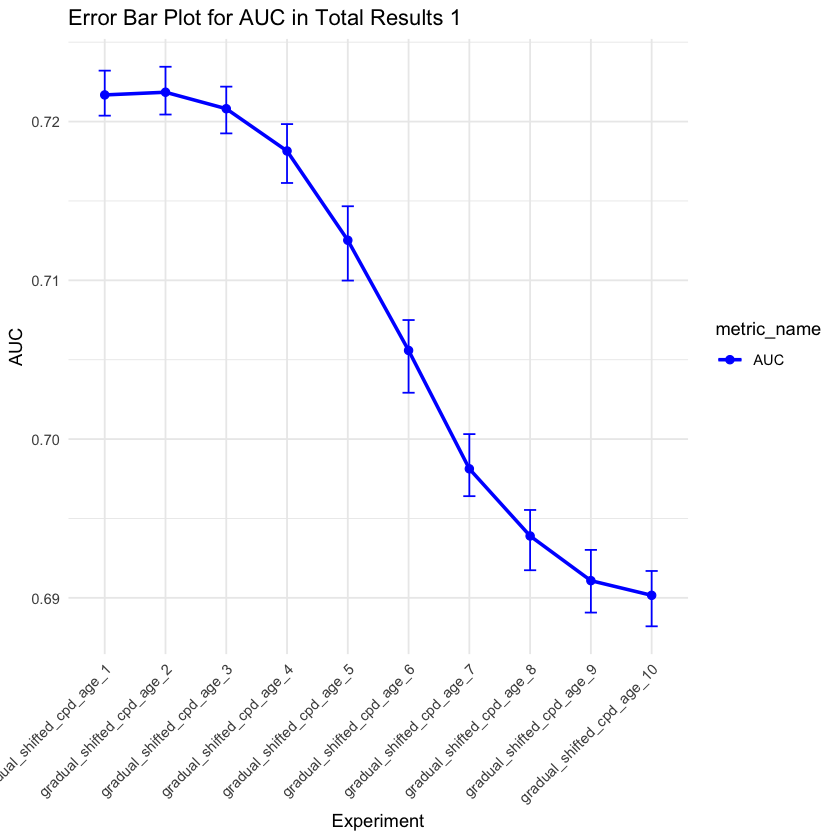

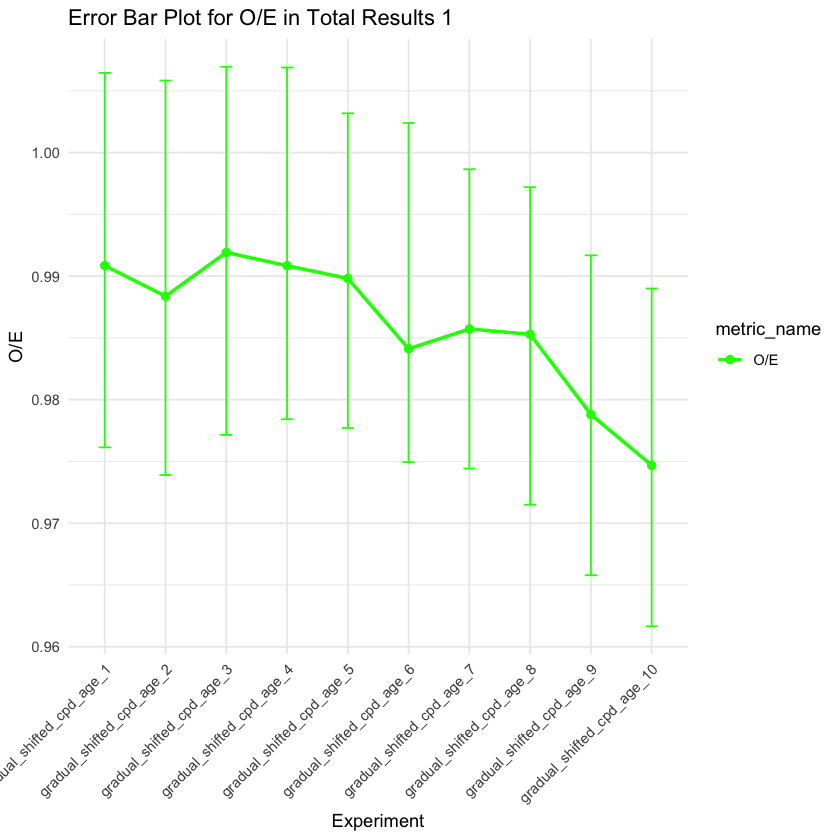

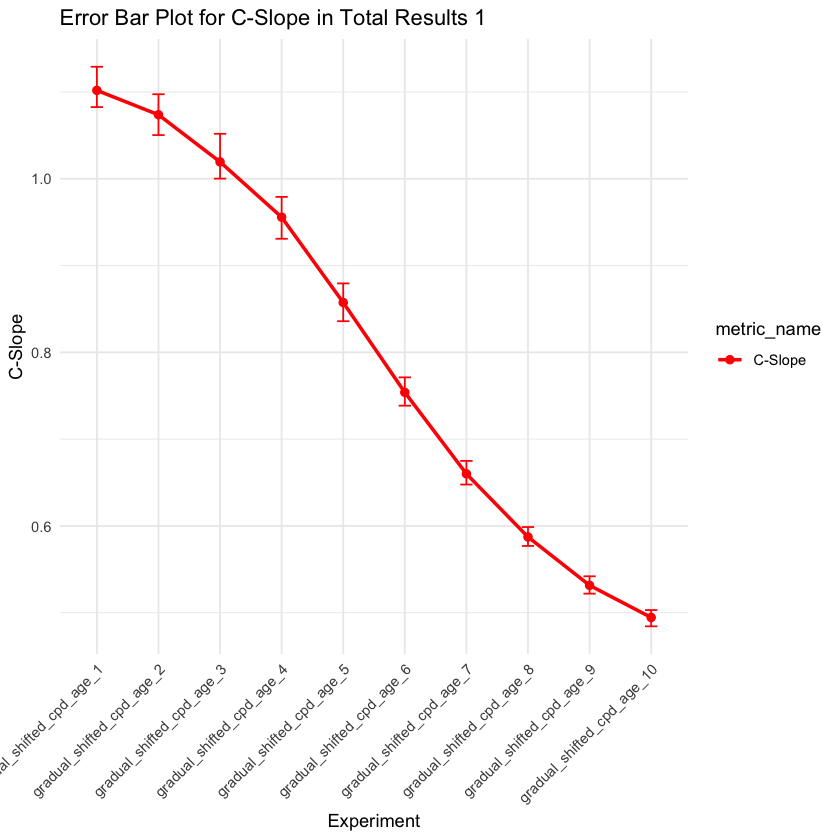

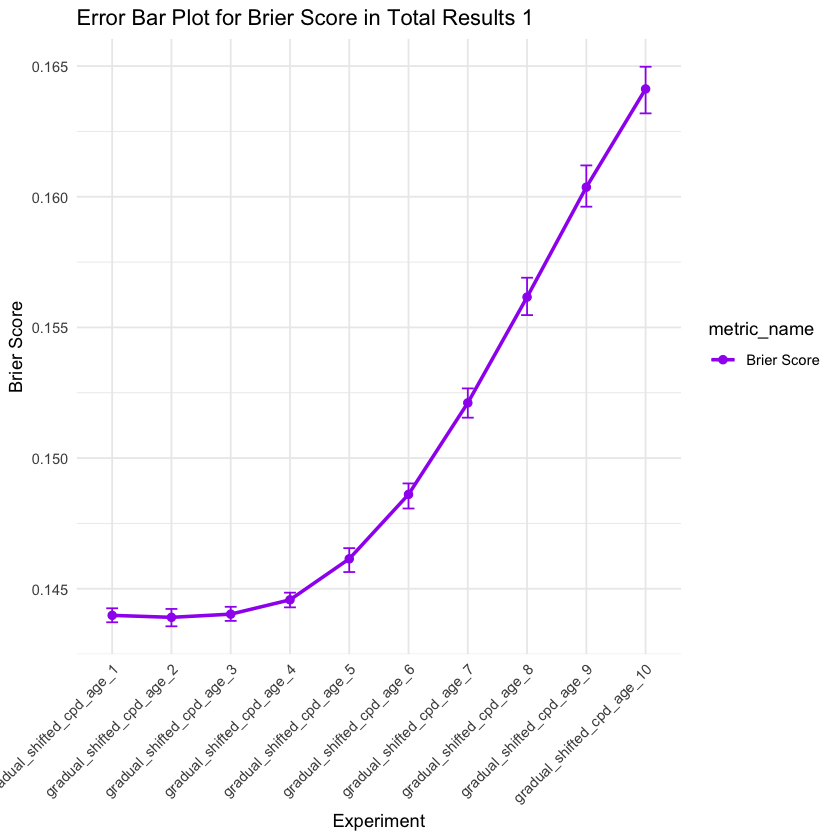

In [7]:
create_error_bar_plots(results_shifted_both_2_ml, "Total Results 1")